# KKProject_7_TestingAndEvaluation

In this notebook I'll be optimising the iForest algorithm and evaluating it.


## Summary from last notebook

- the new dats generated by Rohan works well with the iForest algorithm
- We need to optimise the algorithm by using test data

## The next steps would be

- after an optimised iForest algorithm is found, we need to translate the result into thresholds that can be put into the Arduino
- I expect this to be a reciprocal curve, so to simplify the curve fit we'd take a reciprocal of the data, fit the curve with the correct polynomial, then re-reciprocal it.

## Libraries needed

In [62]:
# file management
import os
import pickle

# mathematical
import numpy as np
from scipy.spatial.distance import cdist 

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# modelling

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

## Functions

In [63]:
def directory_to_df(path,filetype = '.csv',ignore_index = True):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    filetype: a string of the file extension (must include .)
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    for filename in os.listdir(path):
        if filetype in filename:
            curr_df = pd.read_csv(path+filename)
            frames.append(curr_df)
            filenames.append(filename.replace(filetype,''))
            for i in range(curr_df.shape[0]):
                file_column.append(test_index)
            test_index+=1
    
    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames

## New data

In [64]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/'

df,files = directory_to_df(path,ignore_index = False)

columns = df.columns.values.tolist()
columns.remove('date')
df.drop('gyrZ',inplace = True, axis = 1)

df.columns = columns
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))

df.head()

accX  accY  accZ   gyrX   gyrY   gyrZ  files  accTotal  \
2020-09-09 16:27:07  0.08  0.01  0.11 -13.49   5.99 -21.58      1  0.136382   
2020-09-09 16:27:08  0.05 -0.03 -0.12  22.86  23.19  -1.88      1  0.133417   
2020-09-09 16:27:09  0.00 -0.01  0.00   4.29  -5.49   7.91      1  0.010000   
2020-09-09 16:27:09 -0.03  0.06 -0.14 -16.51  -0.30  -1.01      1  0.155242   
2020-09-09 16:27:10 -0.01  0.00  0.01   2.25 -21.86  11.49      1  0.014142   

                      gyrTotal  
2020-09-09 16:27:07  26.144915  
2020-09-09 16:27:08  32.617328  
2020-09-09 16:27:09  10.540982  
2020-09-09 16:27:09  16.543585  
2020-09-09 16:27:10  24.798028

## Test Data

In [99]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/'

df_test, files = directory_to_df(path, ignore_index = False)
columns = df_test.columns.values.tolist()
columns.remove('date')
df_test.drop('gyrZ',inplace = True, axis = 1)
df_test.columns = columns
df_test['accTotal'] = np.sqrt(np.power(df_test[['accX','accY','accZ']],2).sum(axis = 1))
df_test['gyrTotal'] = np.sqrt(np.power(df_test[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
print(files)
df_test.head()

['adjusting-seating-position', 'falling', 'crossing-arms', 'walking', 'crossing-legs', 'fetching-remote', 'sitting-down', 'lifting-leg', 'lying-down']


accX  accY  accZ   gyrX   gyrY   gyrZ  files  accTotal  \
2020-09-11 18:38:55  0.03  0.03  0.00   2.64   1.00   0.26      1  0.042426   
2020-09-11 18:38:56  0.01  0.01  0.00   0.85   1.00   0.26      1  0.014142   
2020-09-11 18:38:57  0.01  0.02  0.03   5.10   9.25   7.77      1  0.037417   
2020-09-11 18:38:58  0.05  0.02  0.03   5.10  13.47  14.31      1  0.061644   
2020-09-11 18:38:58  0.05  0.07  0.09  15.22  13.47  14.31      1  0.124499   

                      gyrTotal  
2020-09-11 18:38:55   2.834996  
2020-09-11 18:38:56   1.337946  
2020-09-11 18:38:57  13.112795  
2020-09-11 18:38:58  20.303374  
2020-09-11 18:38:58  24.856898

## Data preparation for model

In [97]:
significance = [1,-1,1,-1,1,-1,-1,-1,1] # -1 == sig, 1 == non sig
scaler = MinMaxScaler()
X_test = []
Y_test = []
for filetype in df_test.files.unique():
    X_test.append(scaler.fit_transform(np.asarray(df_test[['accTotal','gyrTotal']][df_test.files == filetype])))
    Y_test.append(np.asarray([significance[filetype -1] for i in range(X_test[filetype-1].shape[0])]))
    
X_train = scaler.fit_transform(np.asarray(df[['accTotal','gyrTotal']]))

## Evaluation

In [120]:
def findBestModel(X_train, X_test, Y_test, model='iForest'):
    """ Function to find the best parameters to use for a given model 
    components: 
    X_train: numpy array of the input data
    X_test: list containing numpy arrays of different test data
    Y_test: list containing numpy array of different test outcomes (note that this is configured differently 
    for different algorithms,for iForest, each column must have -1 or 1. -1 --> the anomaly, if 1 --> not an anomaly)
    model: string to determine model type
    """
    if model == 'iForest':
        for max_features in range(1,X_train.shape[1]+1):
            for contamination in range(1,101):
                """ this type of looping very slow... do what iis recommended by David Malan from harvard course, 
                i.e. half the book each time"""
                iForest = IsolationForest(n_estimators = 100, max_features = max_features,\
                                         contamination = contamination/1000, random_state = 0).fit(X_train)
               
                #put this plotting into a function. Make sure two add multi color system, not only for a
                #binary problem
                output = iForest.predict(X_train)
                true_false = []
                
                for item in output:
                    if item == 1:
                        true_false.append(False)
                    else:
                        true_false.append(True)
        
                anomalies = df[true_false]
                actuals = df[[not i for i in true_false]]
                
                plt.figure(figsize = (16,8))
                #plt.plot(anomalies.index,anomalies.accTotal,'r.')
                #plt.plot(actuals.index,actuals.accTotal,'b.')
                plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
                plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
                plt.title('iForest with contamination={},max_features={}'.format(contamination/1000,max_features))
                
                plt.show()
                
                for x_test,y_test in zip(X_test,Y_test):
                    y_hat = iForest.predict(x_test)
                    score = evaluate(y_test,y_hat) # returns accuracy score
                    print(score)
def evaluate(y_test, y_hat):
    """ function to evaluate the score of a predicted array and a 'ground truth' array
    components:
    y_test:
    y_hat:
    """
    score = np.sum(y_test==y_hat)
    return score

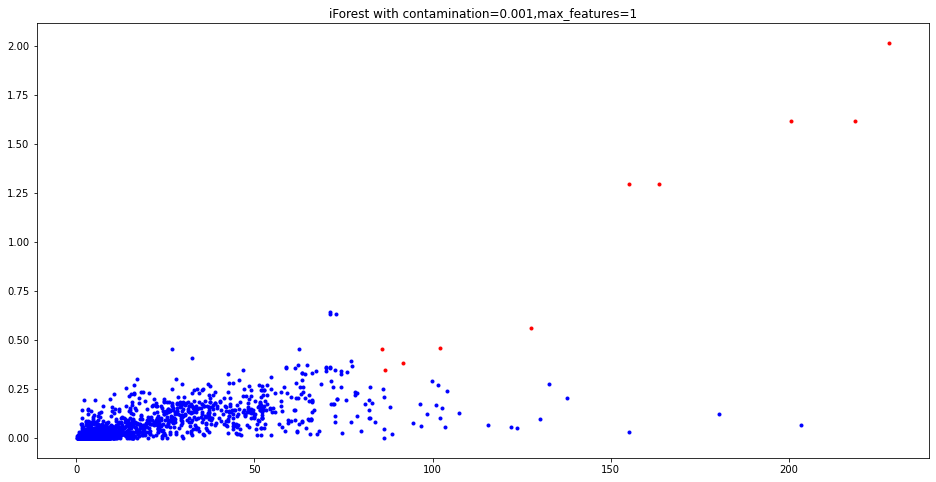

29
24
25
46
33
18
27
20
37


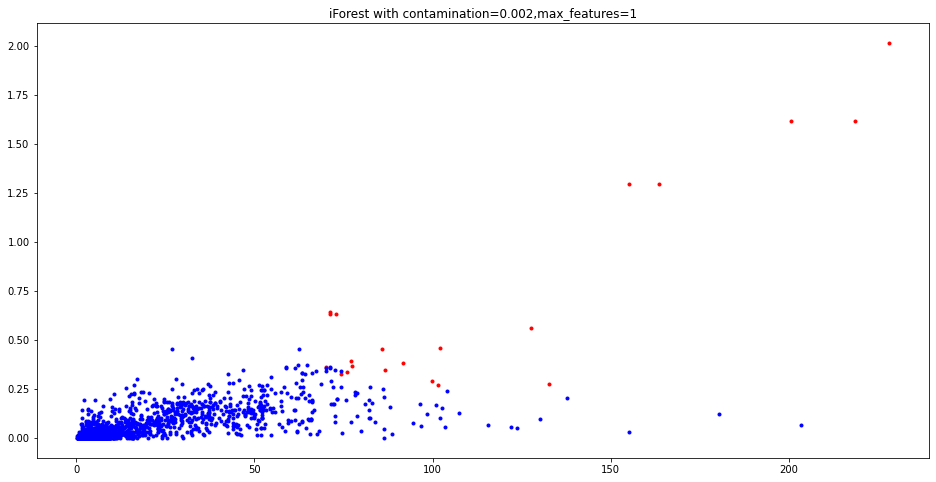

27
32
22
49
31
19
29
21
34


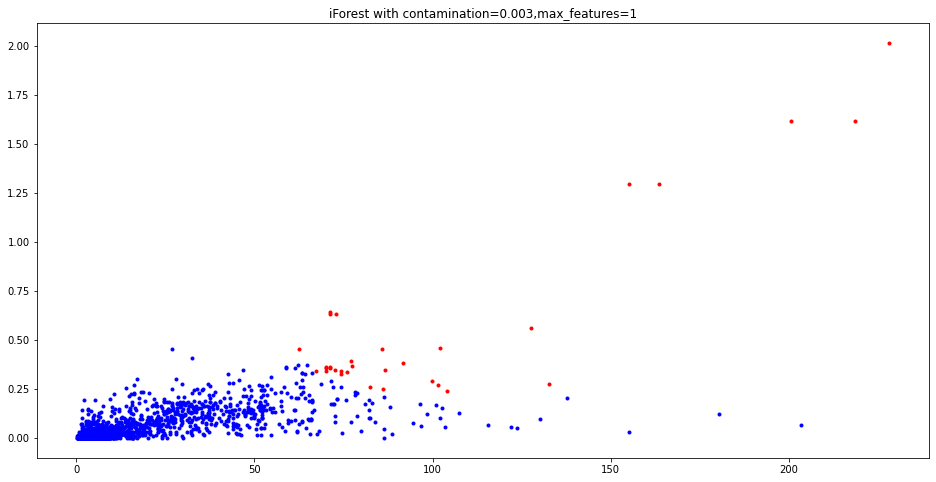

25
37
22
51
29
20
30
21
33


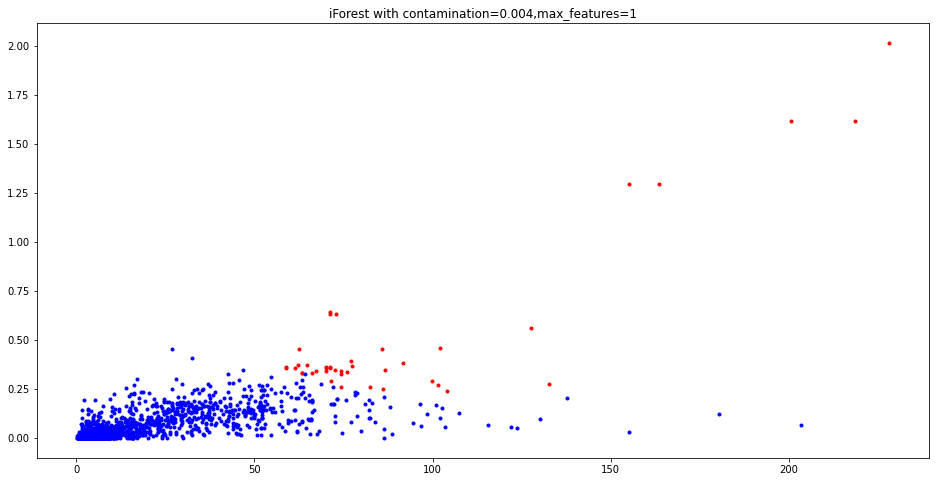

23
38
21
54
27
21
30
21
31


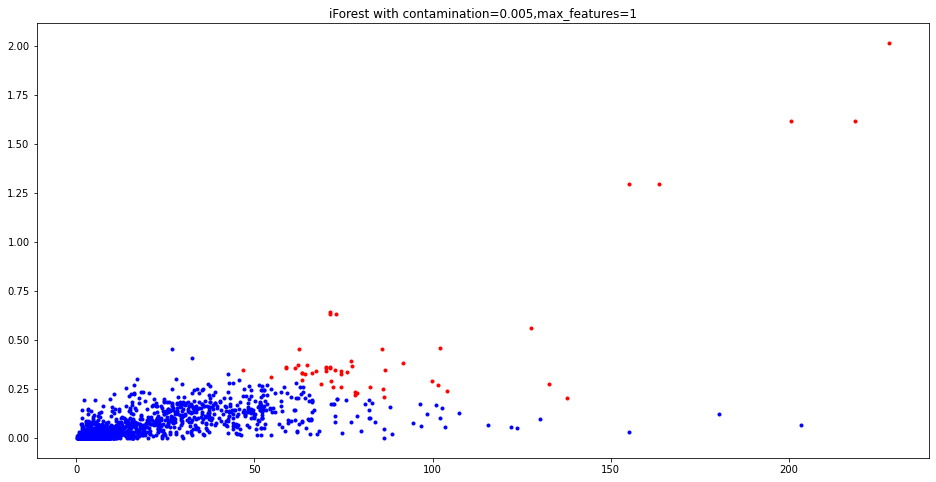

22
43
21
54
26
24
32
22
30


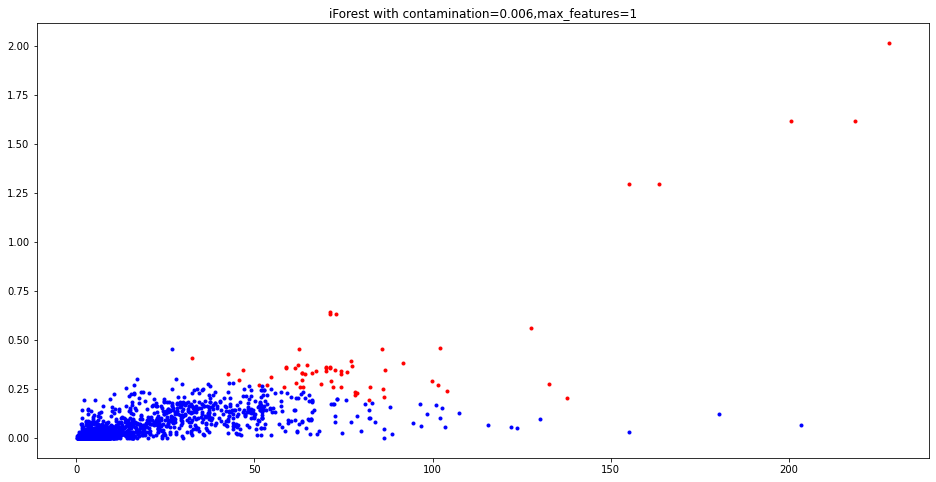

21
46
20
54
24
26
33
28
28


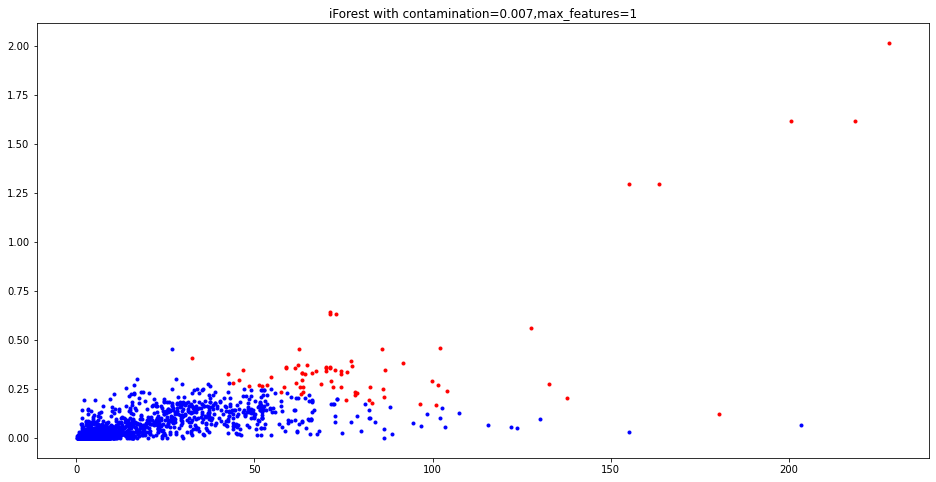

20
46
20
55
24
28
33
29
28


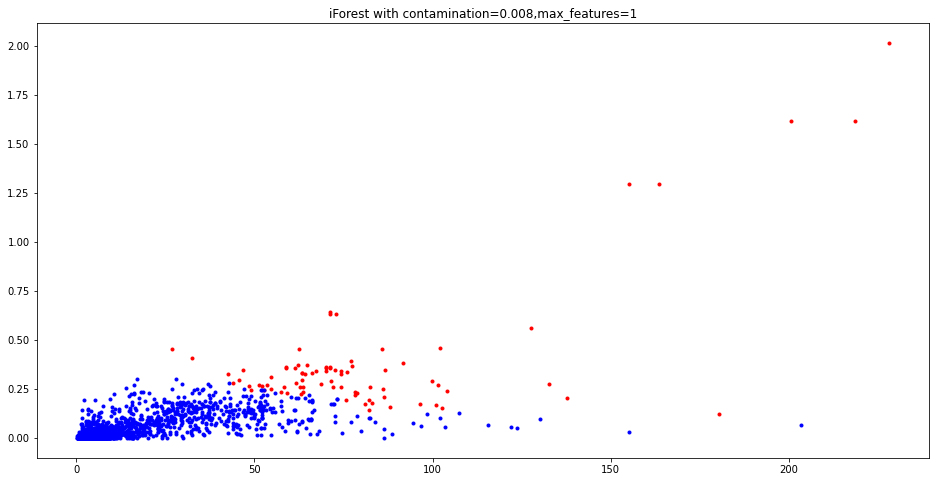

20
47
20
55
23
28
33
30
27


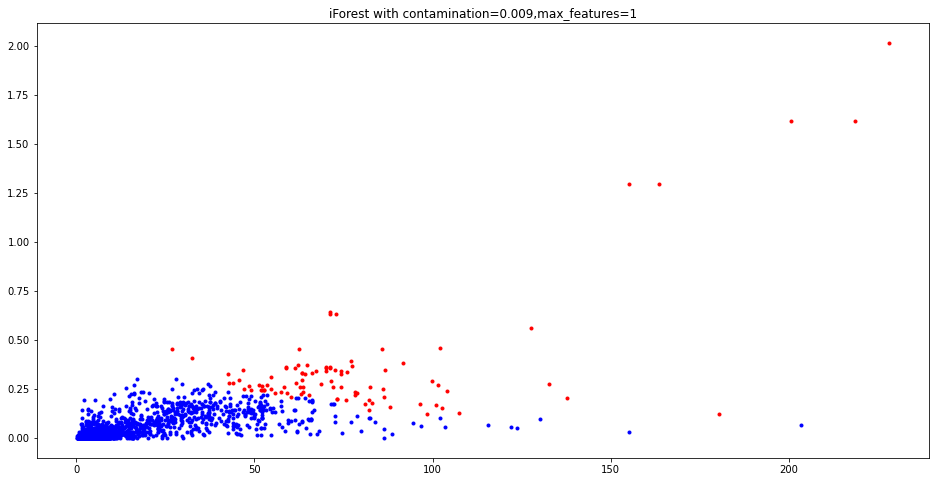

20
48
20
55
21
29
35
34
26


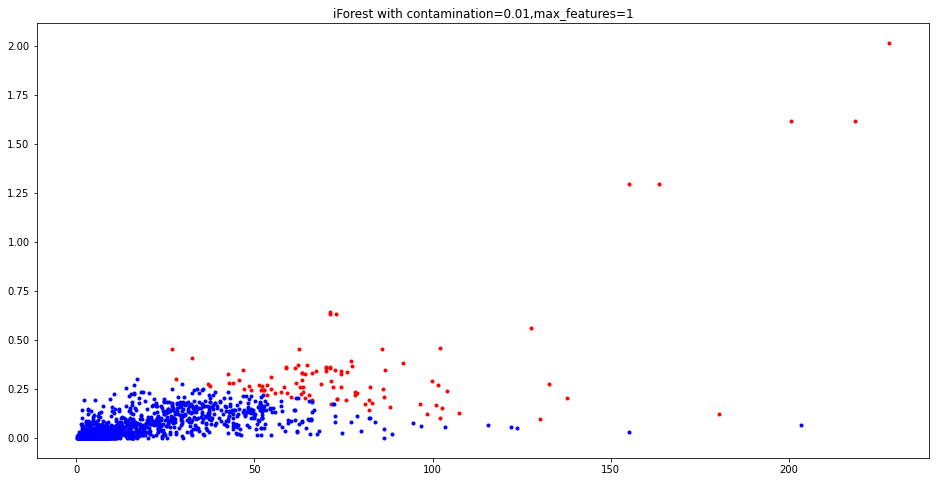

20
49
20
55
21
30
35
36
26


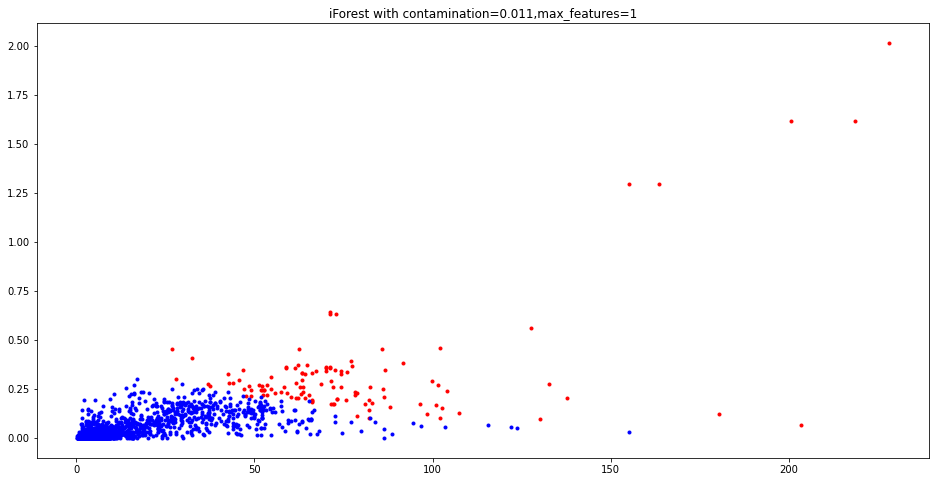

20
49
20
55
21
31
35
38
23


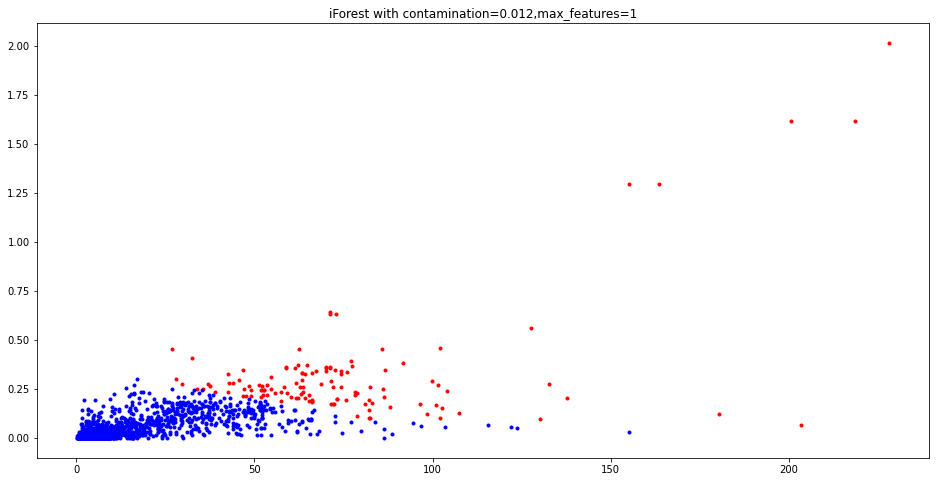

20
49
20
55
21
31
35
40
23


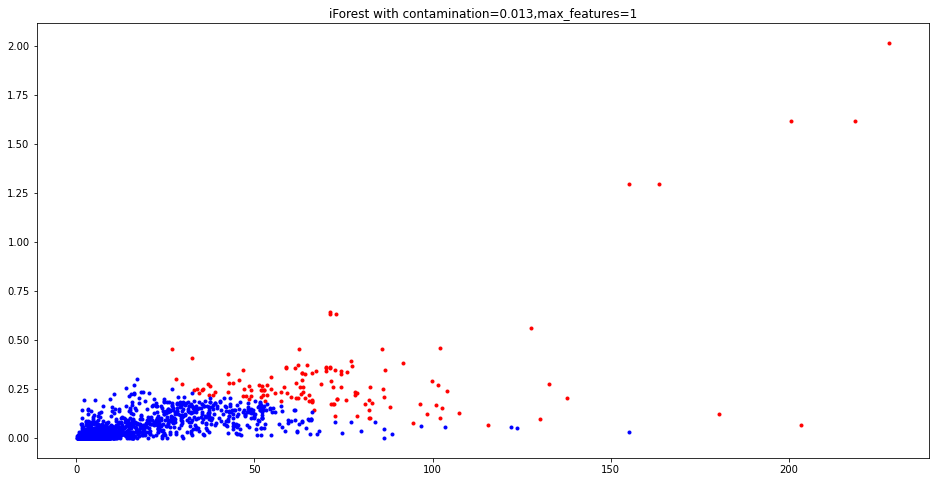

18
49
20
55
19
33
35
42
23


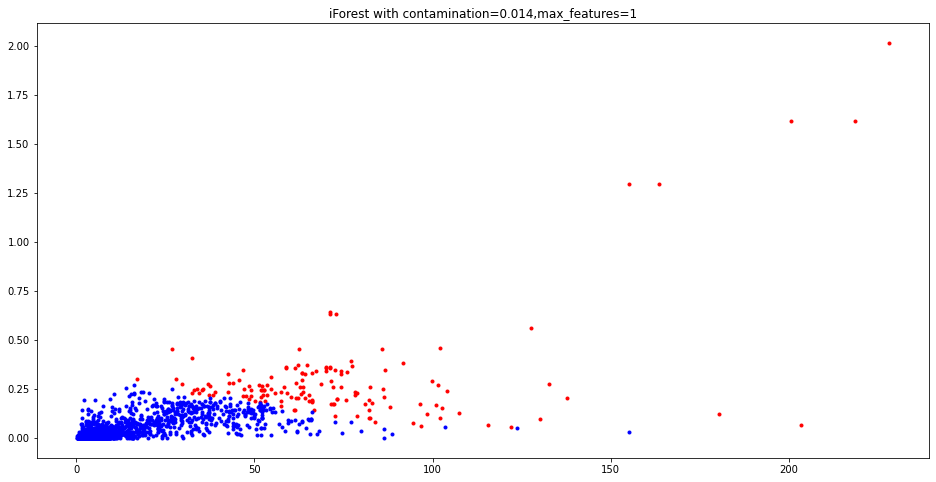

18
49
20
55
19
33
35
42
21


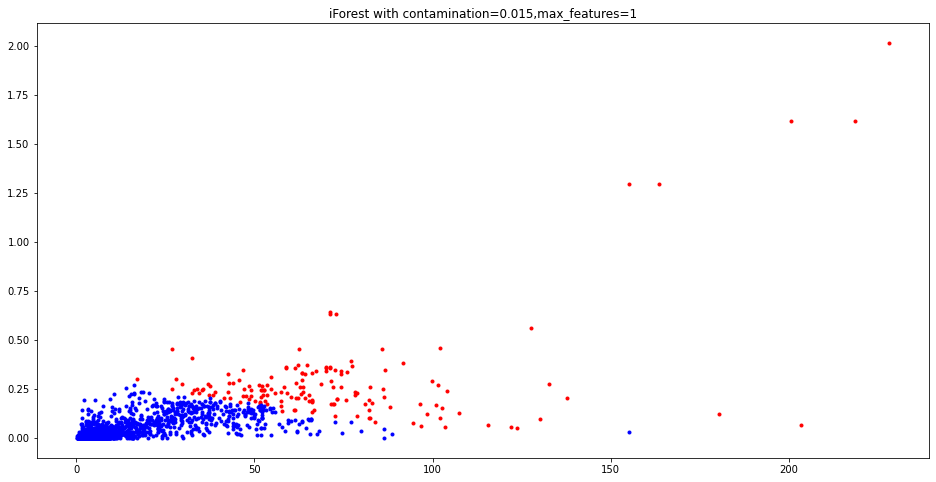

18
49
20
56
19
34
36
42
21


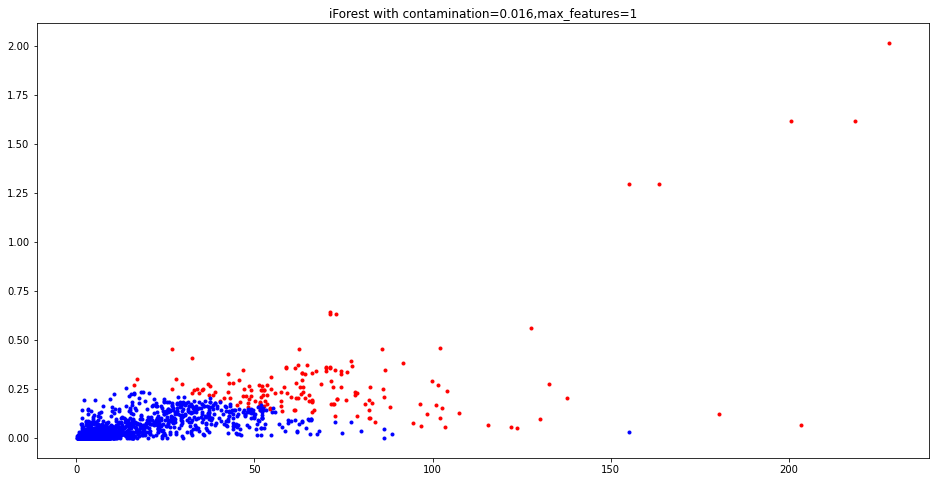

16
51
20
56
18
34
36
43
20


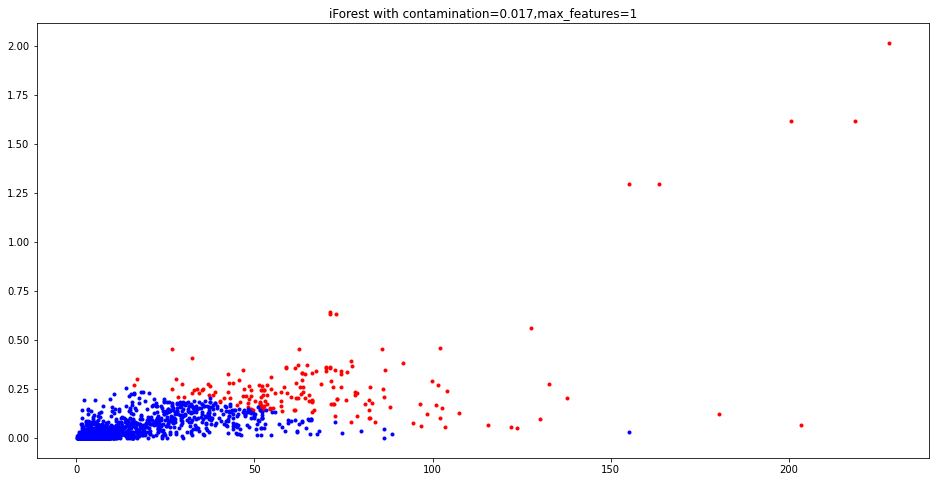

16
52
20
56
17
34
36
43
19


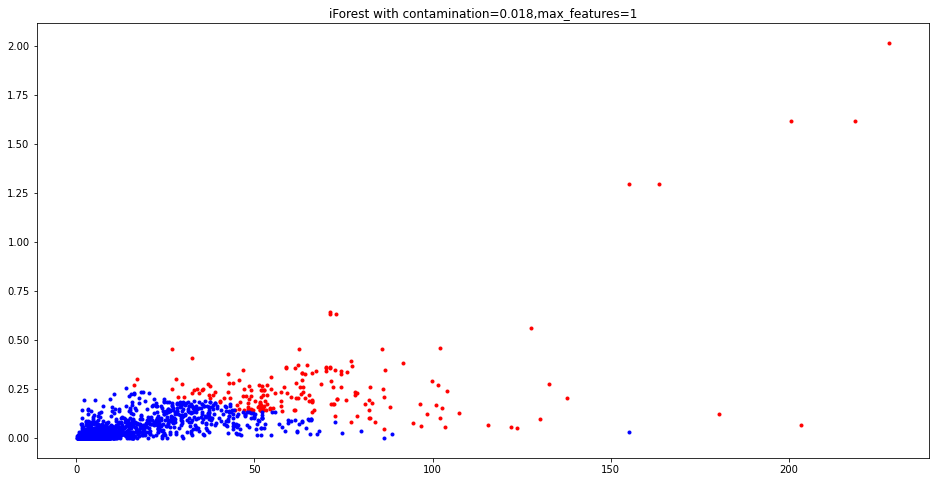

16
53
20
56
17
34
36
44
18


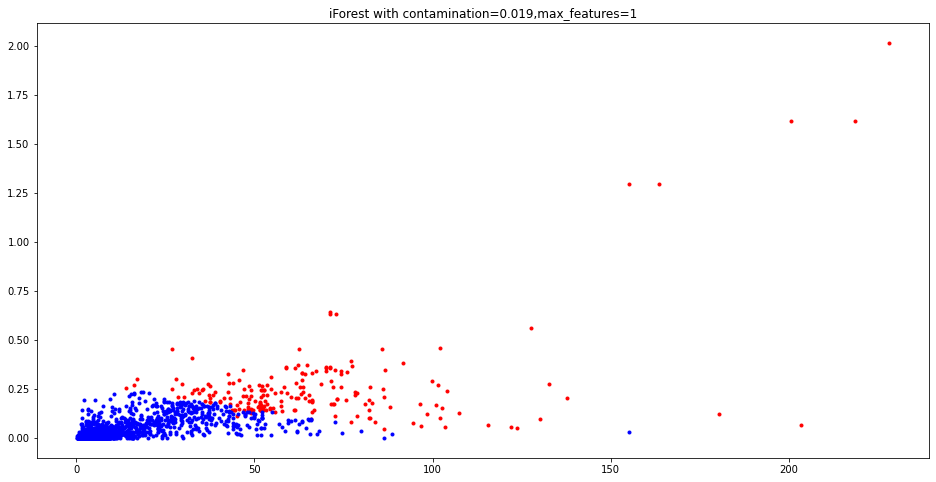

16
53
20
56
17
34
36
44
18


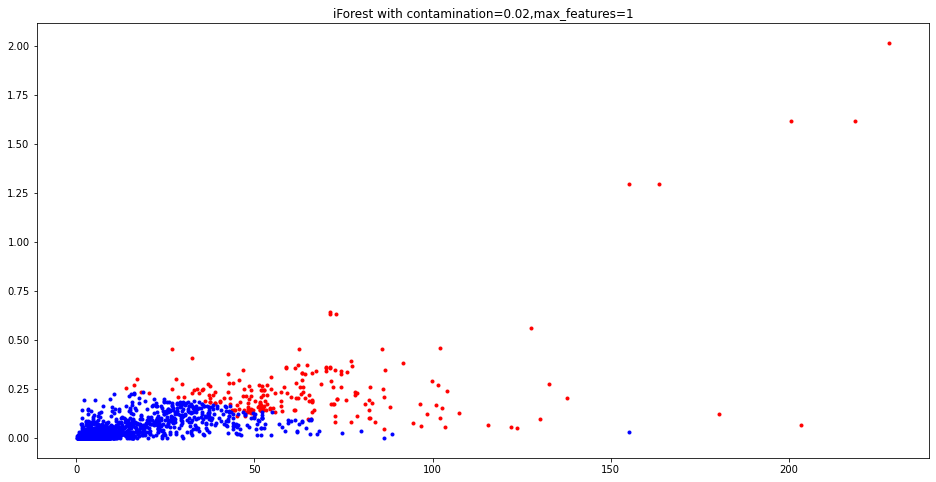

16
53
20
56
17
35
36
45
18


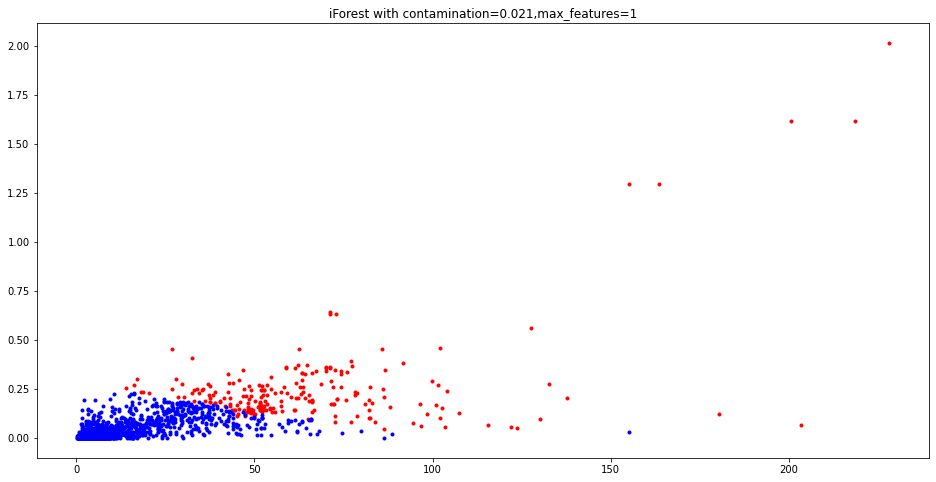

16
53
20
56
17
35
37
45
18


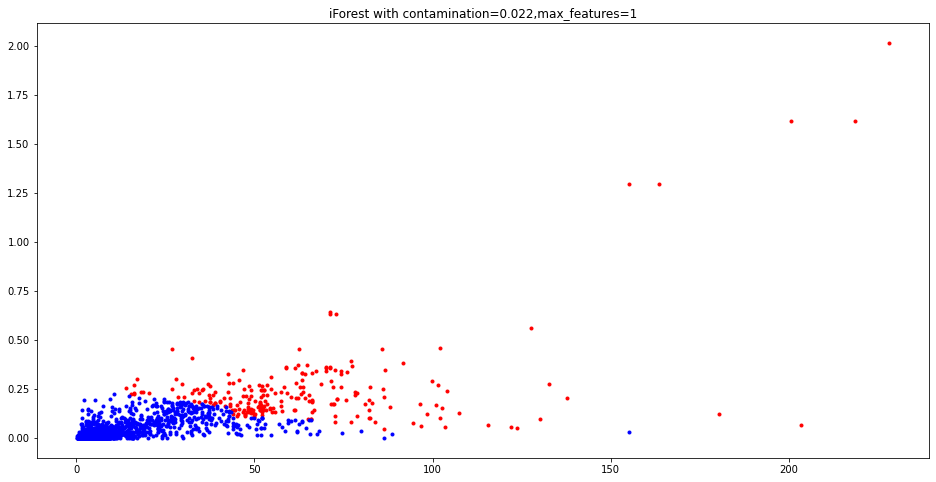

16
53
20
56
17
36
38
45
18


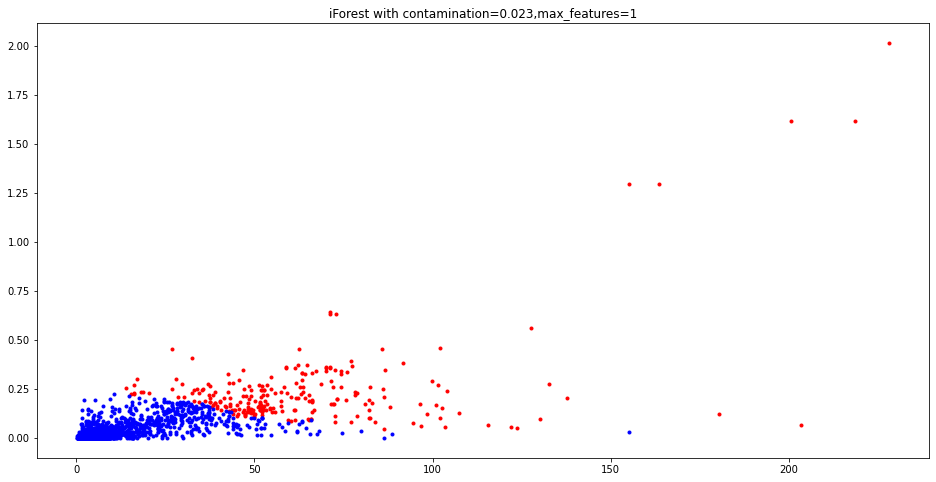

16
53
20
56
17
36
38
45
17


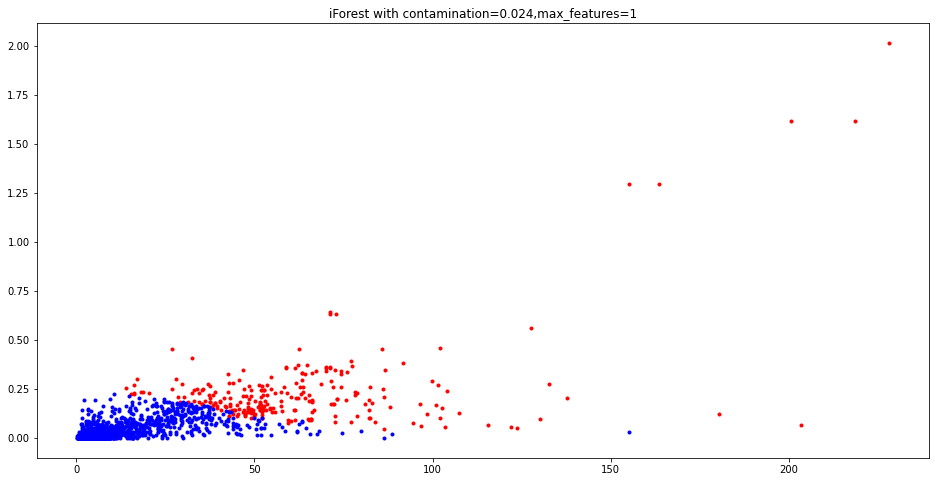

16
53
20
56
17
36
38
46
17


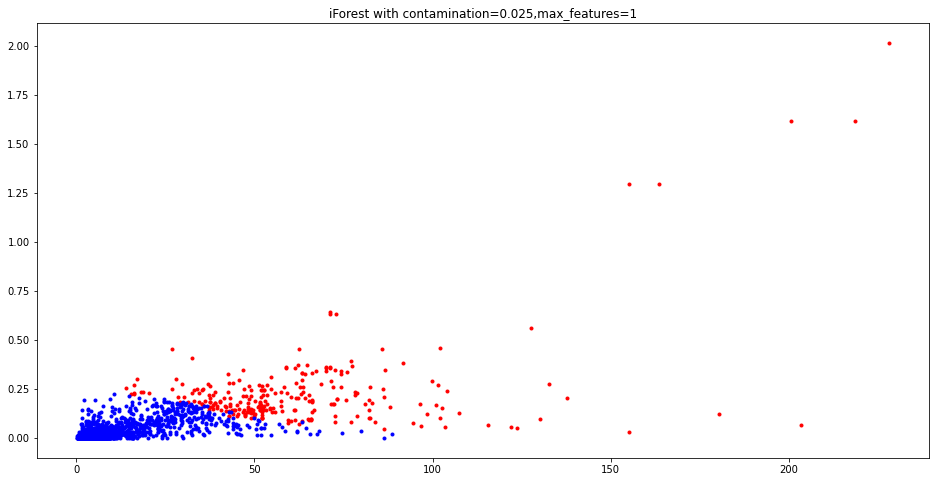

16
53
20
56
17
36
38
46
17


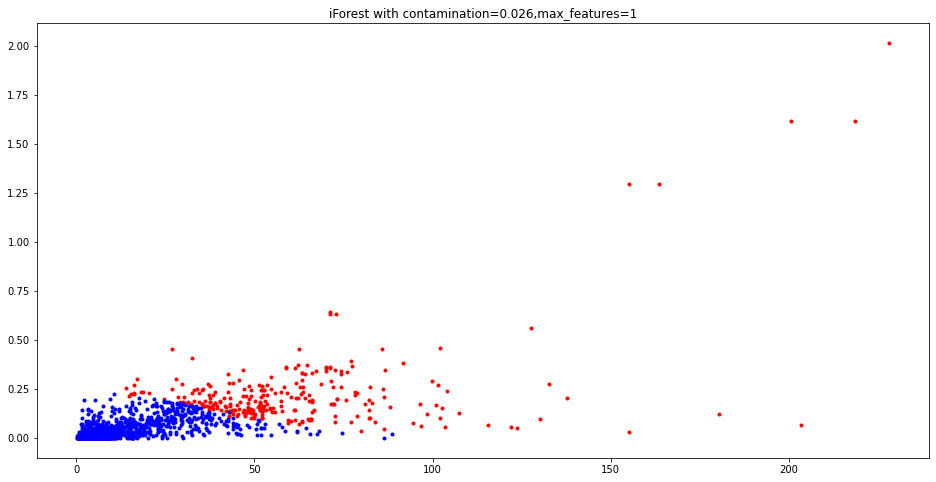

15
53
20
56
17
36
38
46
17


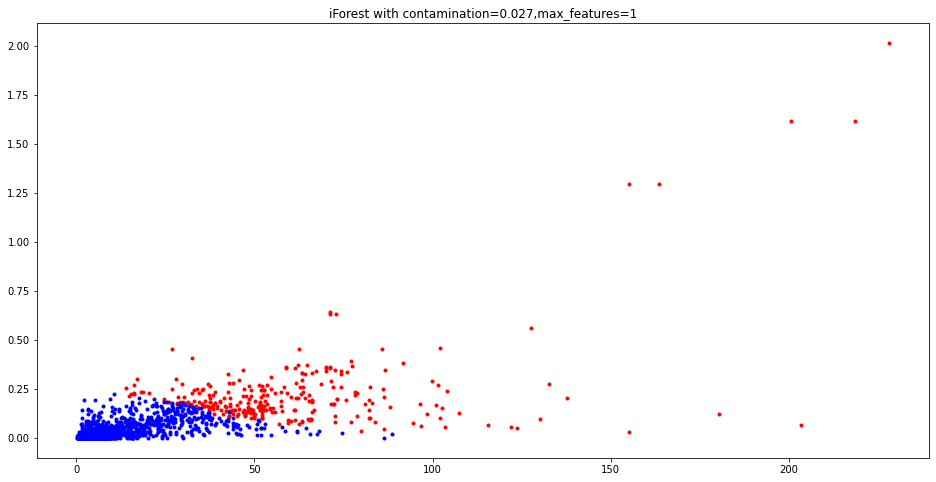

15
53
20
56
17
36
38
46
16


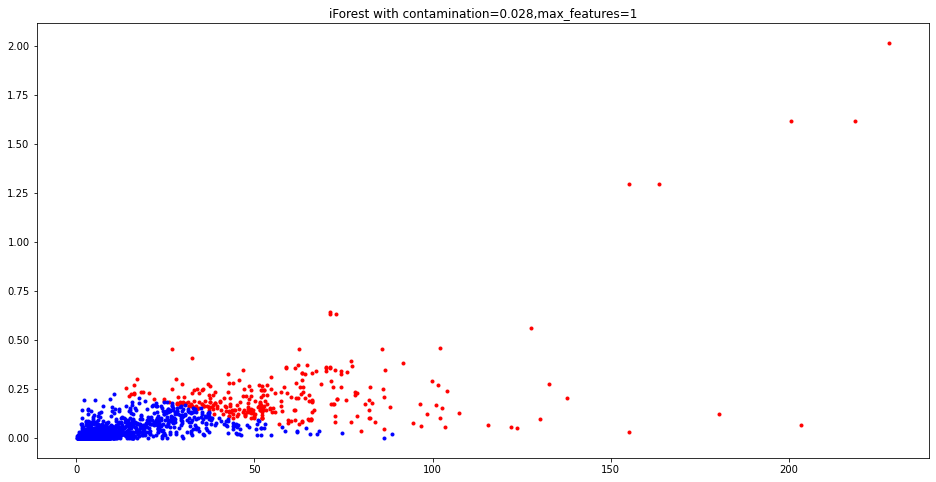

15
53
20
56
17
36
38
46
16


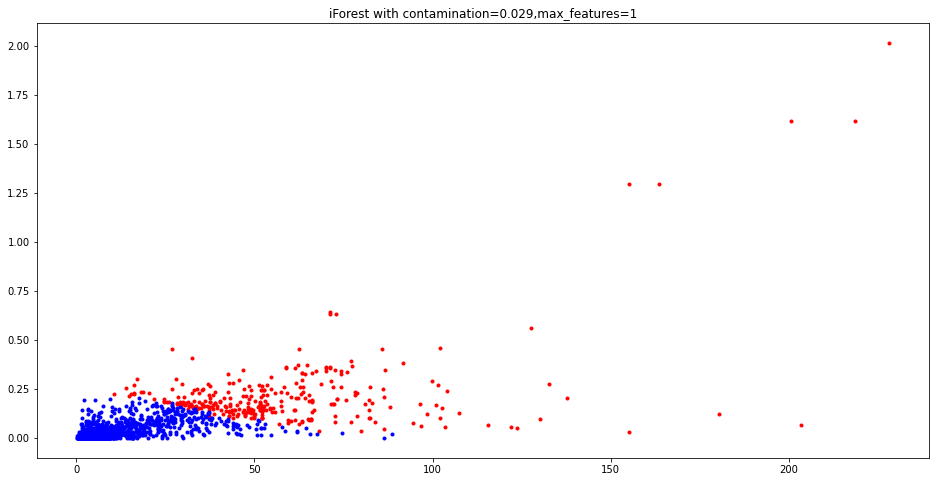

15
53
20
56
17
37
38
46
16


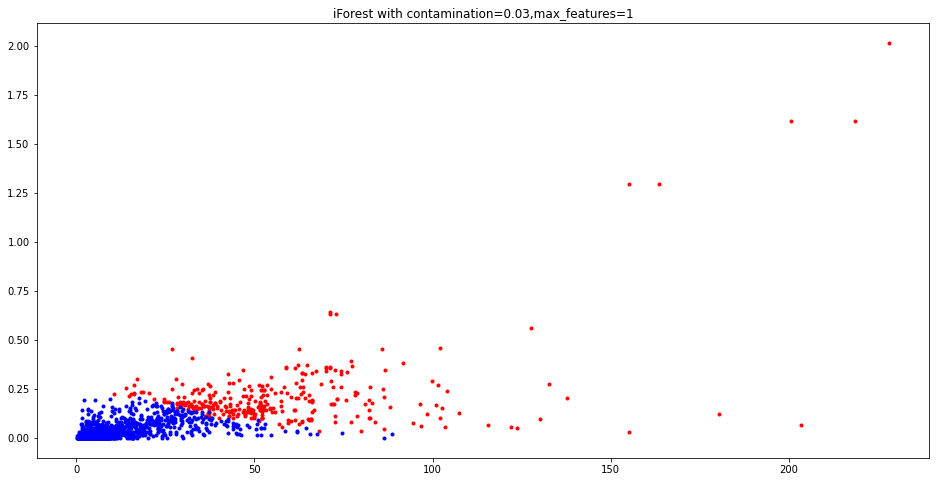

14
53
20
56
17
37
38
46
15


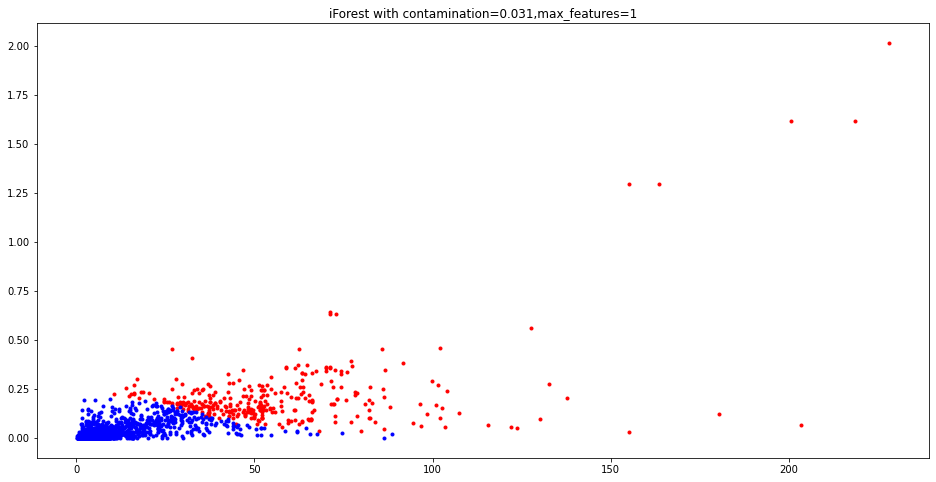

14
53
20
56
16
37
38
46
15


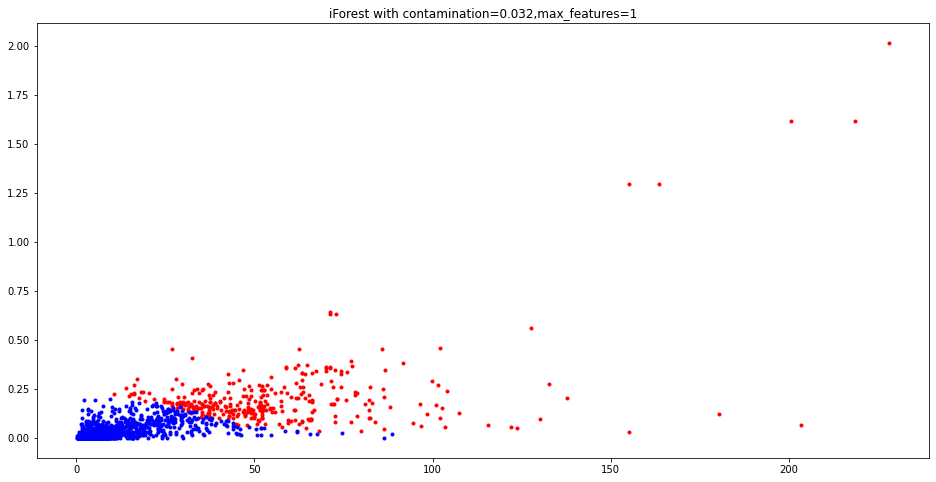

14
53
20
56
16
37
38
46
15


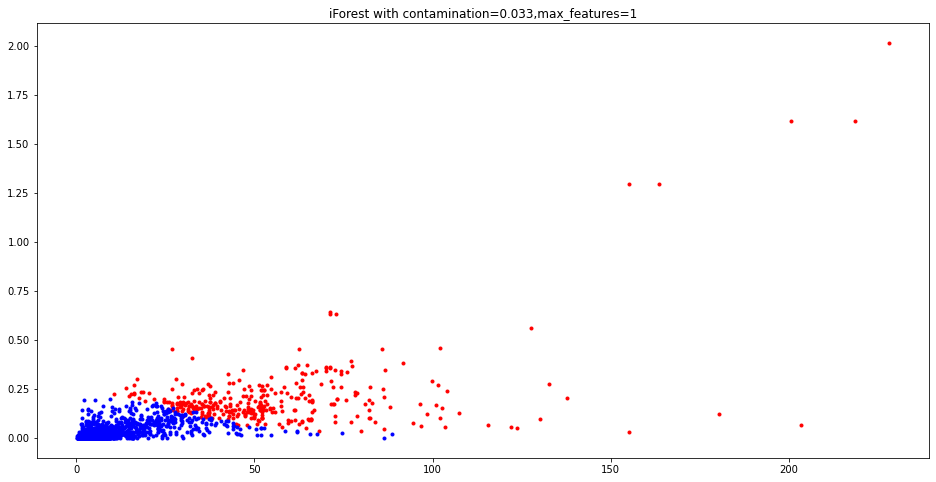

14
53
20
56
15
38
39
46
15


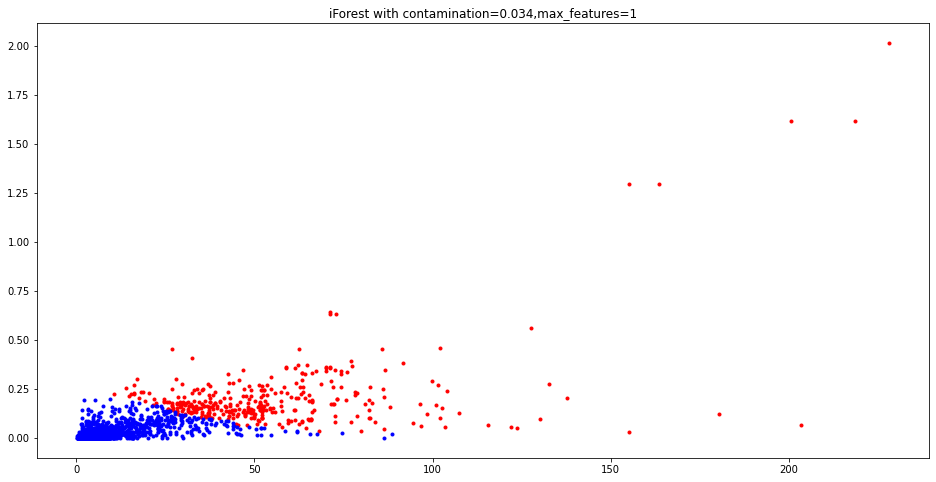

14
53
20
56
15
38
39
46
15


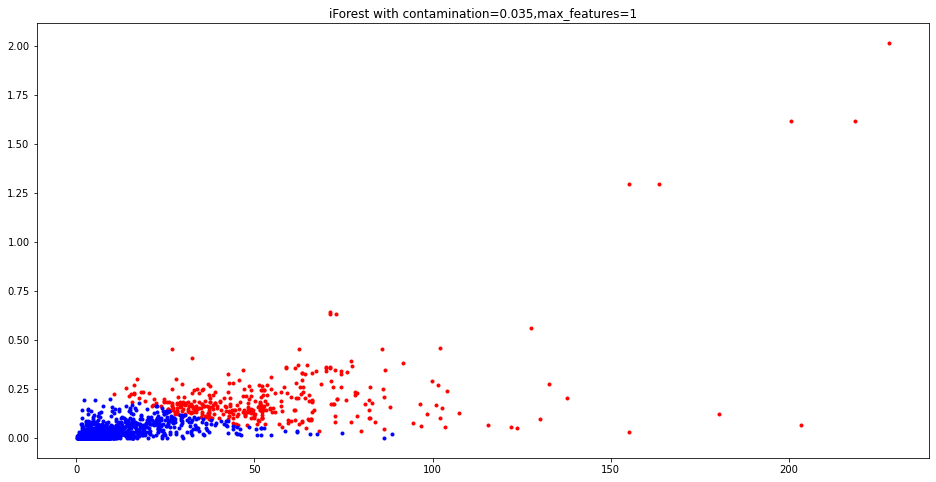

14
53
20
56
15
38
39
46
15


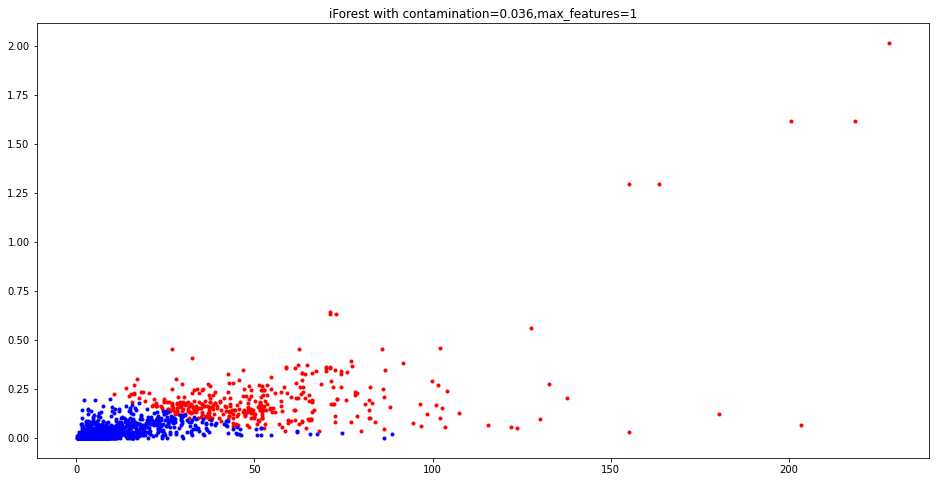

14
53
20
56
15
38
39
46
14


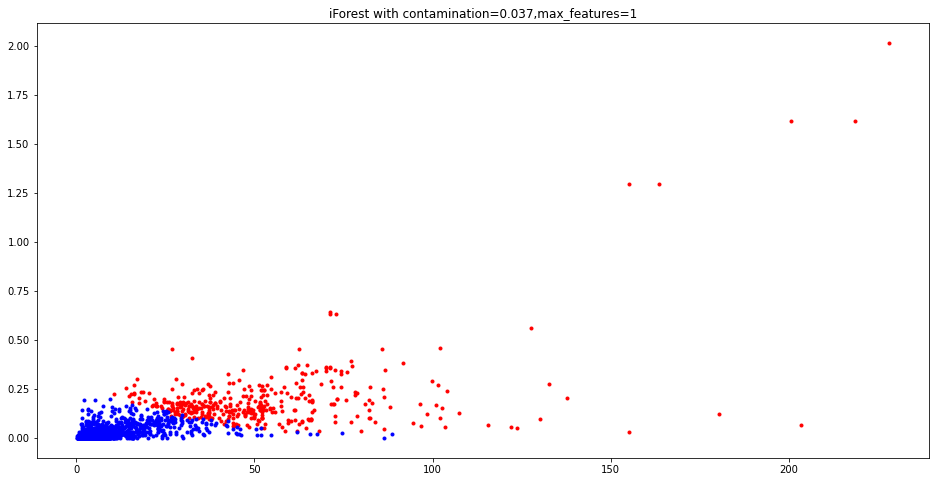

14
53
20
56
15
38
39
46
13


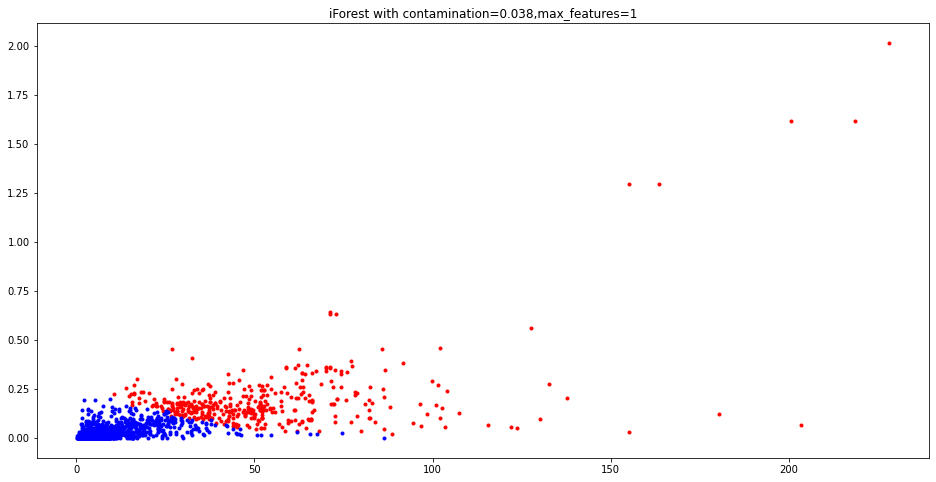

14
54
20
56
15
38
39
46
13


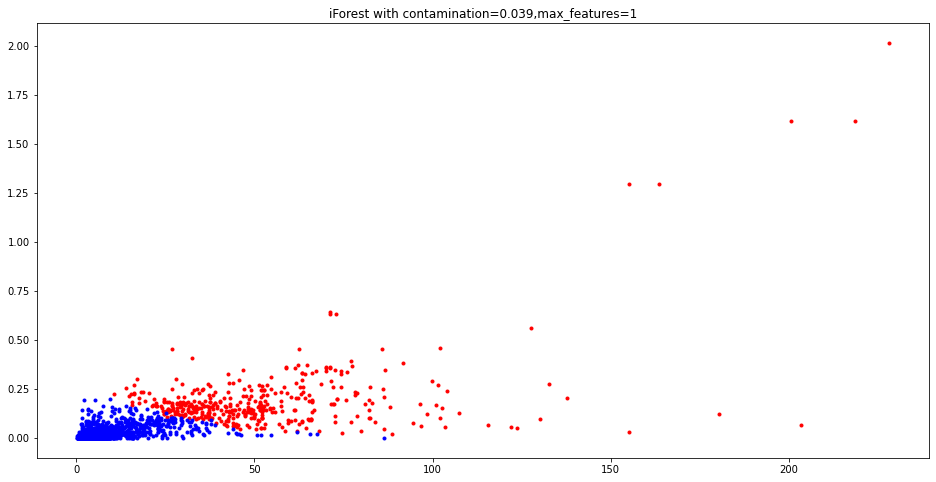

13
54
20
56
15
38
39
46
12


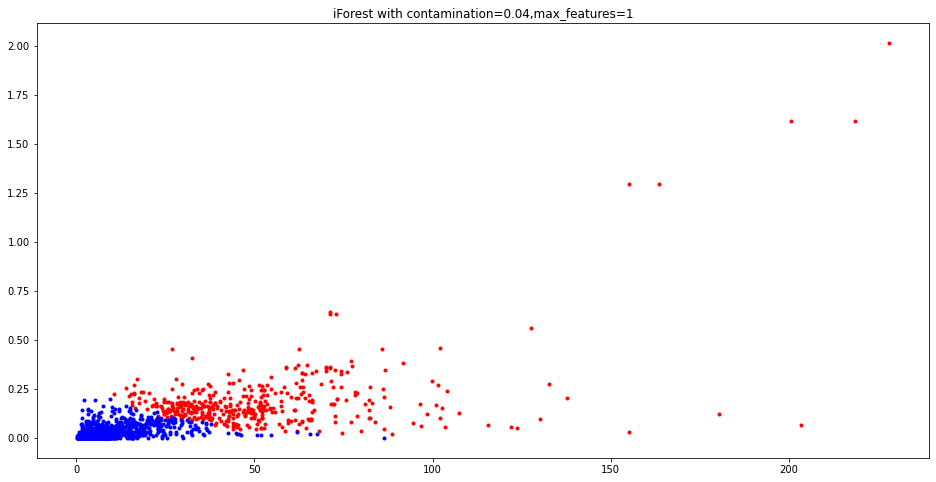

13
54
20
56
15
38
39
46
12


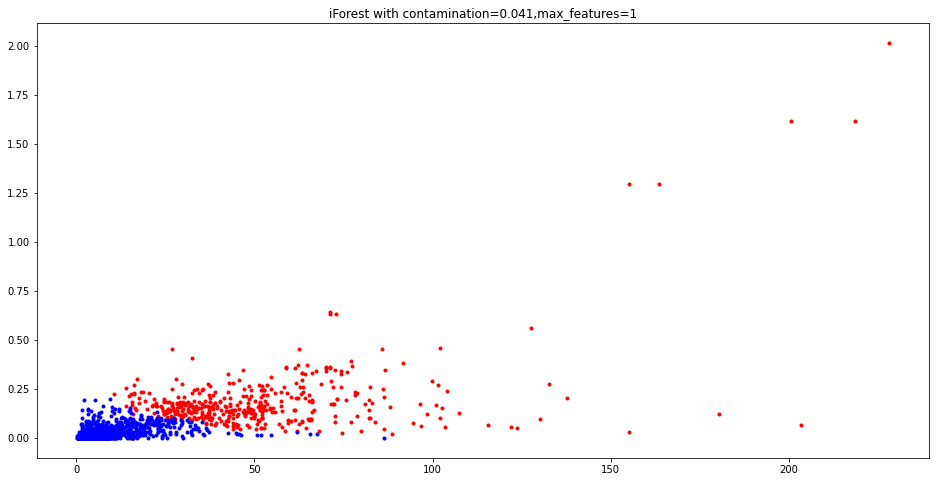

13
54
20
56
15
39
39
46
12


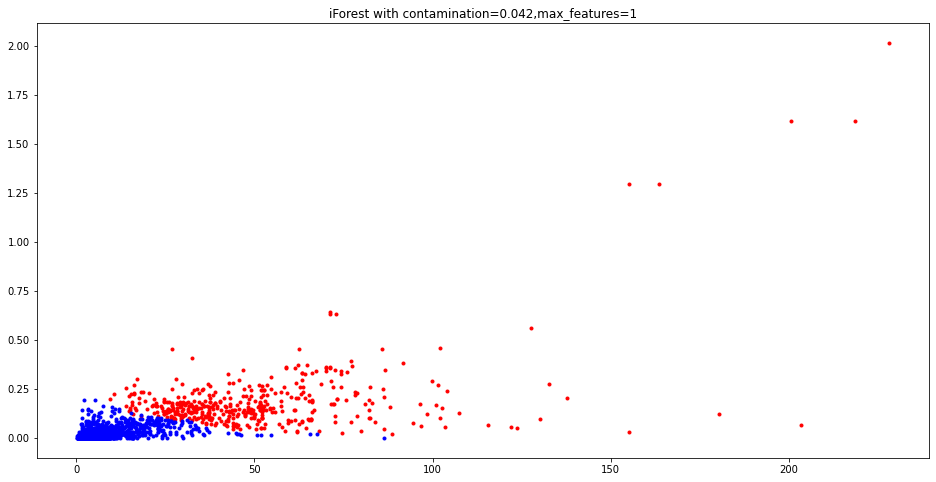

9
54
20
56
15
40
39
46
11


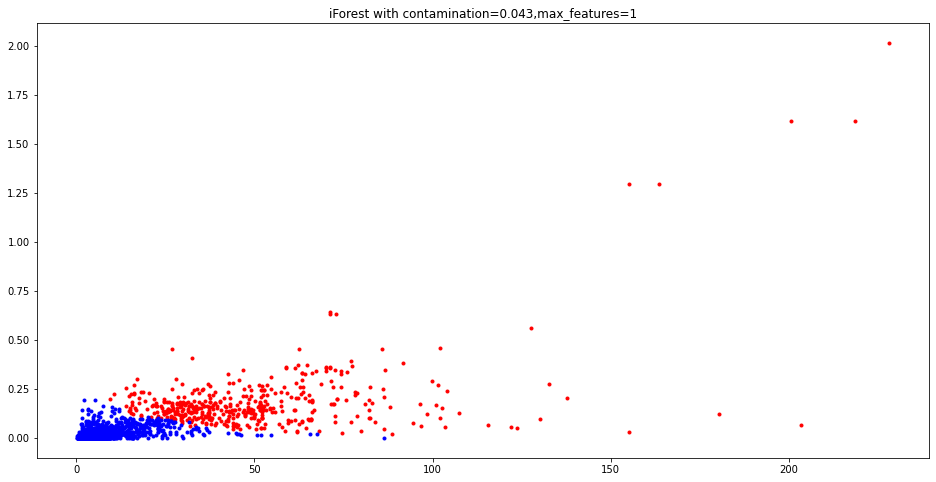

8
54
20
56
15
40
39
46
11


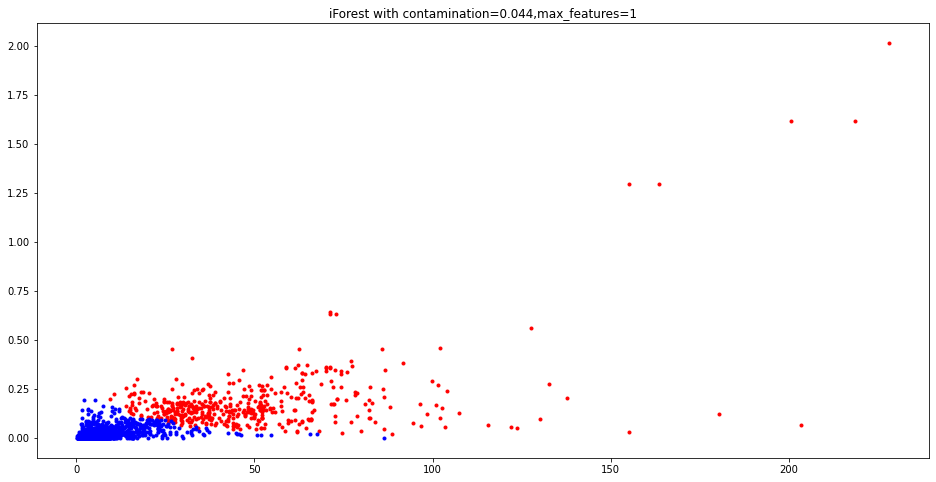

8
54
20
56
15
40
40
46
11


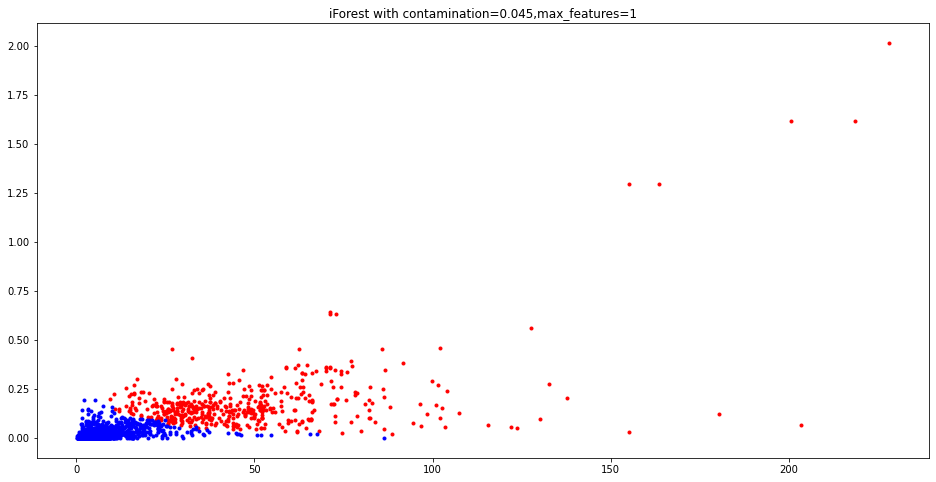

8
54
20
56
15
40
40
46
11


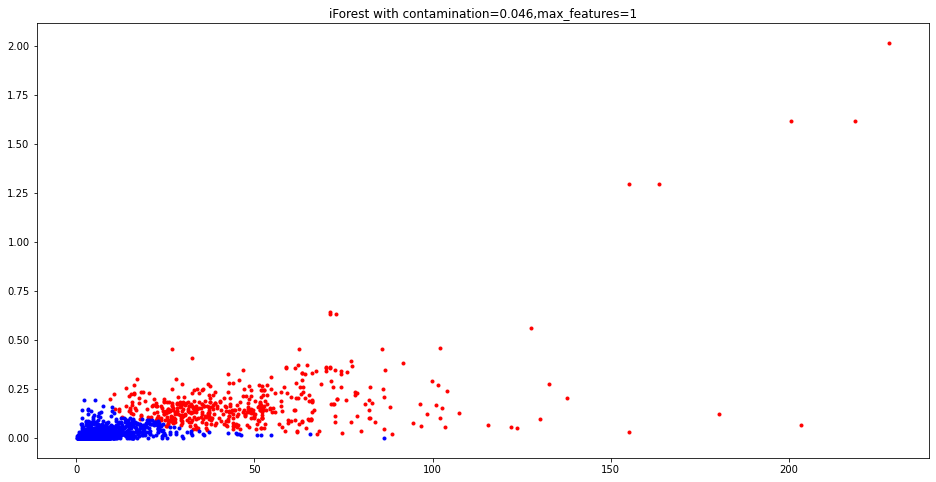

8
54
20
56
15
41
40
46
11


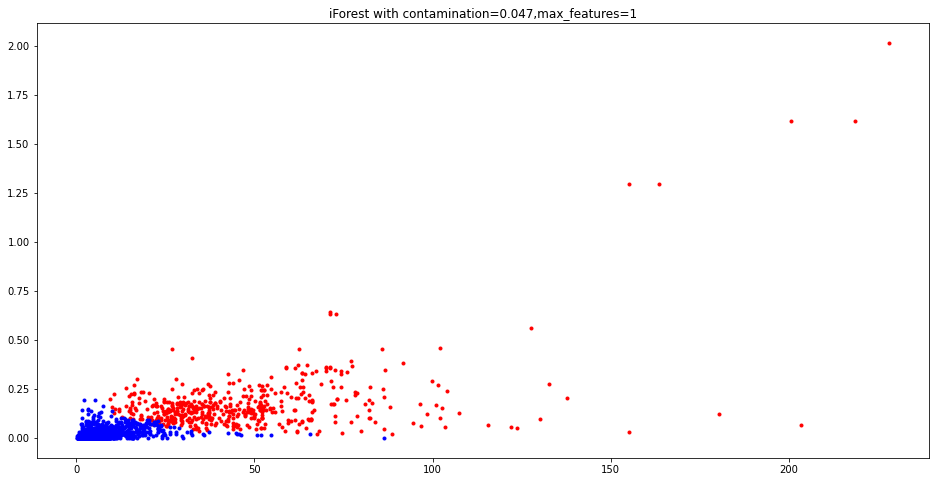

7
54
20
56
15
42
40
46
11


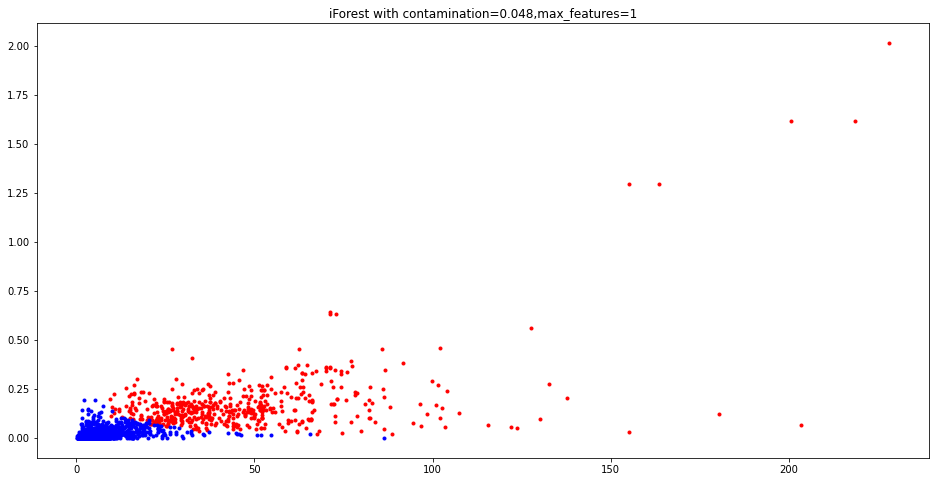

7
54
20
56
15
42
41
46
11


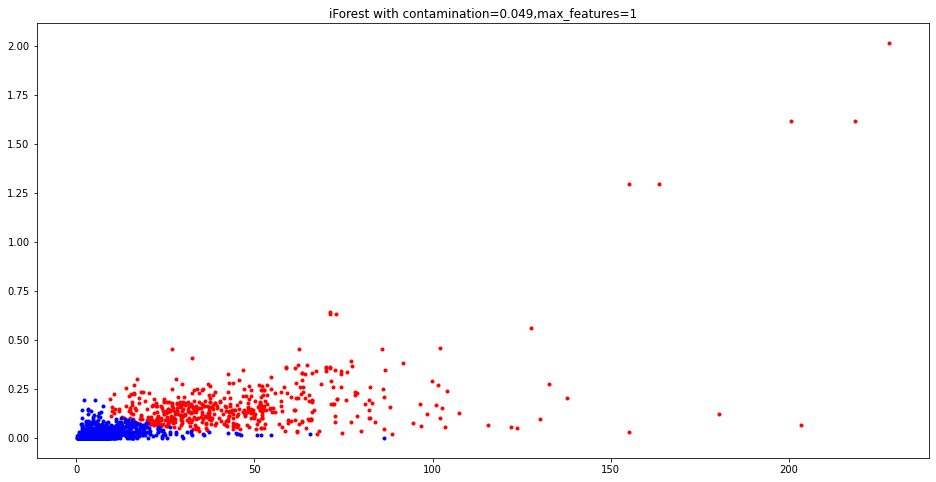

7
54
20
56
15
43
41
46
11


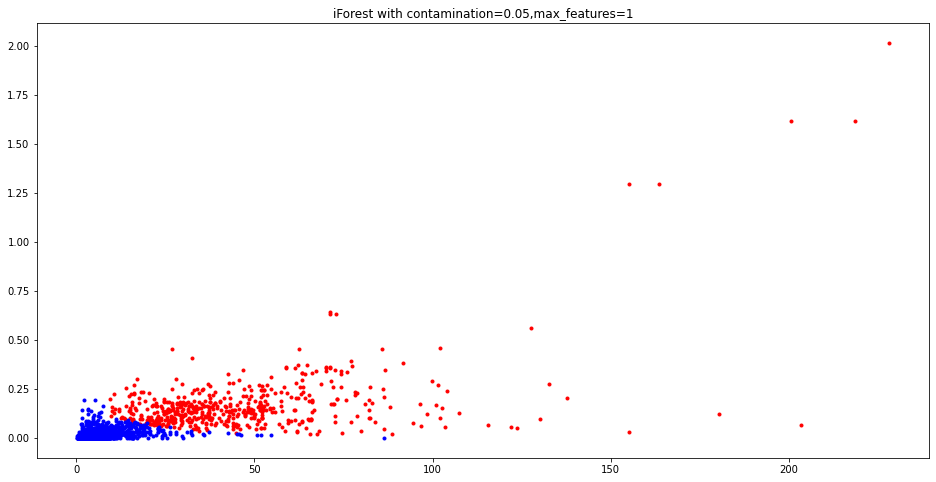

7
55
20
56
15
43
41
46
11


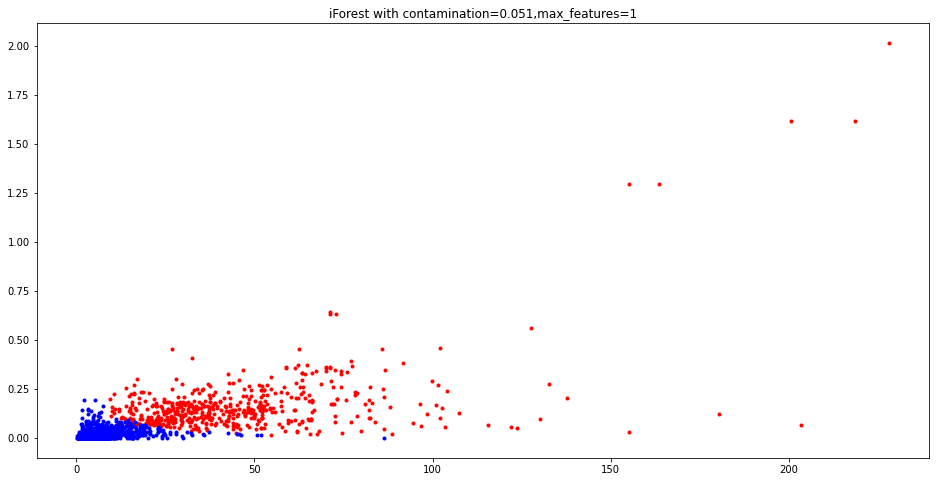

7
55
20
56
15
43
41
46
10


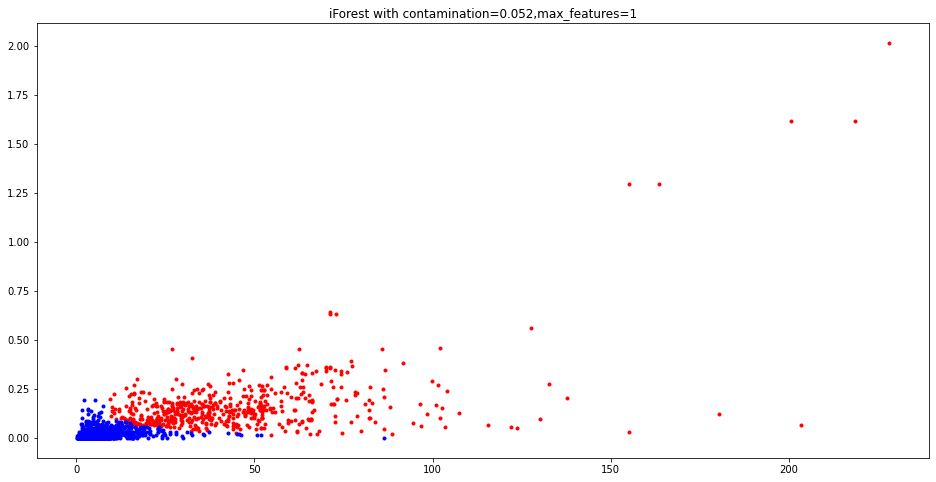

7
55
20
56
15
44
41
46
10


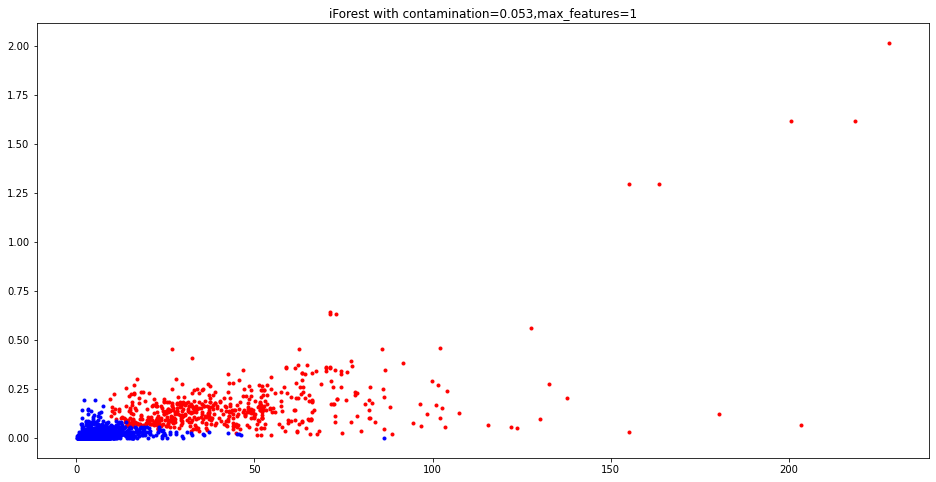

7
55
20
56
15
44
41
46
10


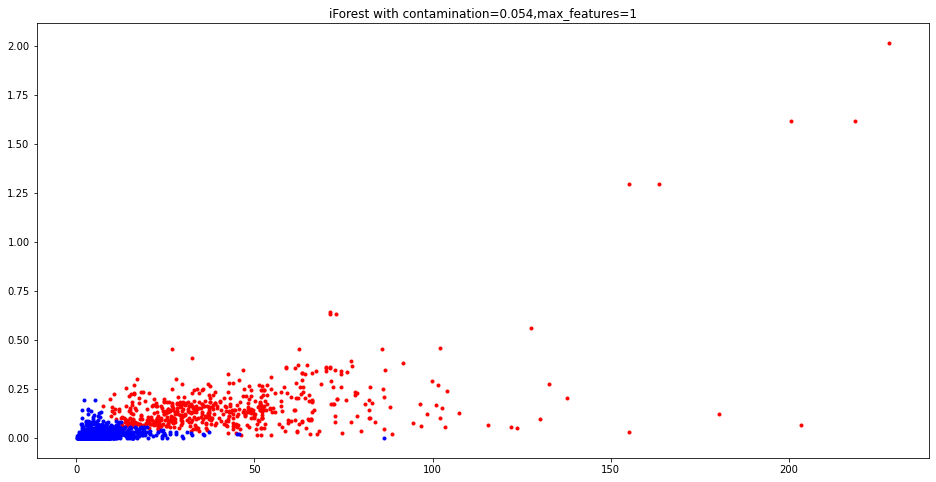

7
55
20
56
15
44
41
46
10


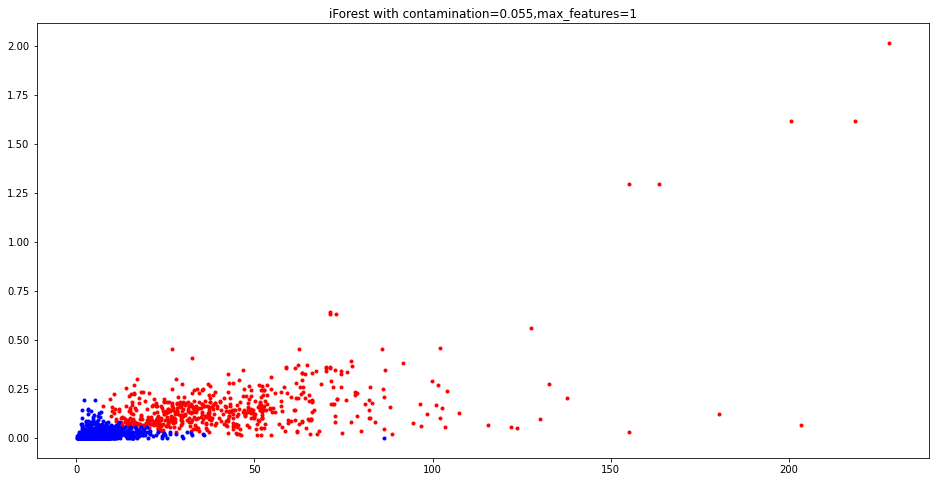

7
55
20
56
15
44
41
46
10


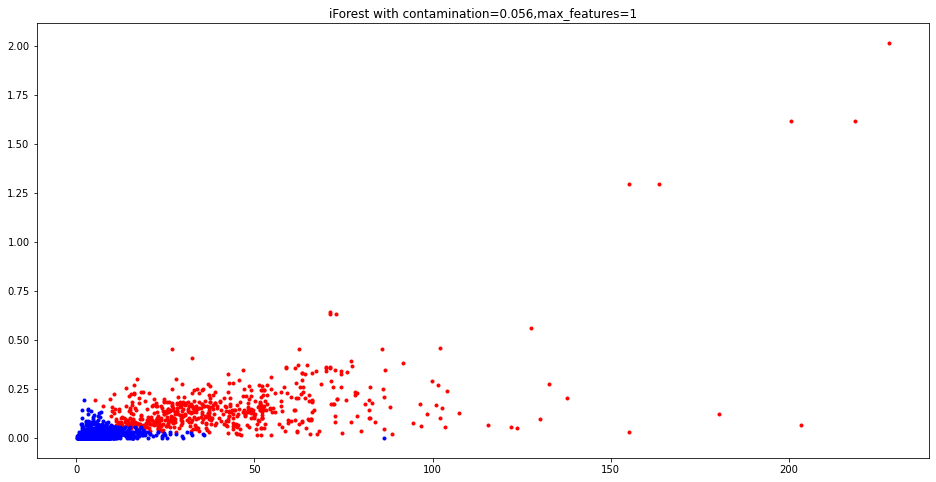

7
55
20
56
15
44
41
46
10


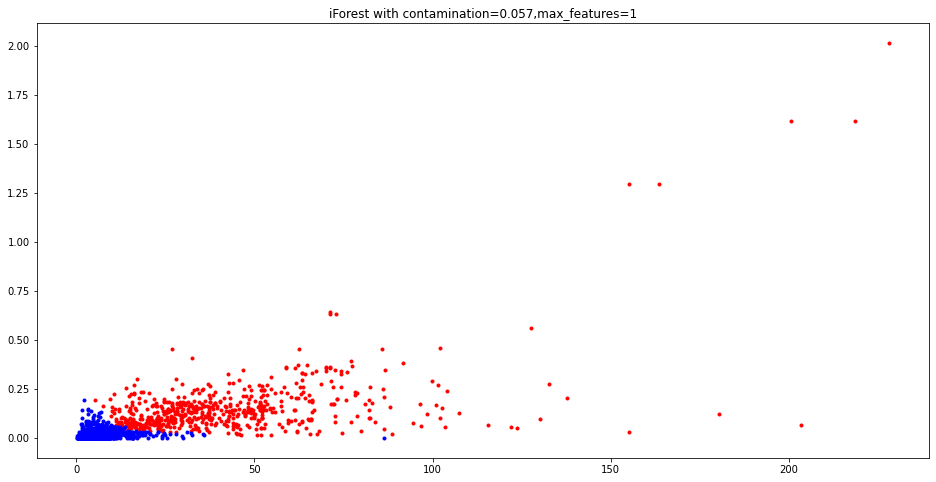

7
55
20
56
15
44
41
46
10


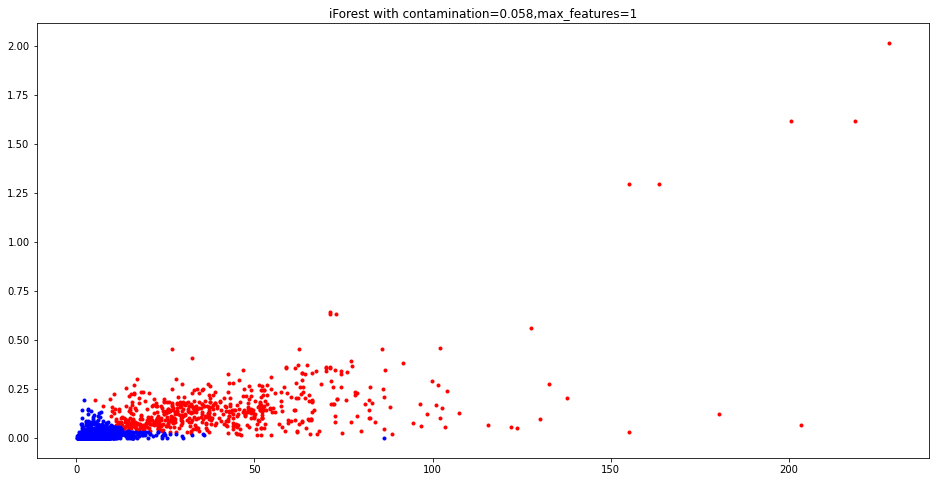

7
55
20
56
15
44
41
46
10


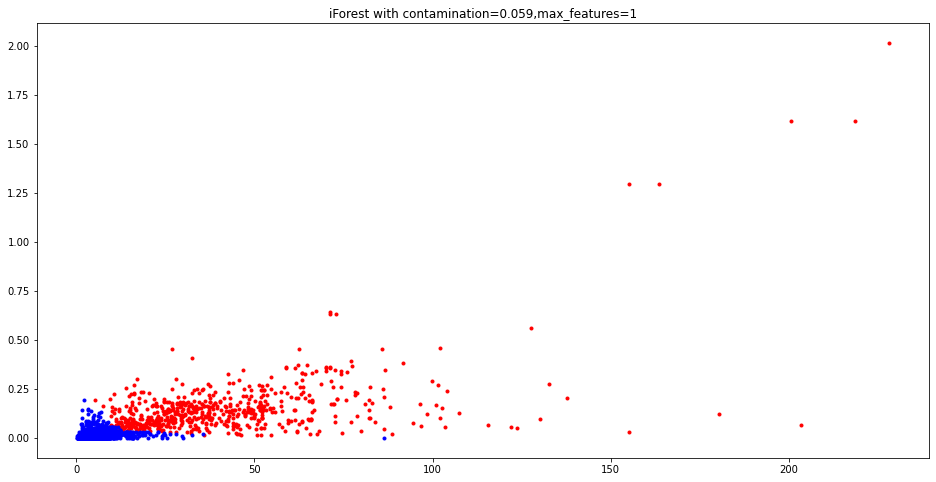

7
55
20
56
15
44
41
46
10


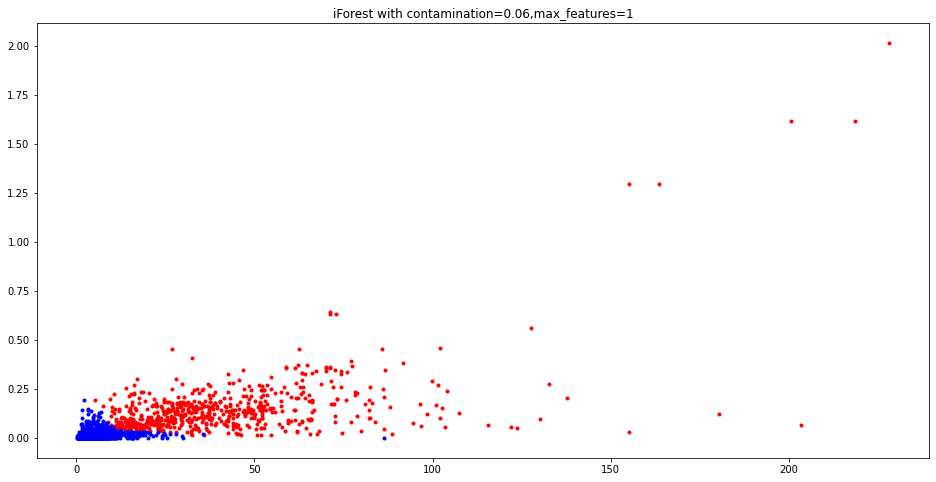

7
55
20
56
15
44
41
46
10


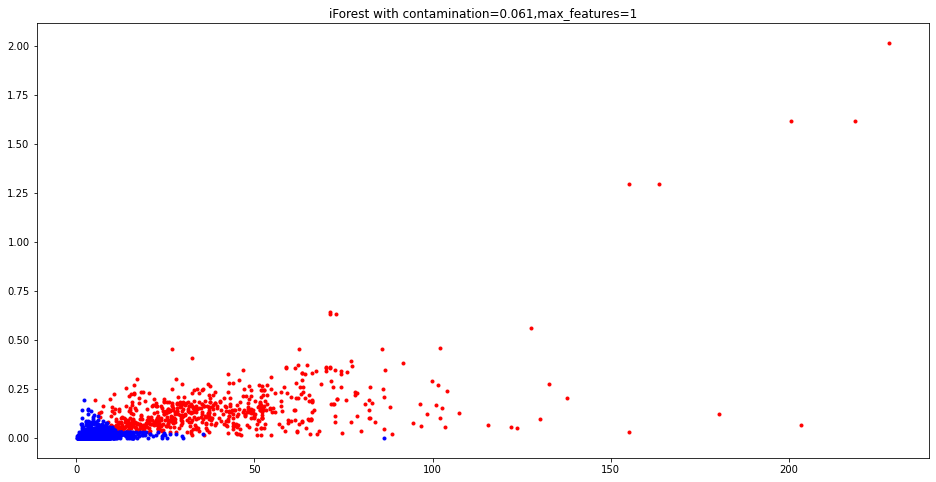

7
55
20
56
15
45
41
46
10


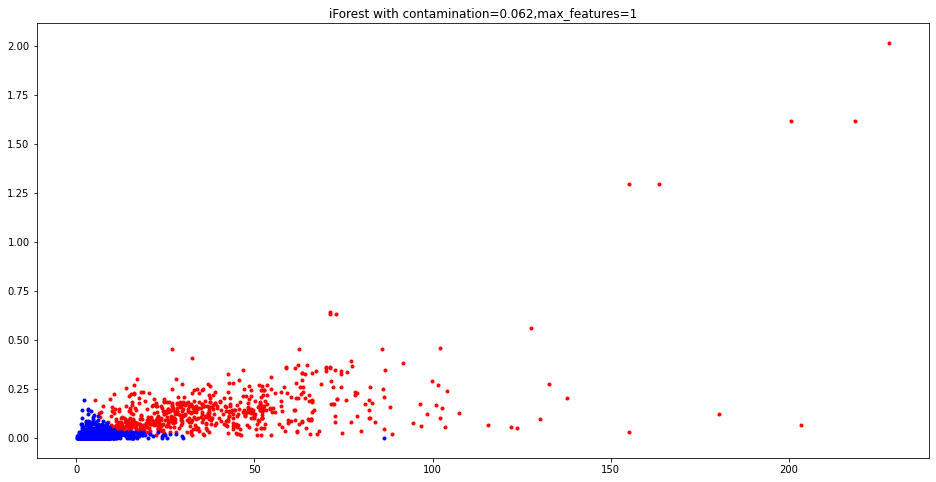

7
55
20
56
15
45
41
46
10


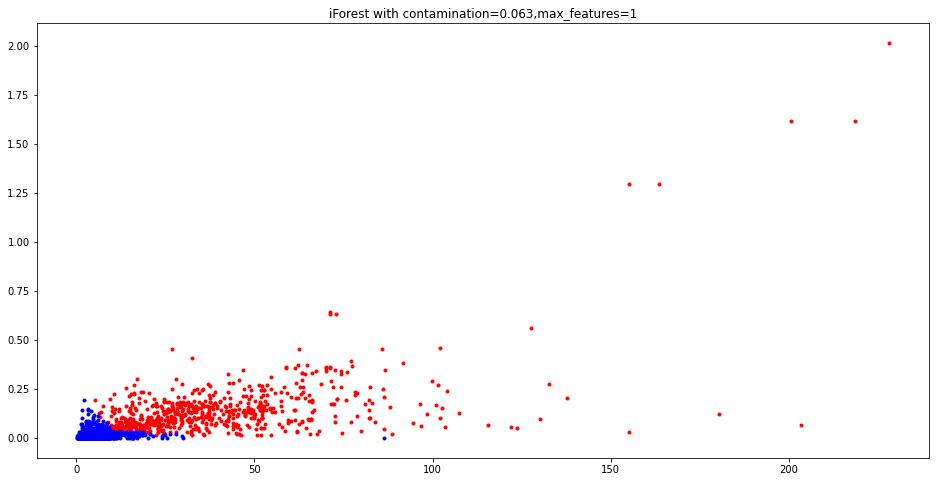

7
55
20
56
15
45
41
46
10


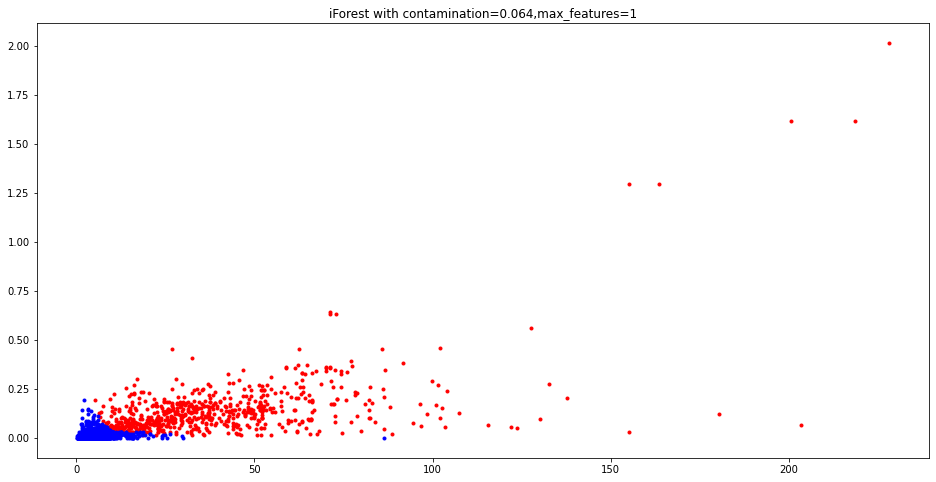

7
55
20
56
15
45
41
46
10


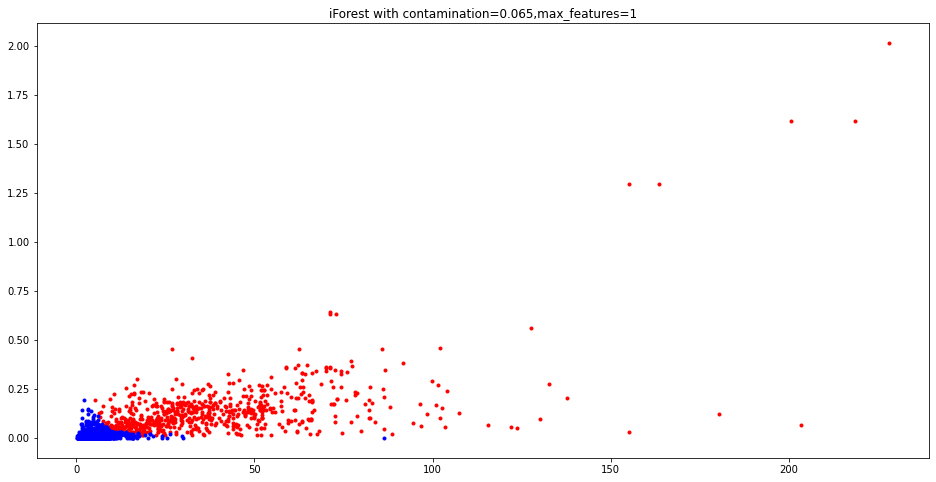

7
55
20
56
15
45
41
46
10


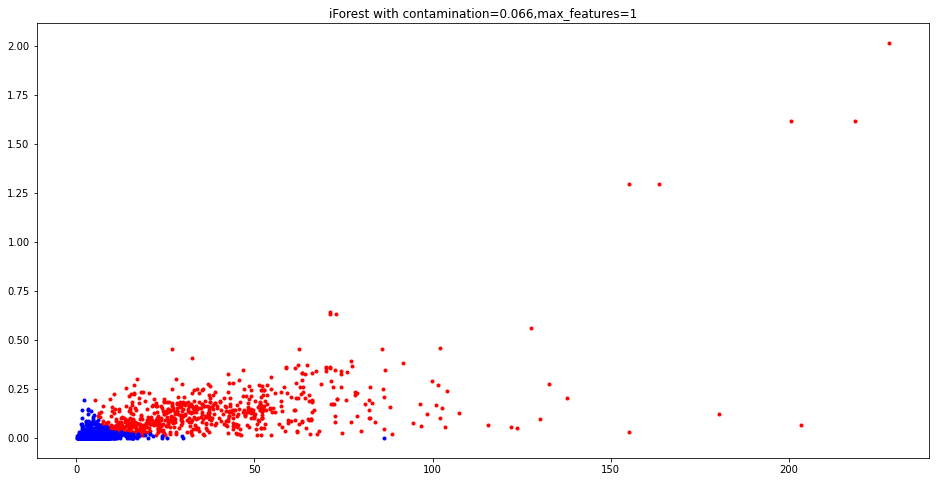

7
55
20
56
15
45
43
46
9


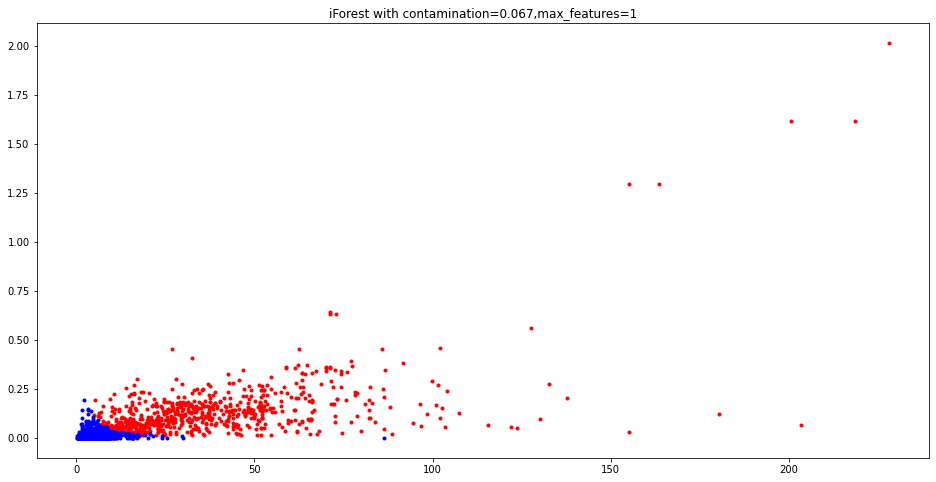

7
55
20
56
15
45
43
46
9


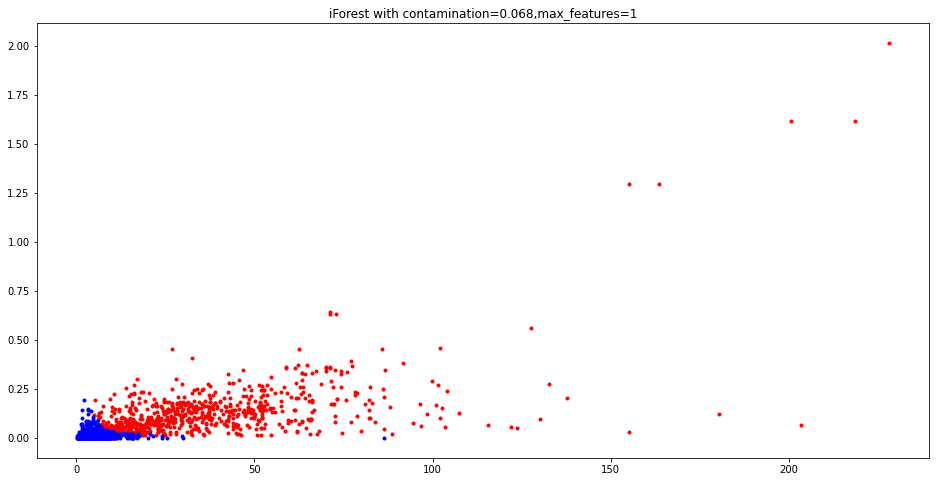

7
55
20
56
15
45
43
46
9


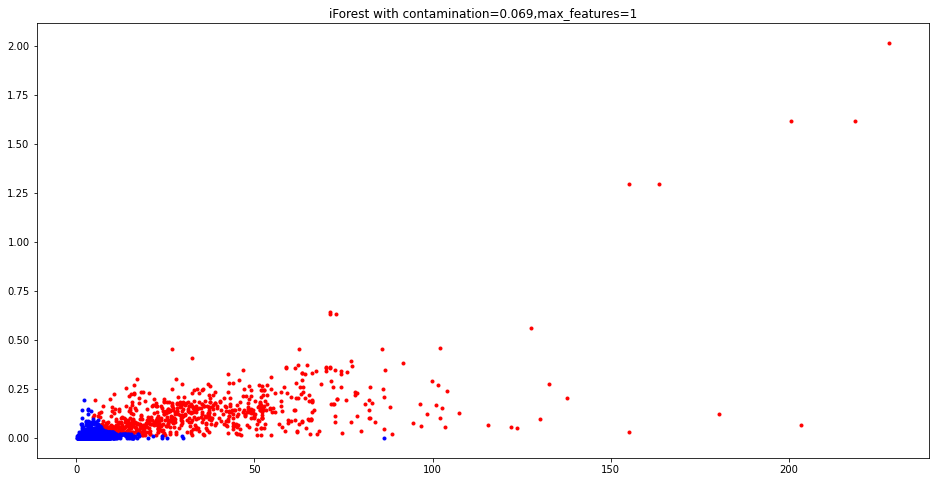

7
56
20
56
15
45
43
46
9


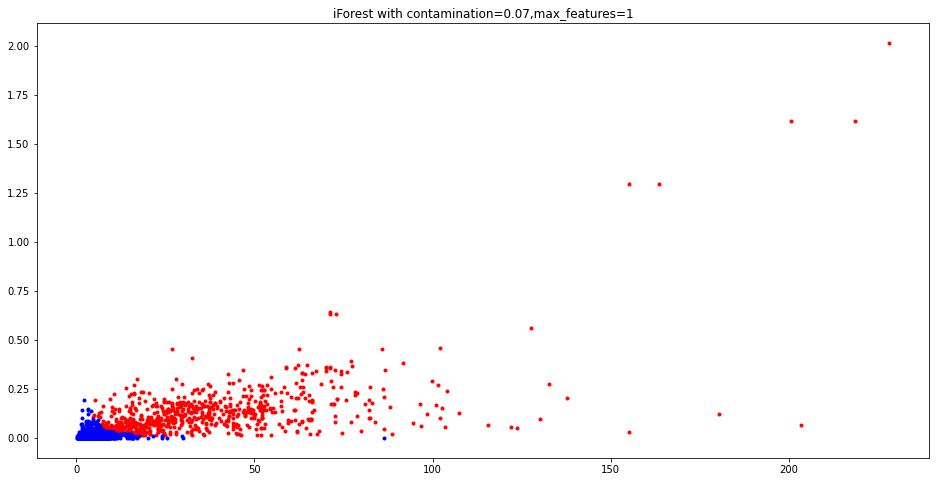

7
56
20
56
15
45
43
46
9


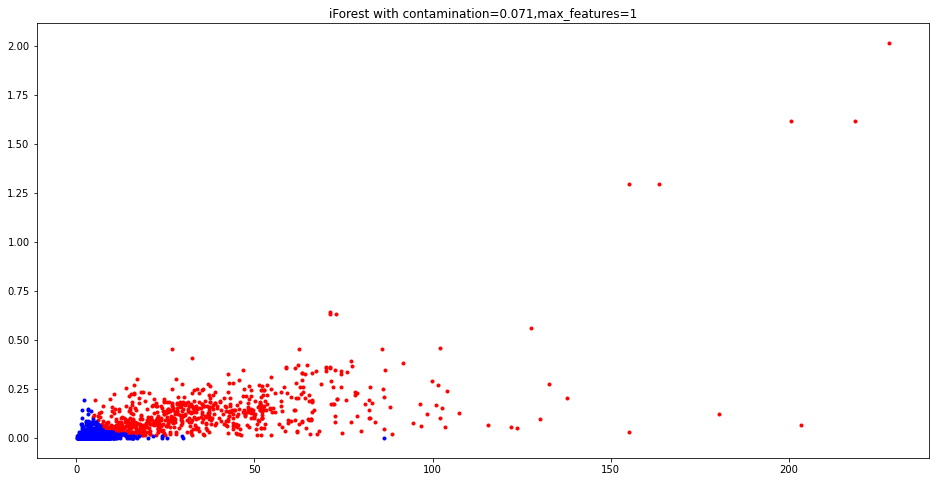

7
56
20
56
15
45
43
46
9


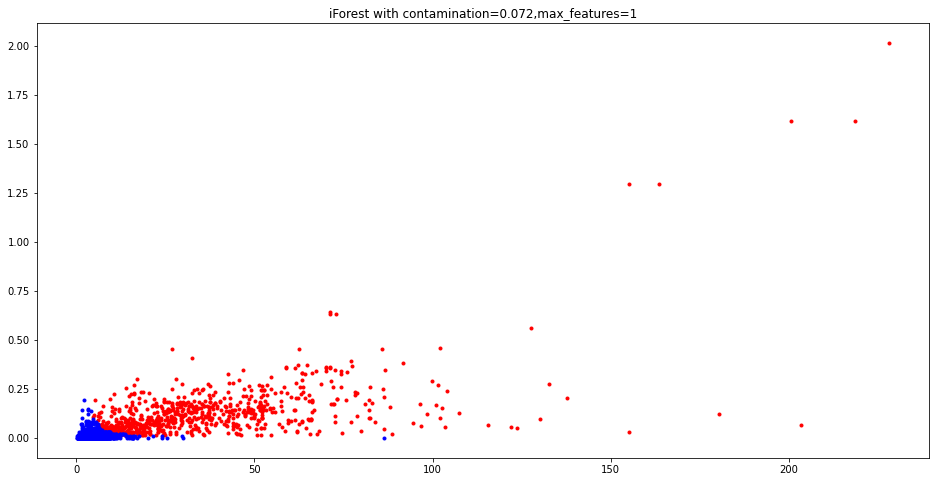

7
56
20
56
15
45
43
46
9


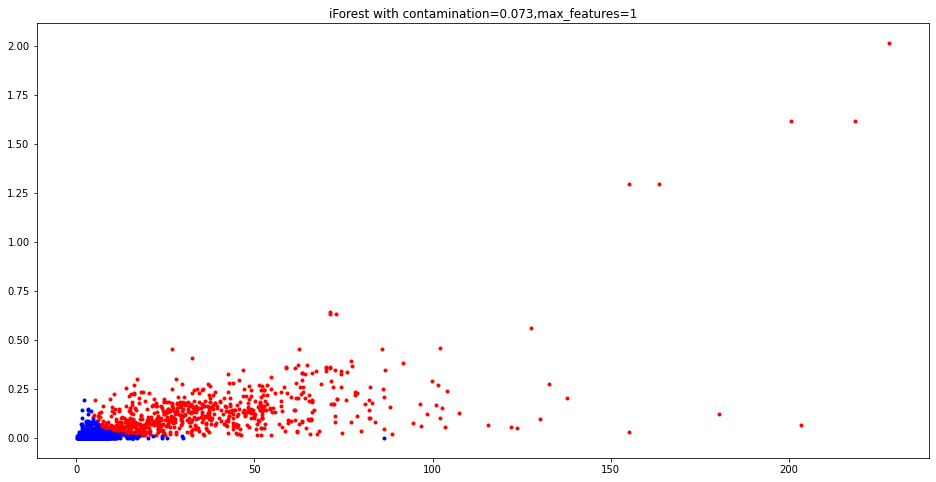

7
56
20
56
15
45
43
46
9


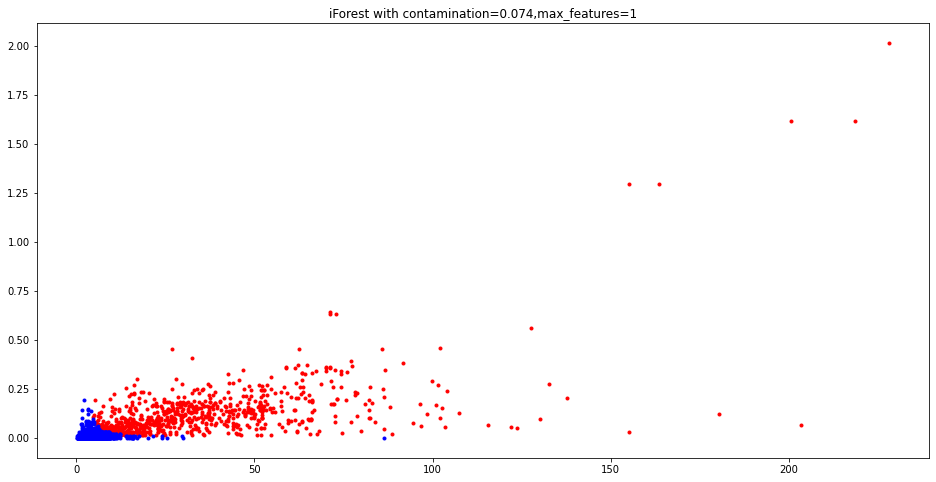

7
56
20
56
15
45
44
46
9


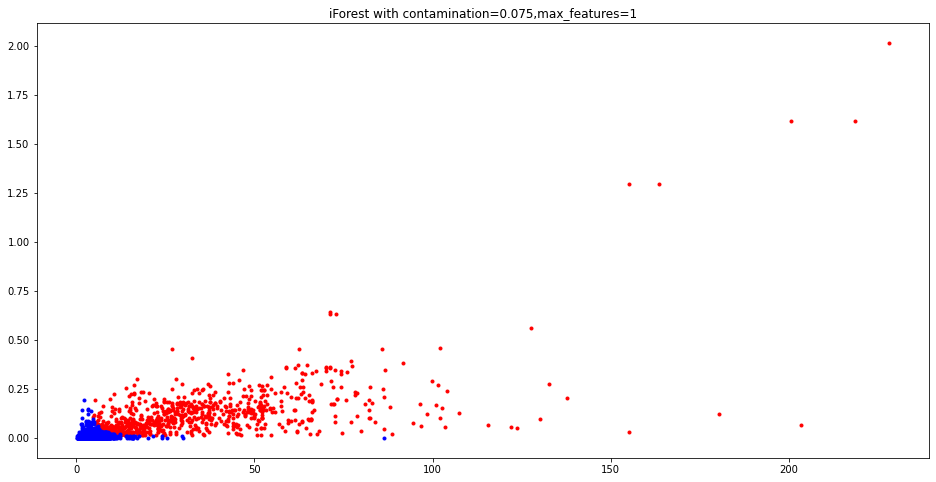

7
56
20
56
15
45
44
46
9


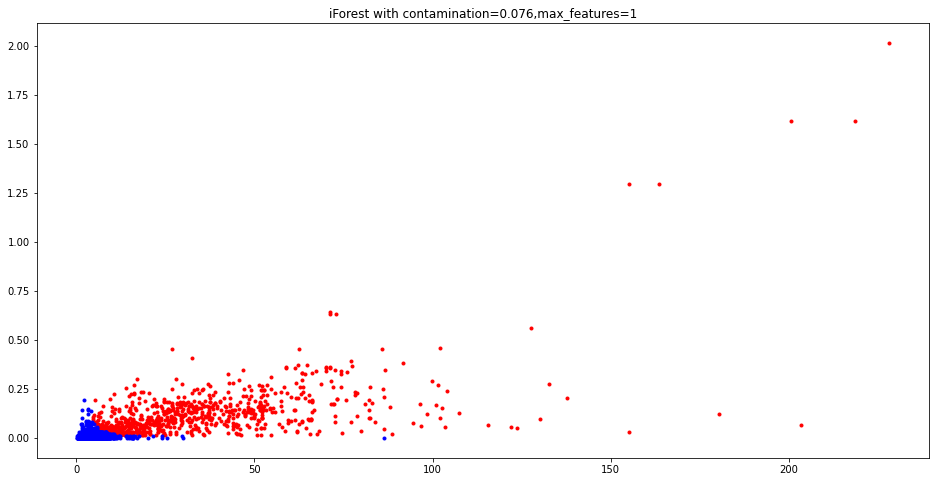

7
56
20
56
15
45
44
46
9


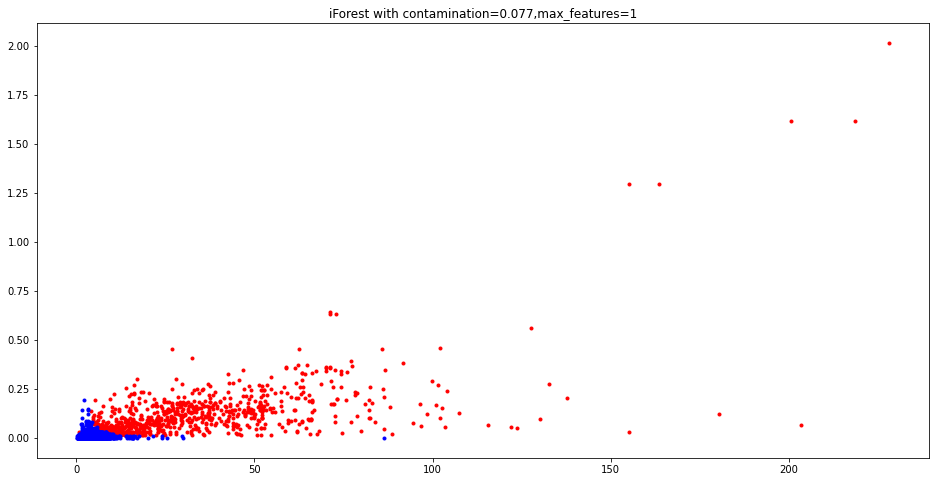

7
56
20
56
15
45
44
46
9


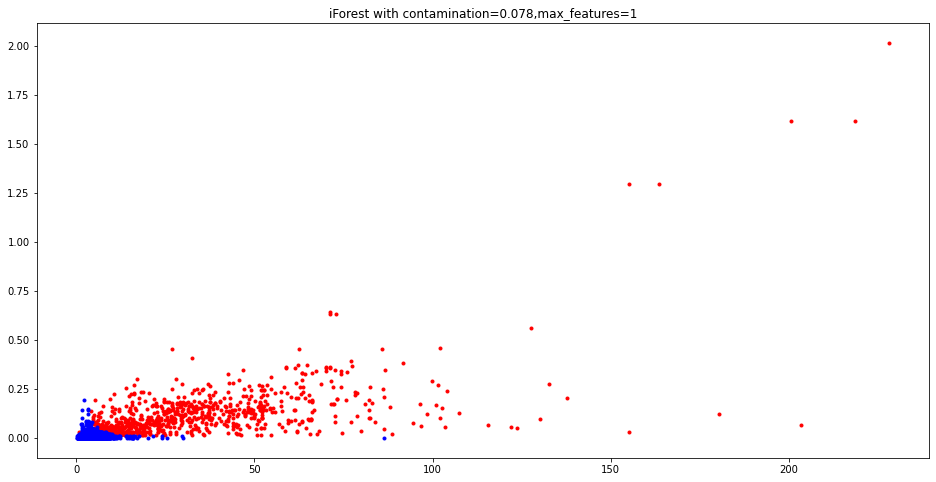

7
56
20
56
15
45
44
46
9


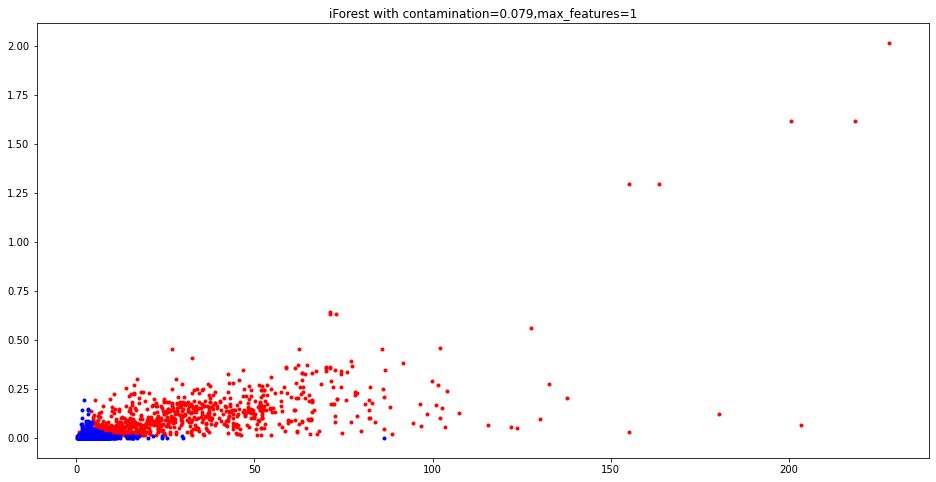

7
56
20
56
15
45
44
46
9


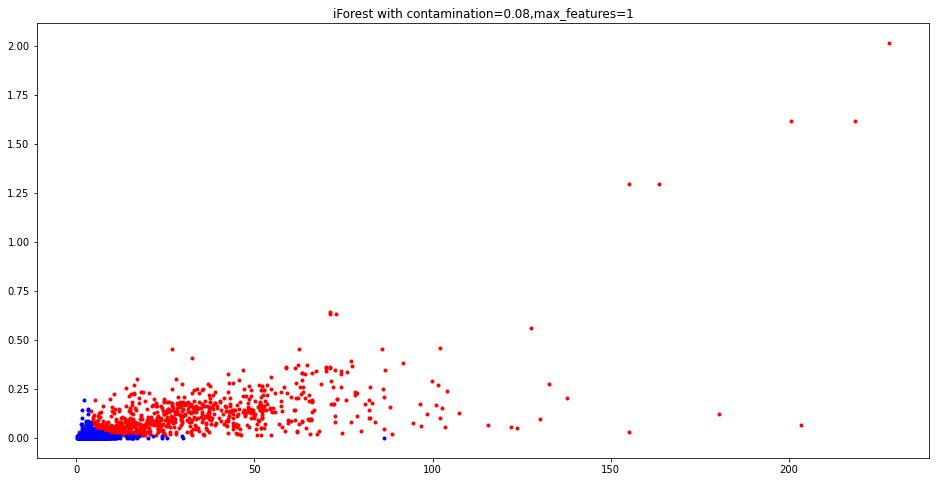

7
56
20
56
15
45
44
46
9


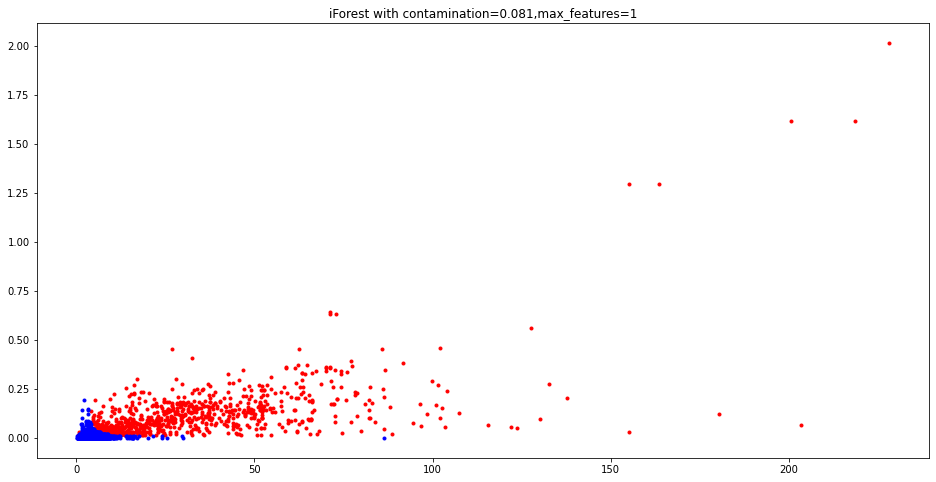

7
56
20
56
15
45
44
46
9


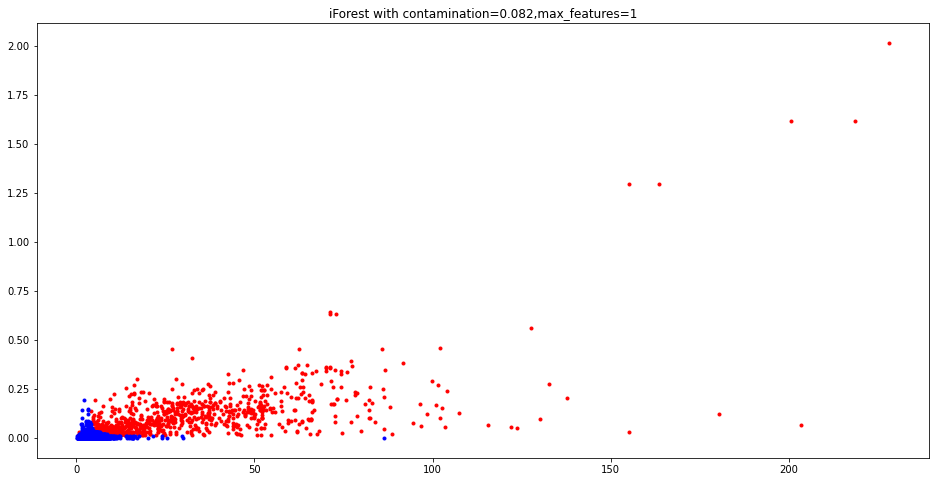

7
56
20
56
15
45
44
46
9


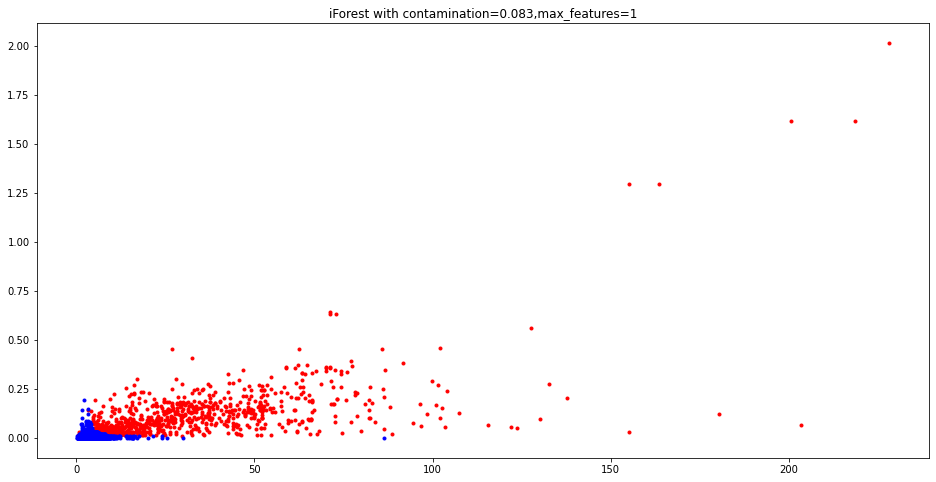

7
56
20
56
15
45
44
46
9


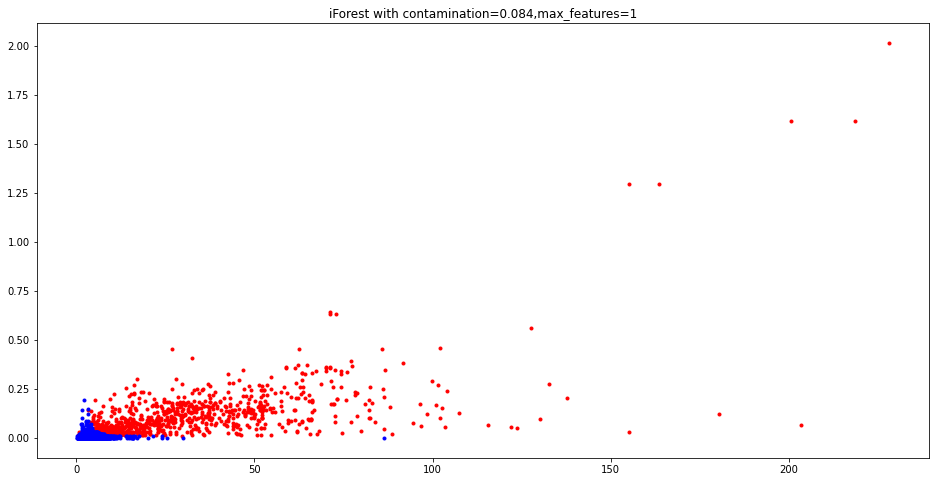

7
56
20
56
15
45
44
46
9


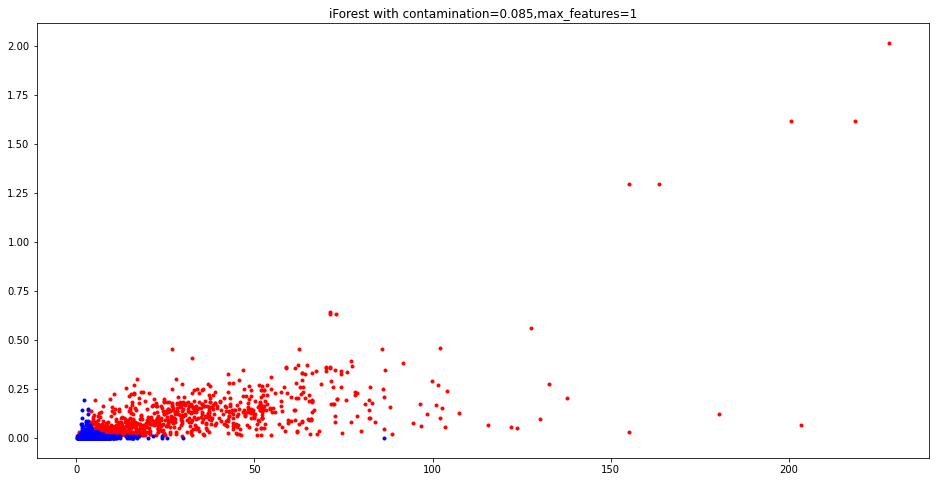

7
56
20
56
15
45
44
46
9


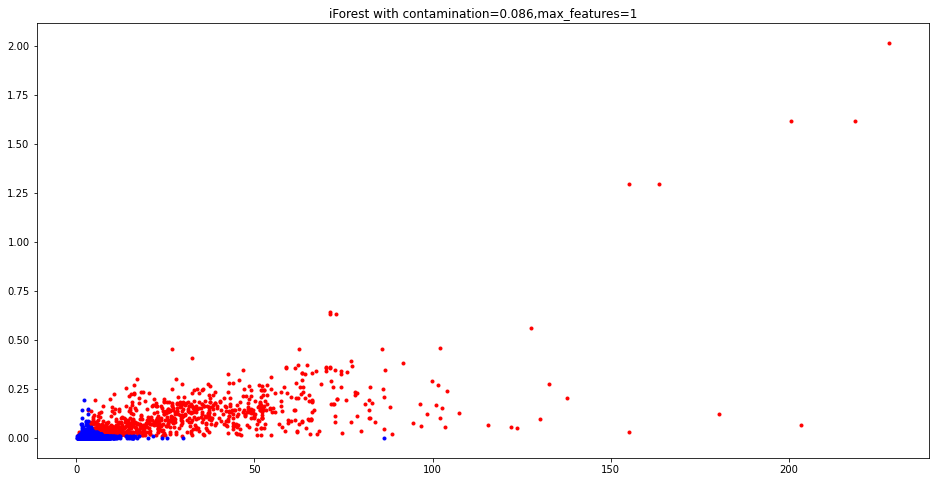

7
56
20
56
15
45
44
46
9


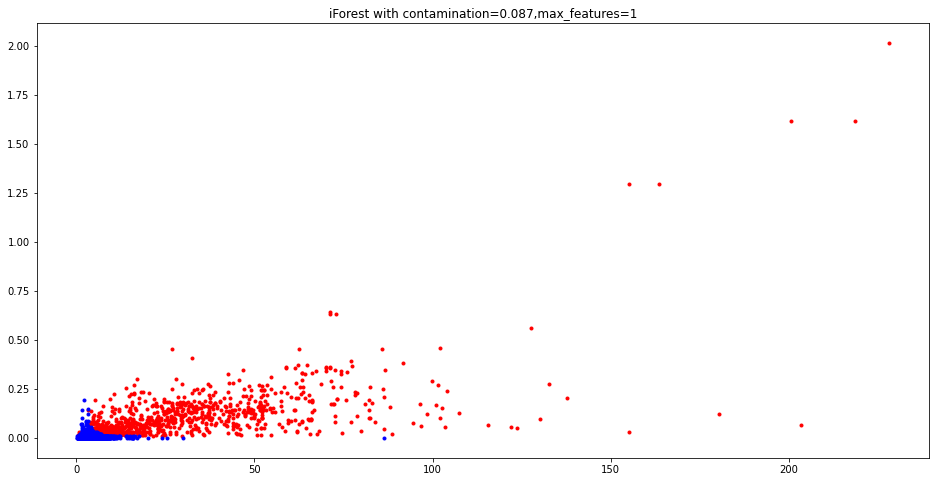

7
56
20
56
15
45
44
46
9


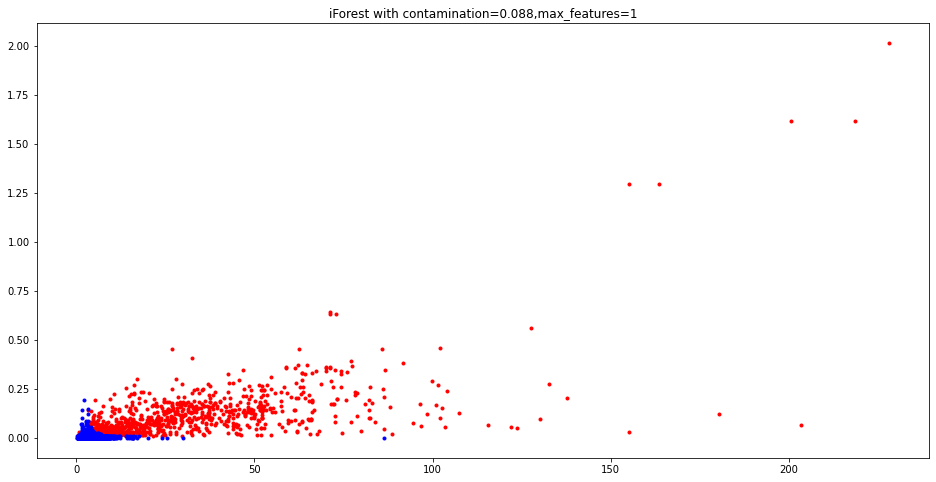

7
56
20
56
15
45
44
46
9


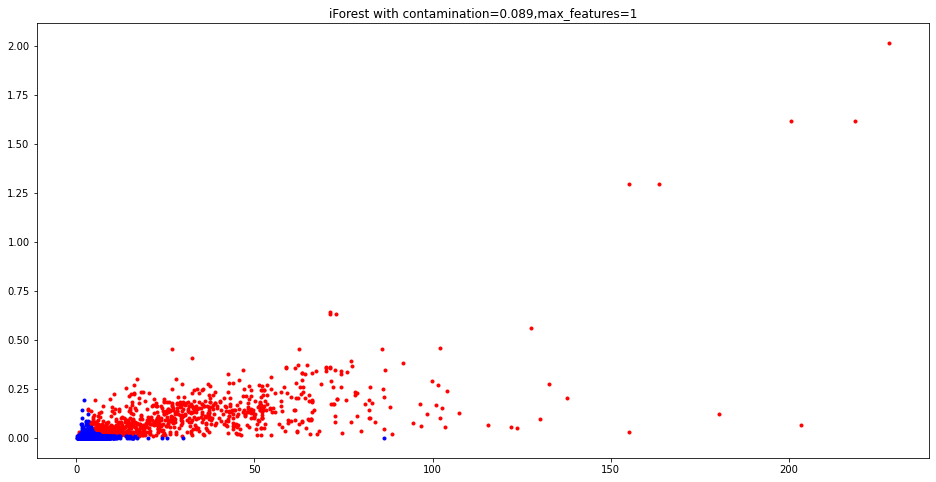

7
56
18
56
14
45
45
46
9


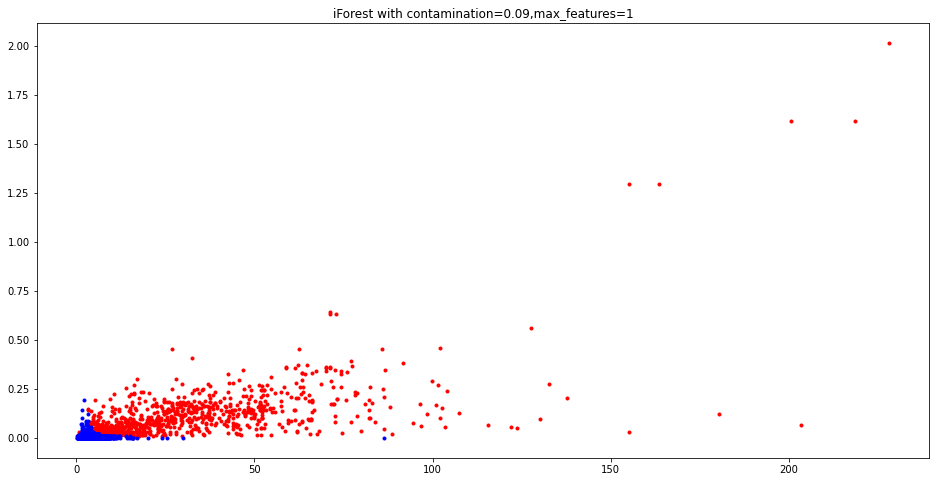

7
56
18
56
14
45
45
46
9


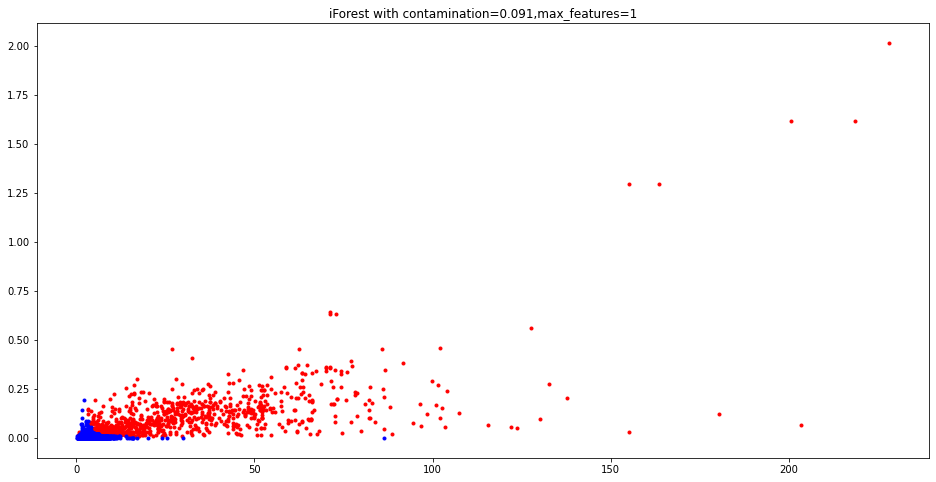

7
56
17
56
14
45
45
46
9


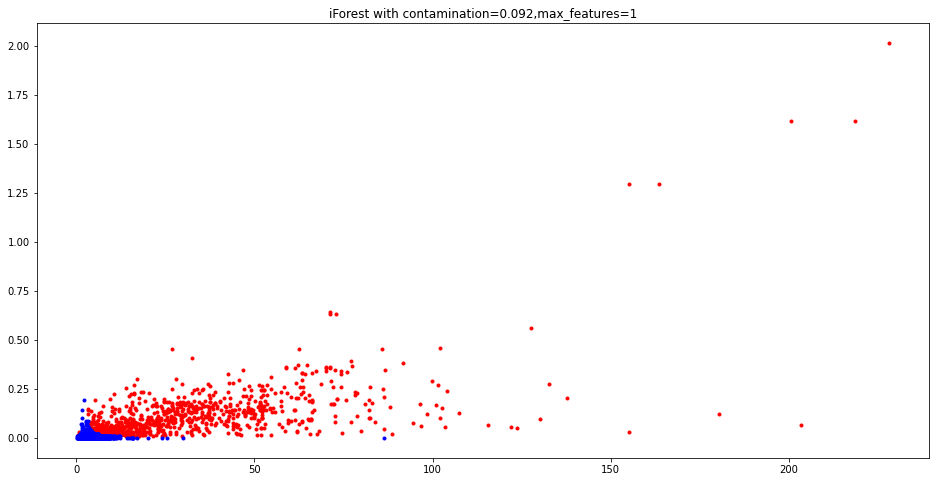

7
56
17
56
14
45
45
47
9


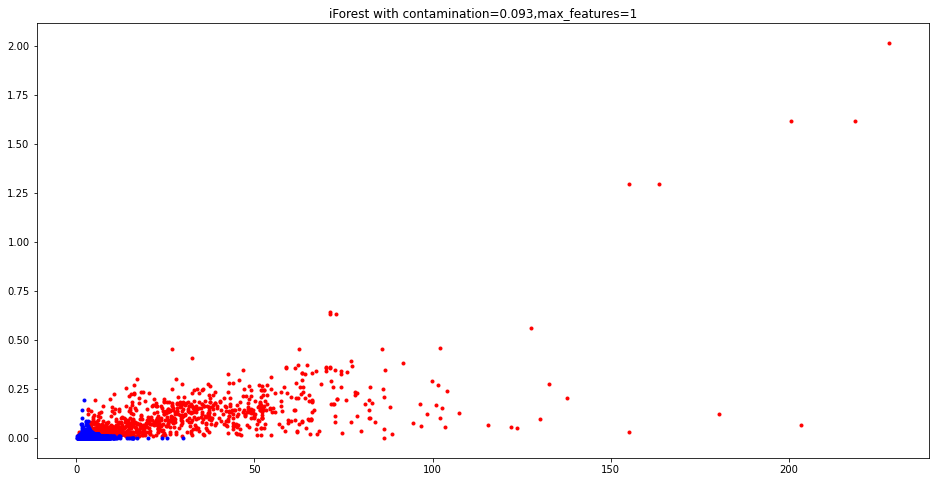

7
56
14
56
14
45
45
47
9


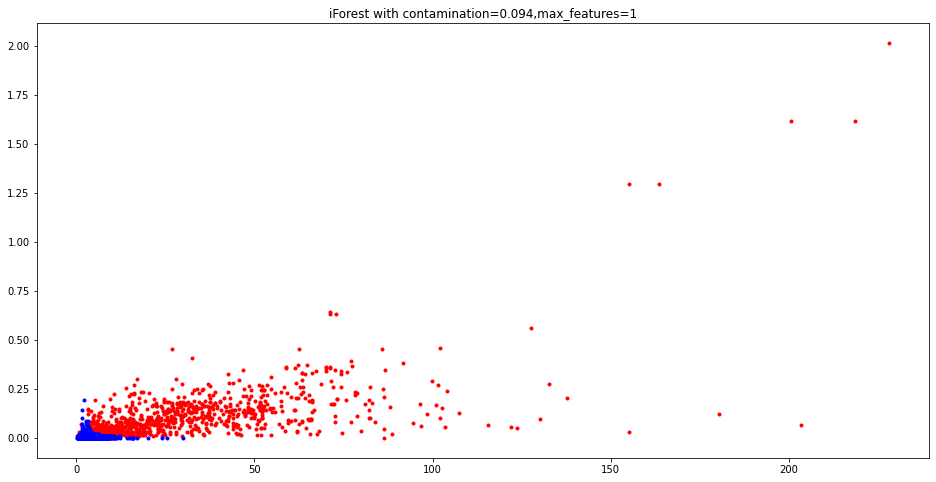

7
56
14
56
14
45
45
47
9


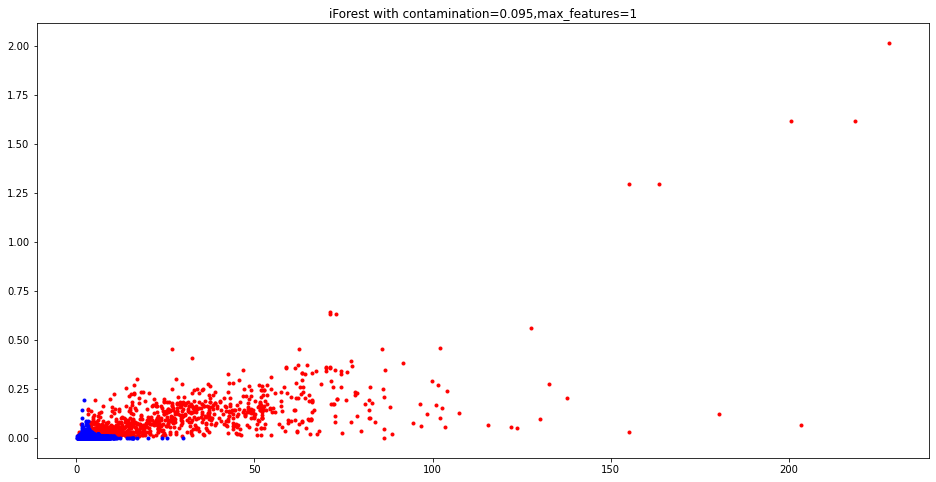

7
56
14
56
14
45
45
47
9


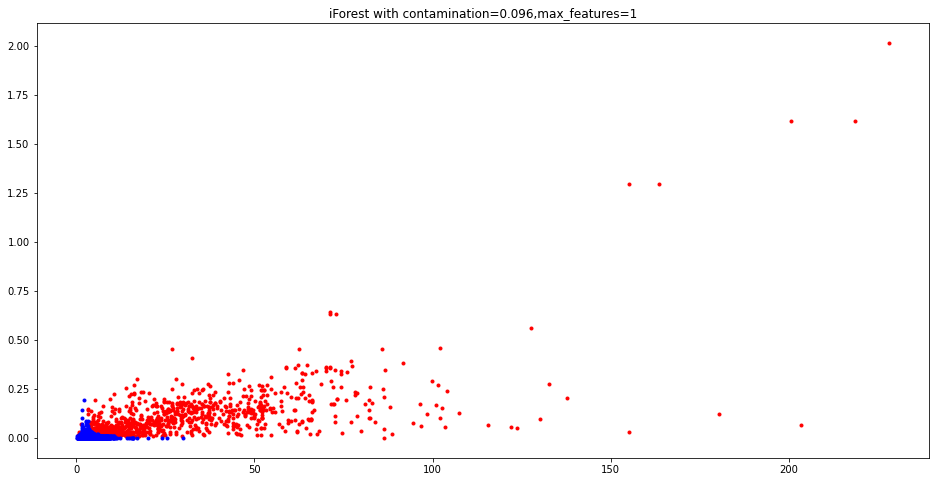

7
56
14
56
14
45
45
47
9


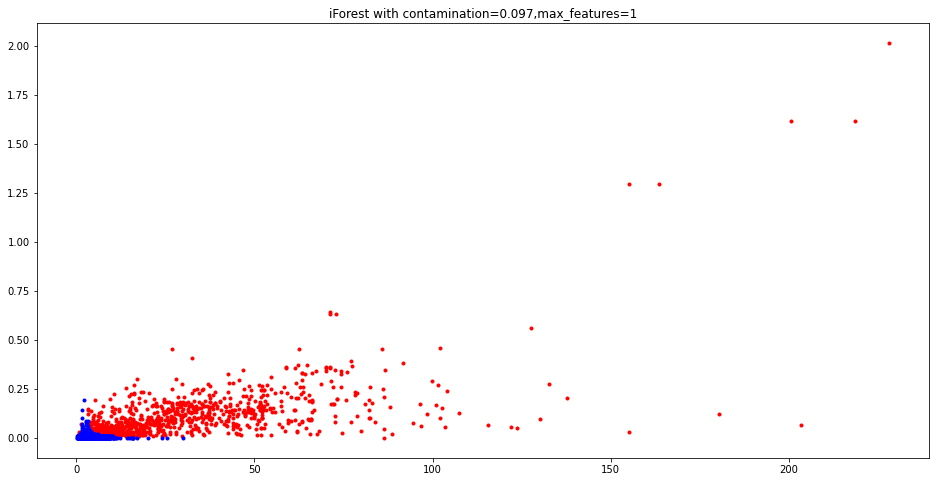

7
56
14
56
14
45
45
47
9


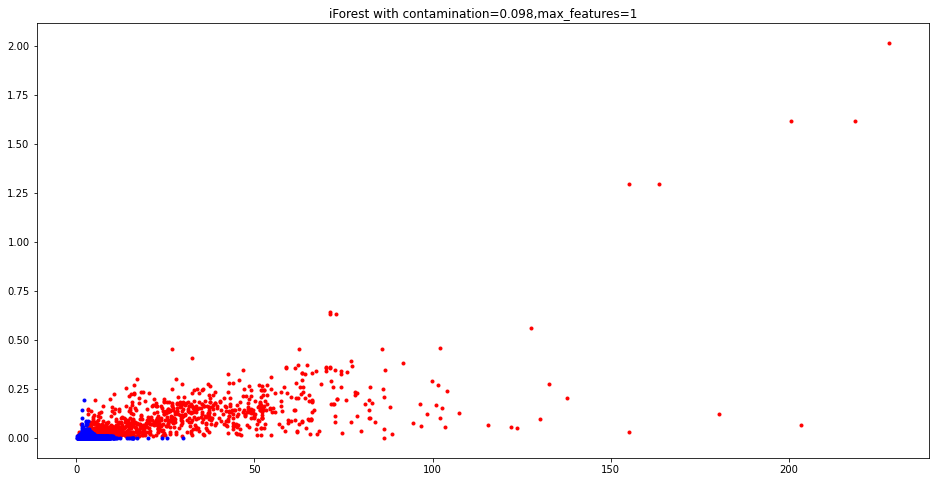

7
56
14
56
14
45
45
47
9


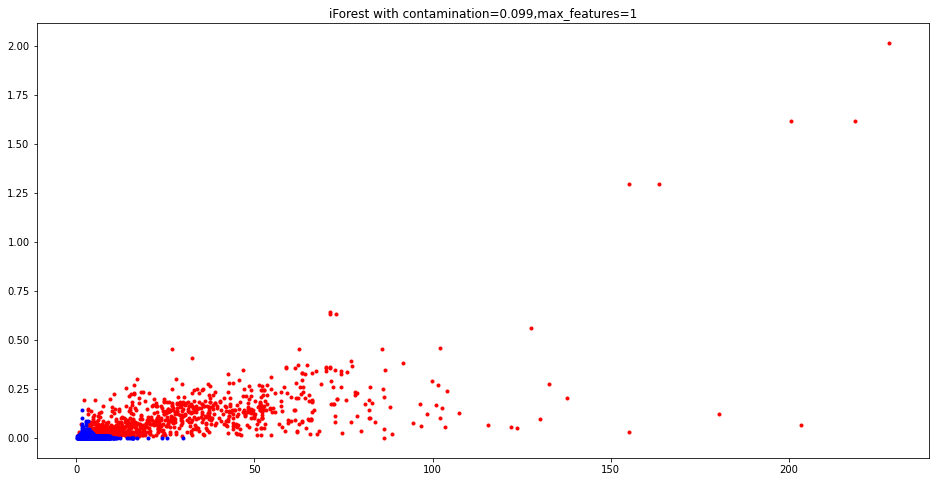

7
56
13
56
13
45
45
47
9


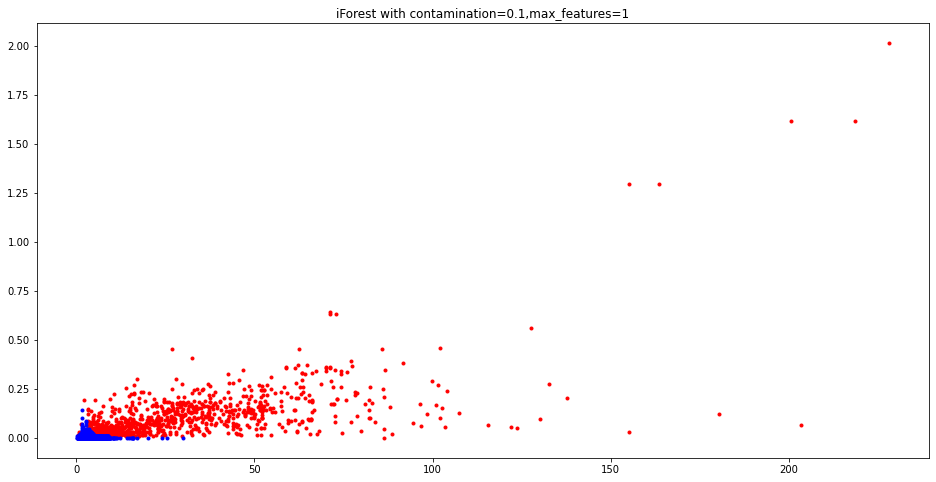

7
56
13
56
13
45
45
47
9


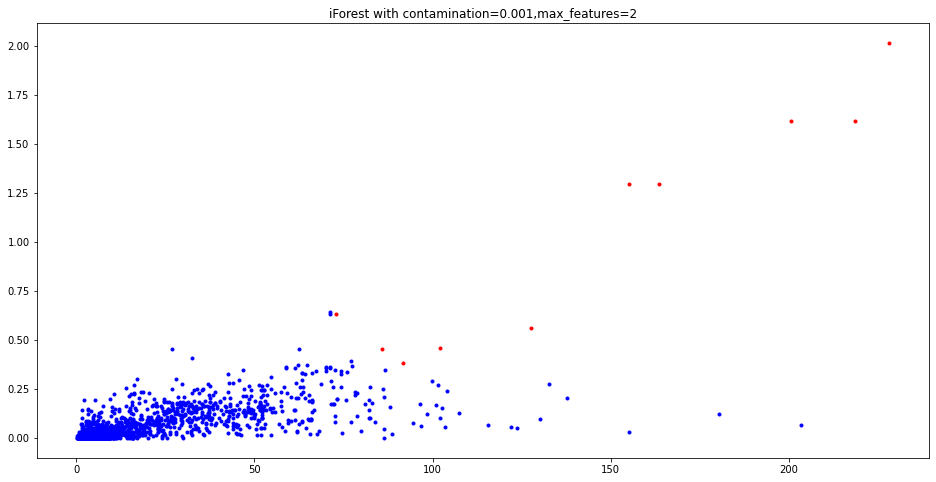

29
24
25
46
32
17
27
20
37


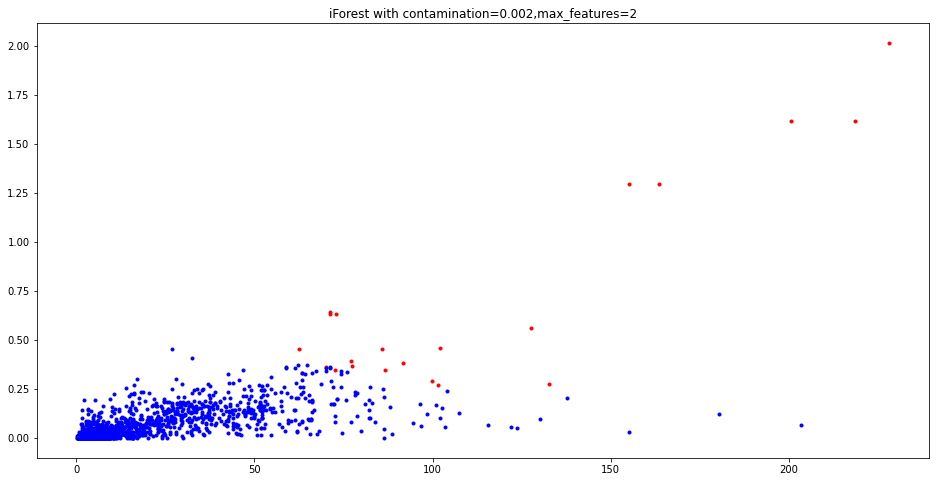

25
34
22
55
28
21
31
22
33


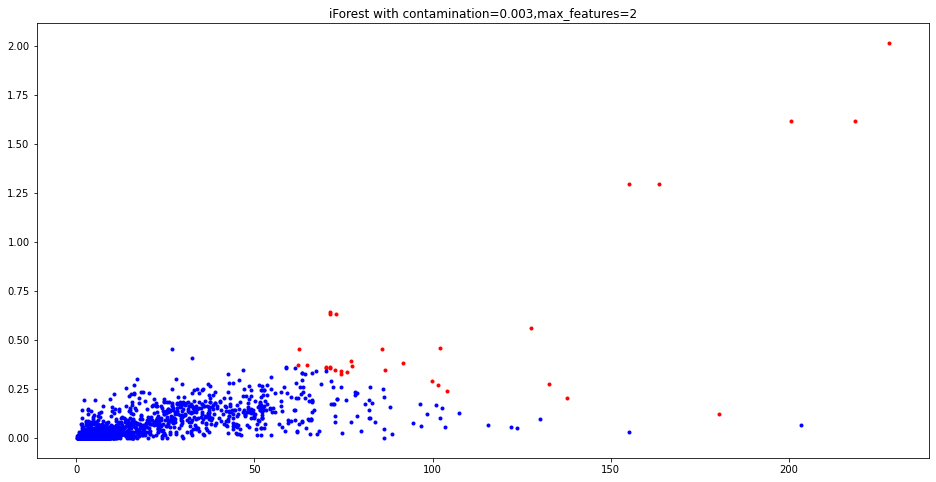

20
38
21
55
24
24
37
26
31


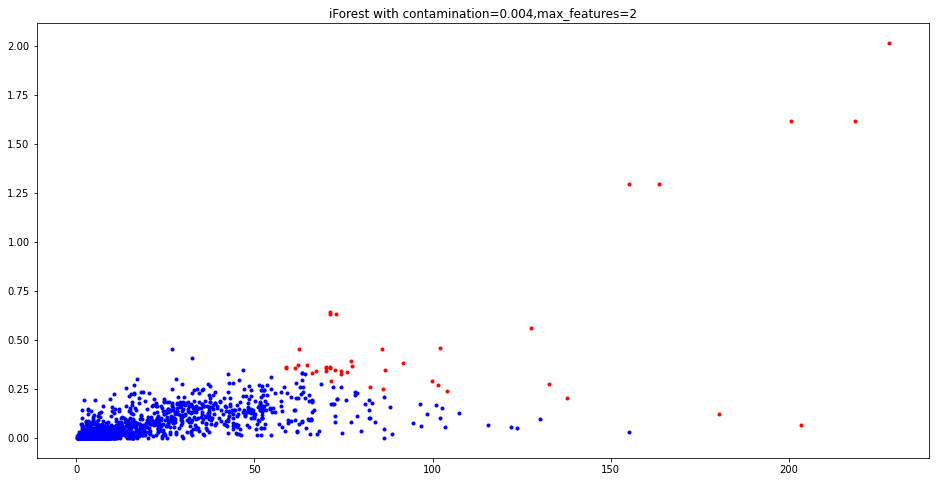

19
40
20
56
19
30
37
37
29


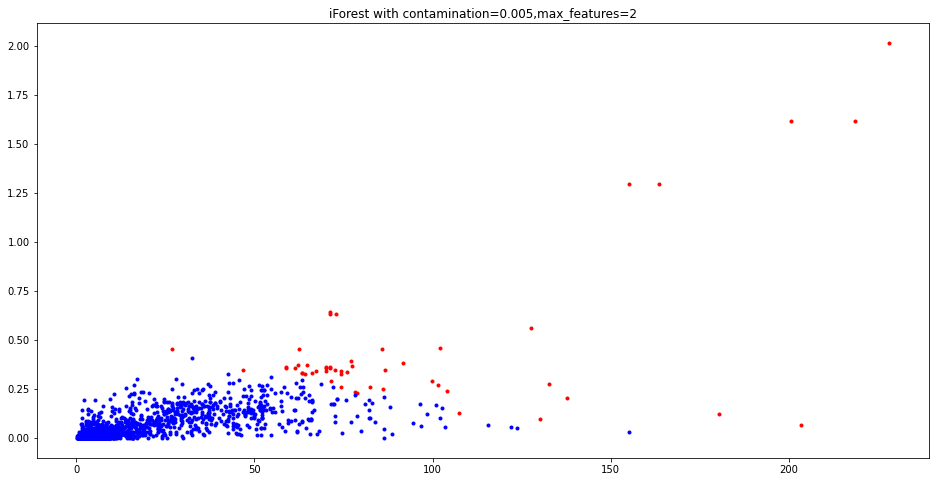

19
41
18
56
19
30
38
41
29


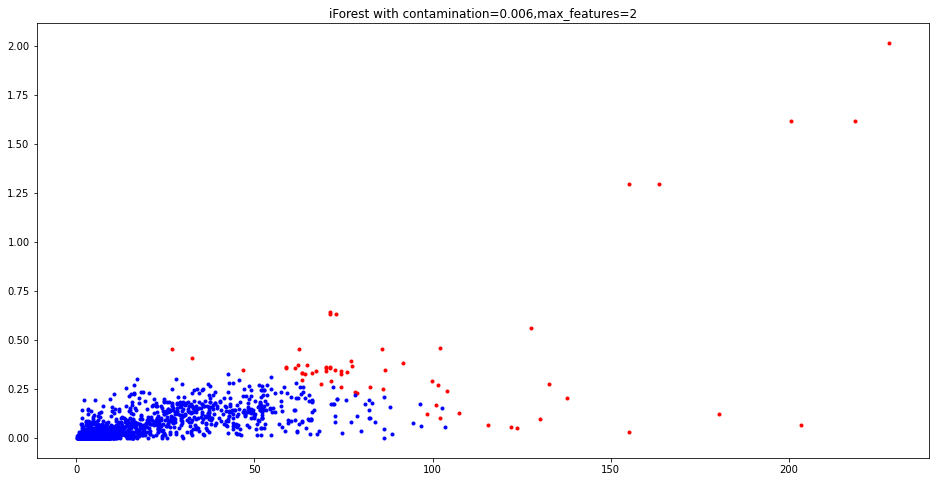

19
43
17
56
18
32
38
42
28


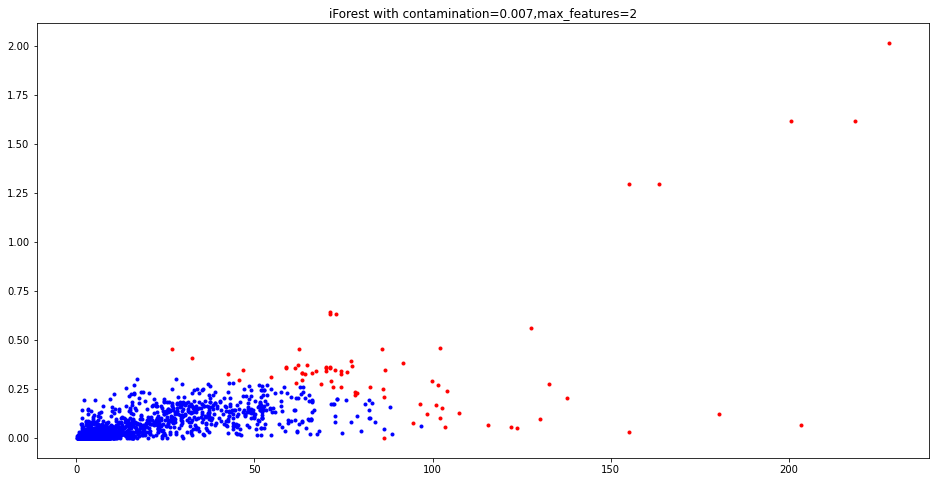

18
45
14
56
18
32
38
45
26


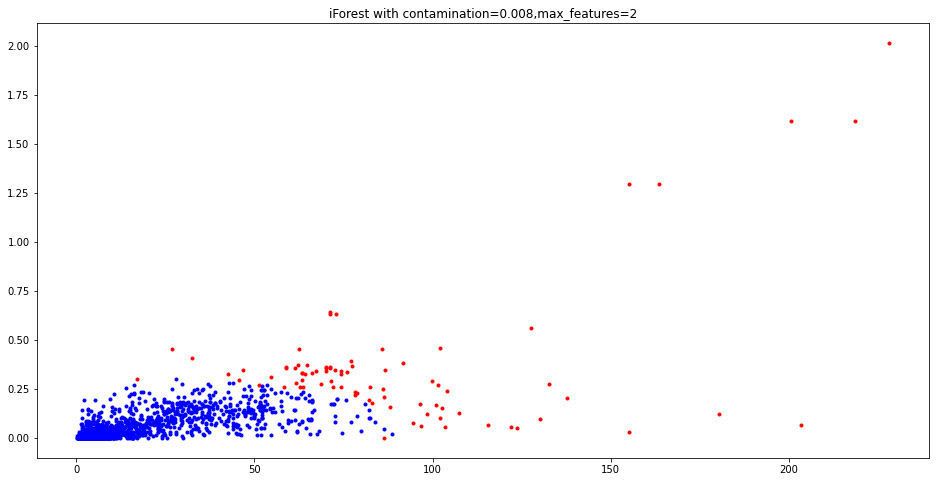

18
47
14
56
16
32
38
45
25


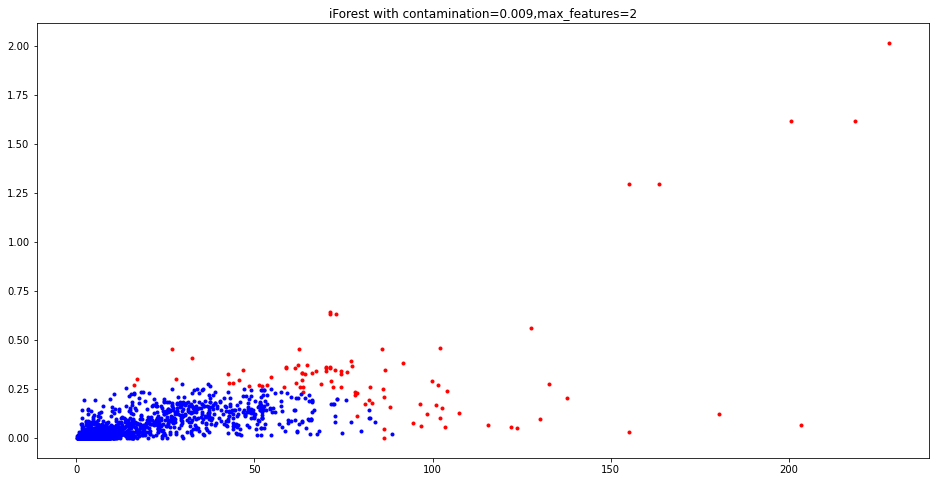

18
47
13
56
15
33
38
45
24


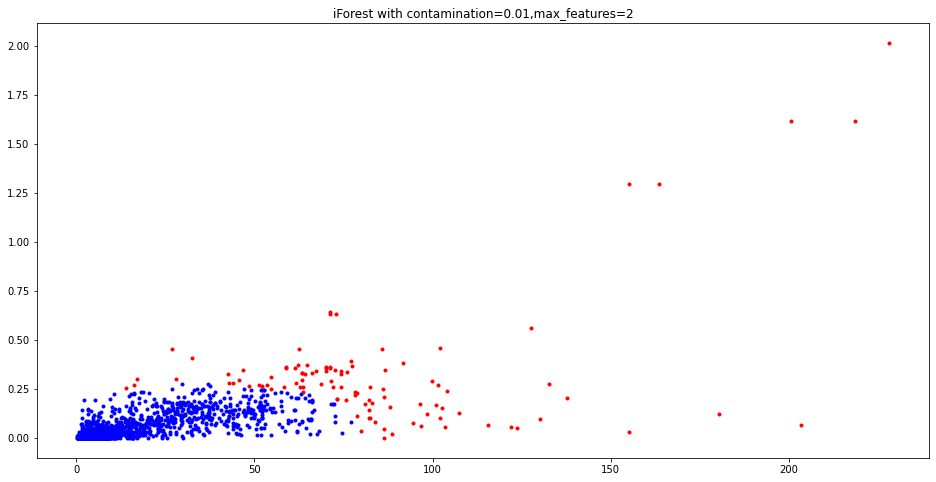

18
47
13
56
15
34
38
45
23


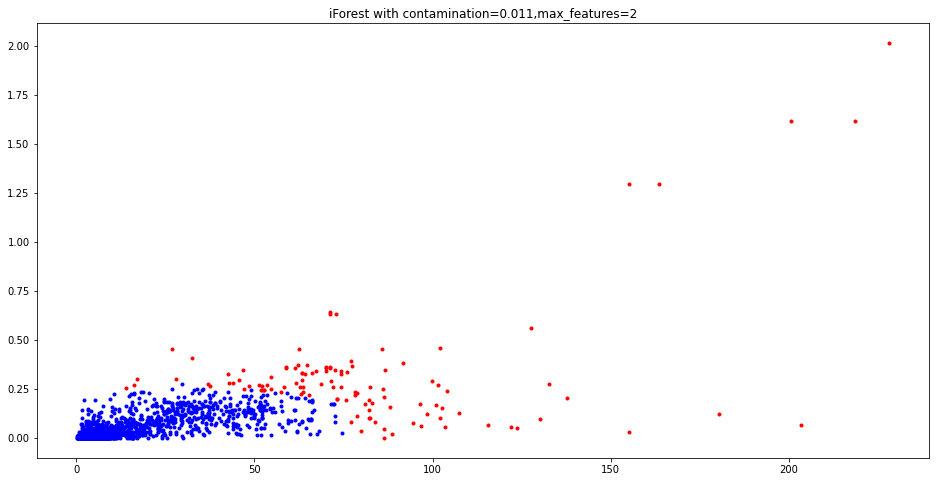

18
47
12
56
15
34
38
46
23


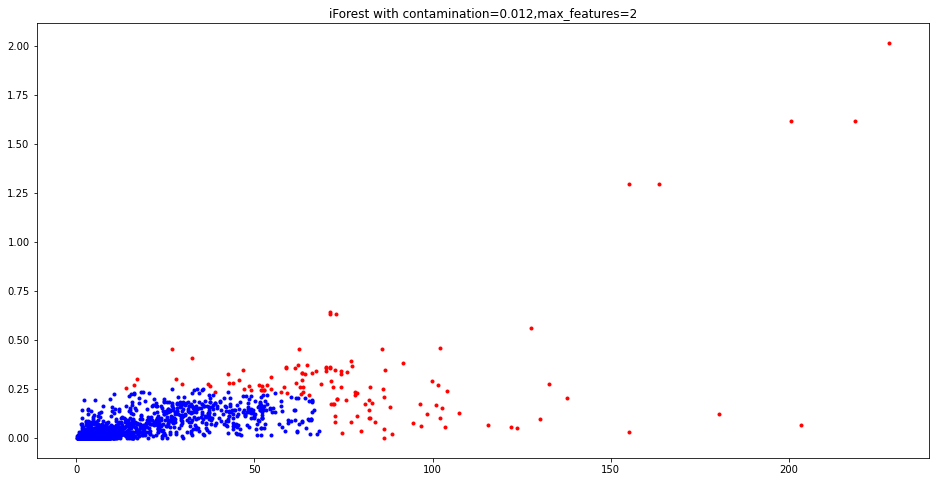

18
47
12
56
15
34
39
46
19


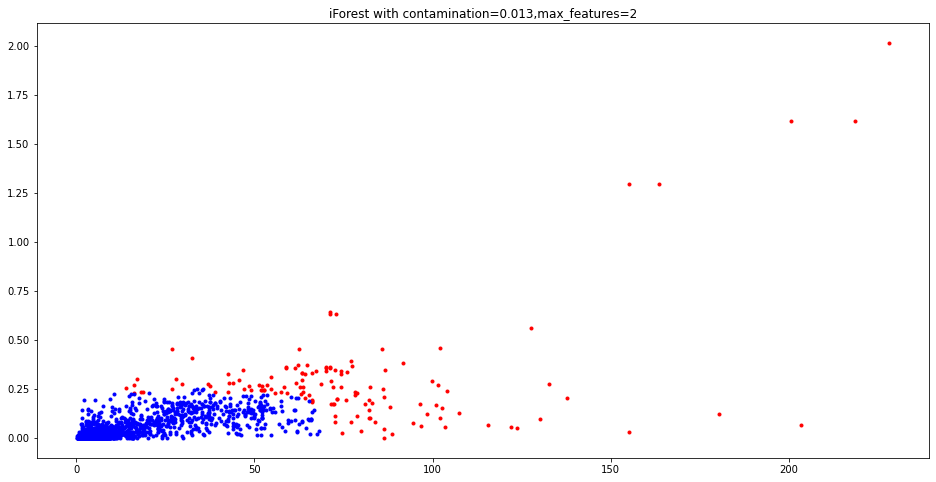

18
47
11
56
15
34
39
46
19


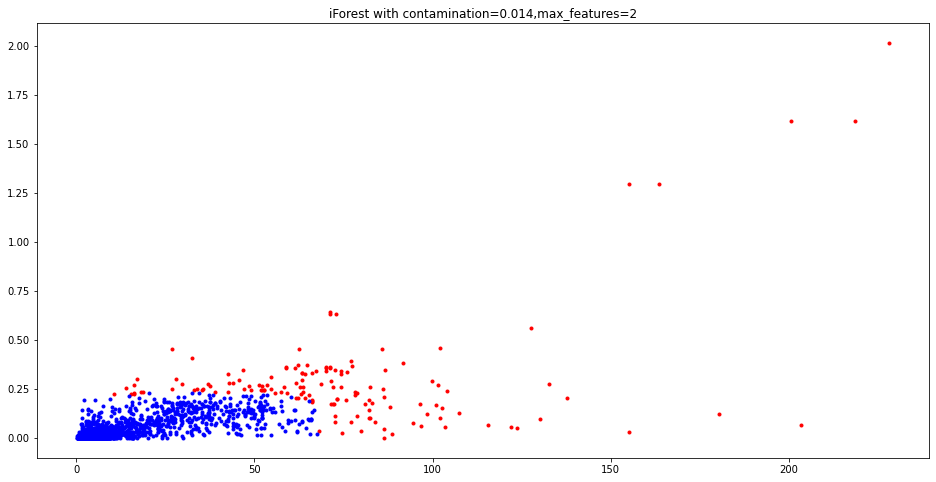

17
47
10
56
15
34
40
47
19


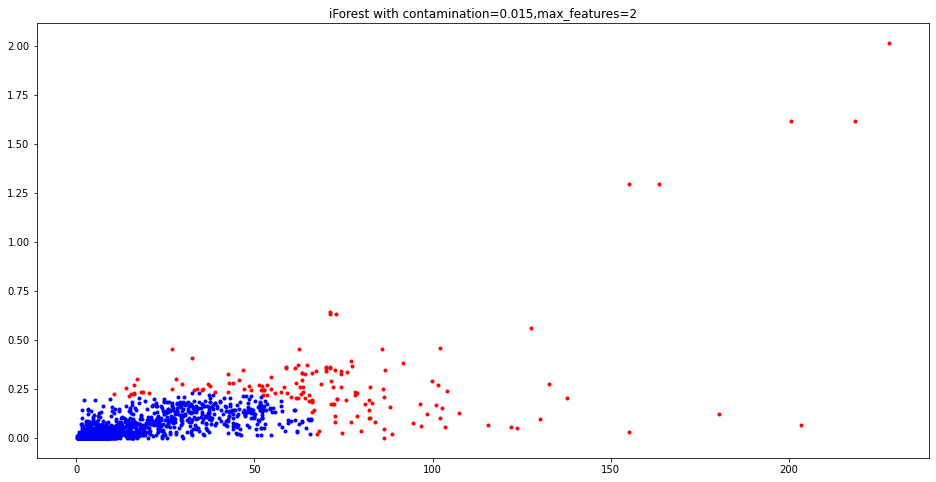

16
49
10
56
13
34
40
47
18


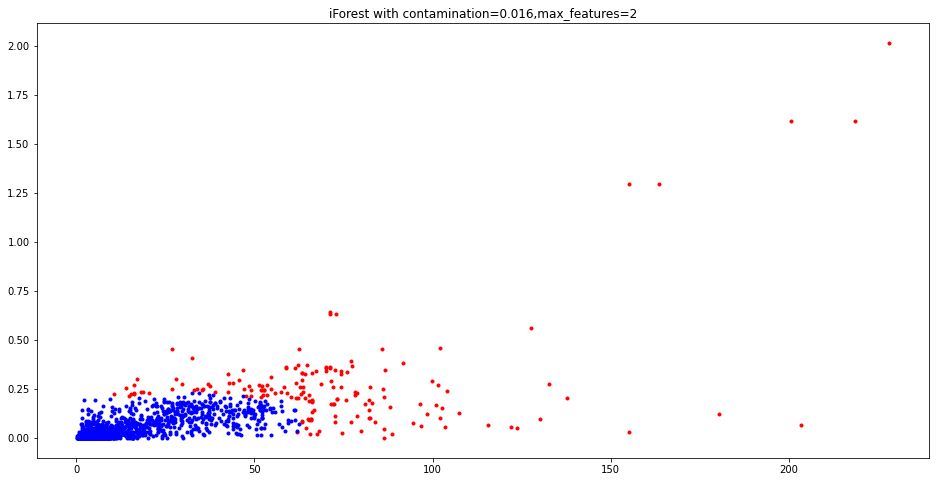

16
49
9
56
13
34
40
47
18


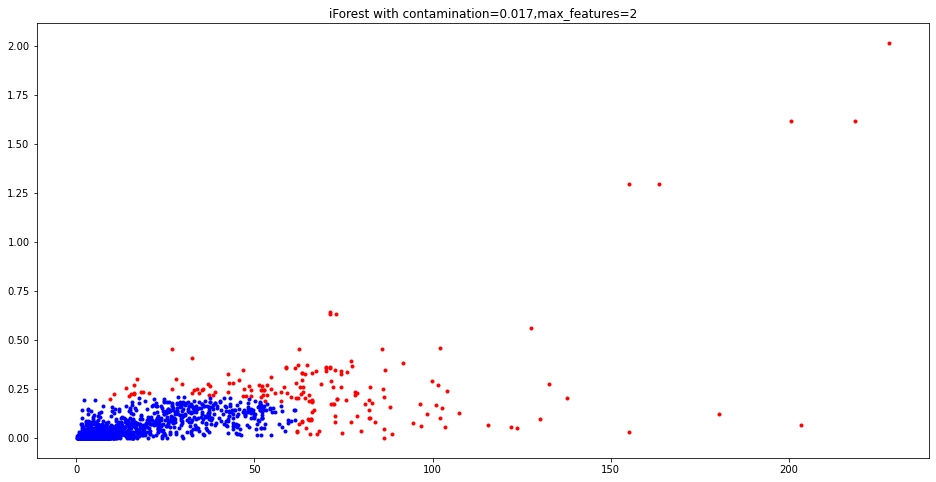

16
50
9
57
13
35
40
47
18


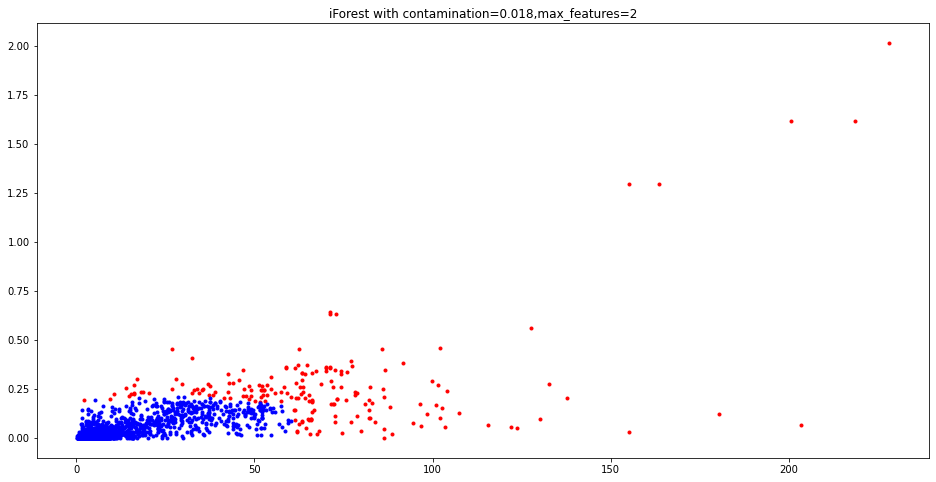

16
50
9
57
13
35
40
47
18


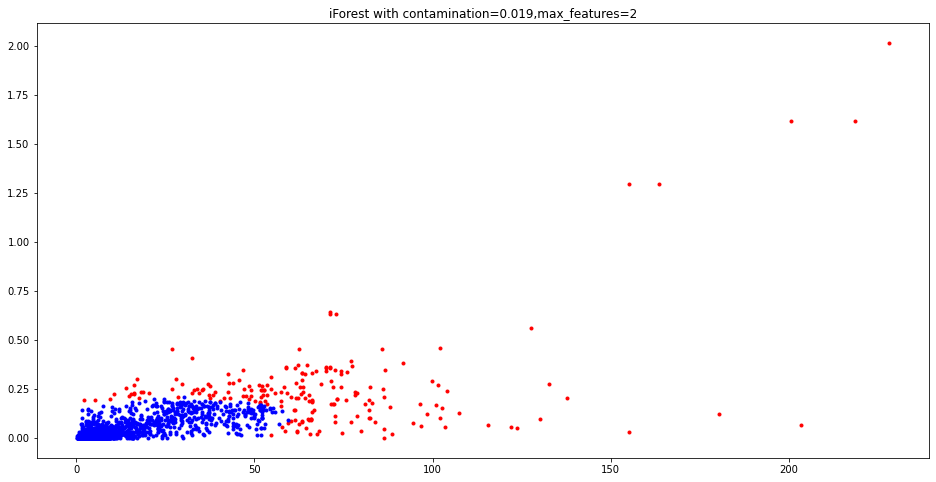

16
52
9
57
13
36
41
47
17


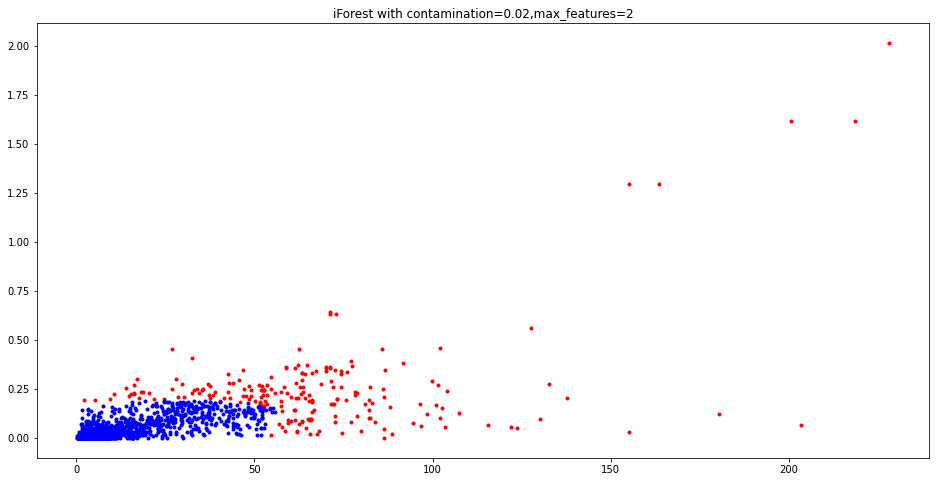

16
53
8
57
13
36
42
47
16


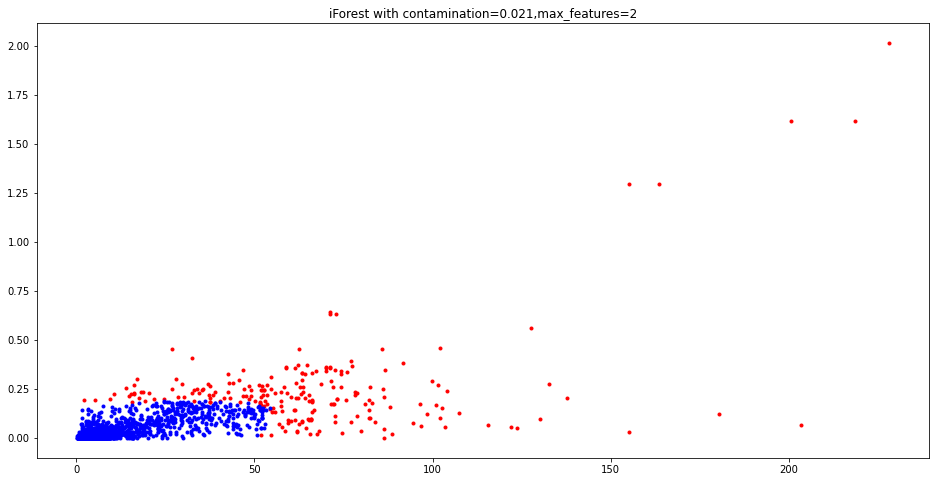

16
53
8
57
13
36
42
47
15


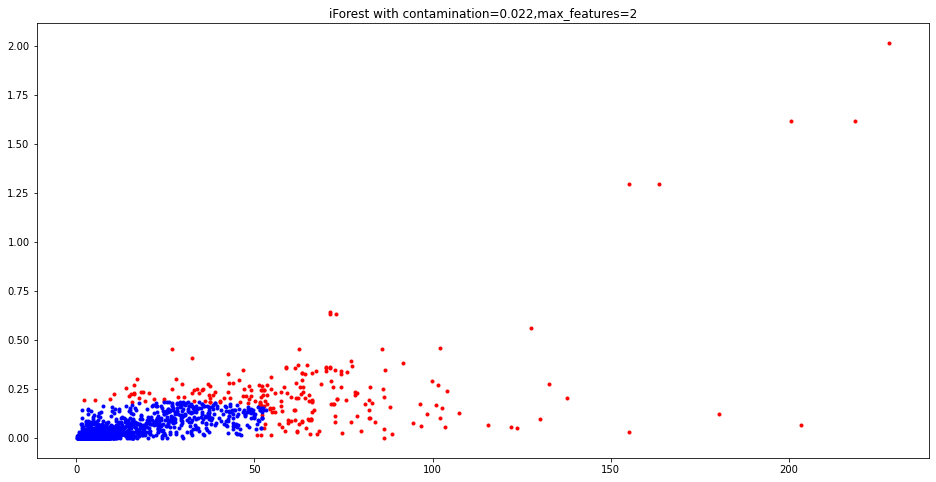

16
53
7
57
13
36
42
47
15


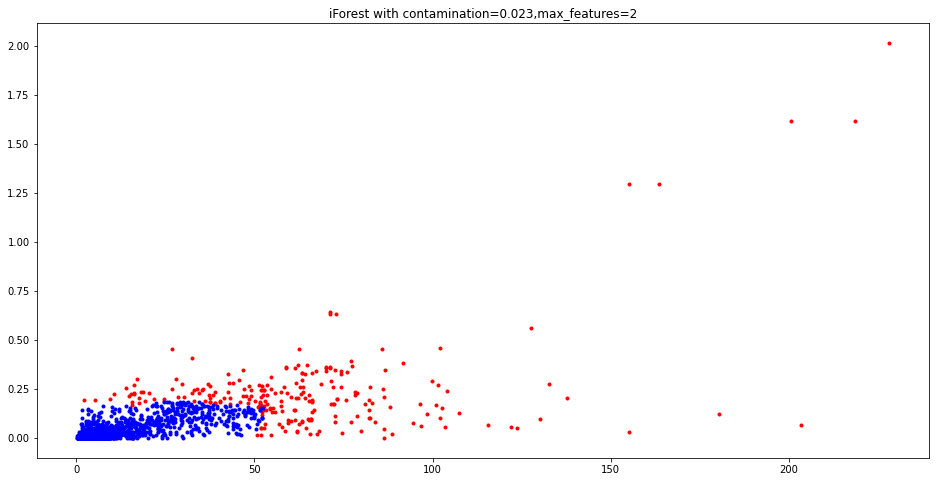

16
53
5
57
13
36
42
47
15


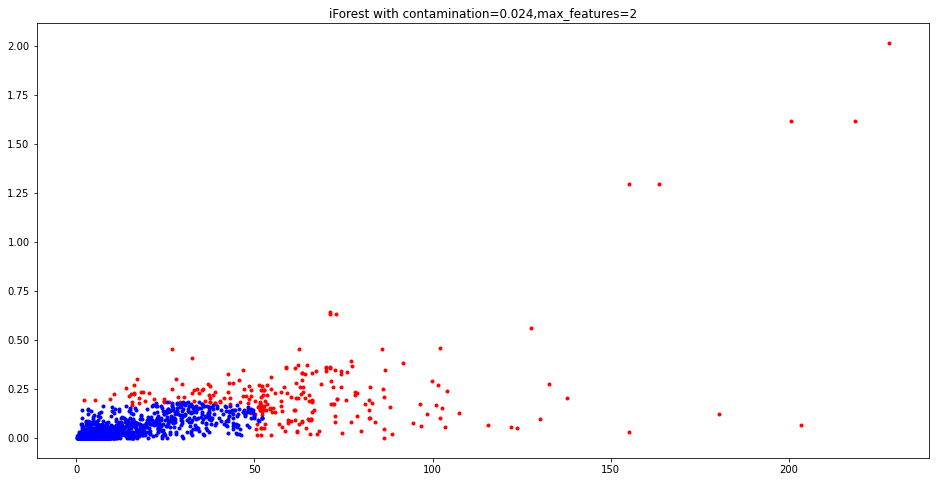

16
53
5
57
13
36
42
47
15


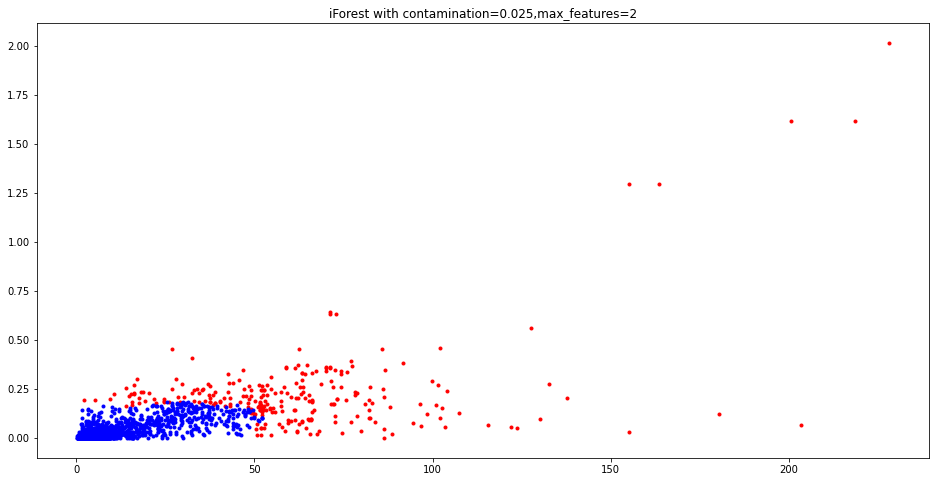

16
53
4
57
13
36
42
47
15


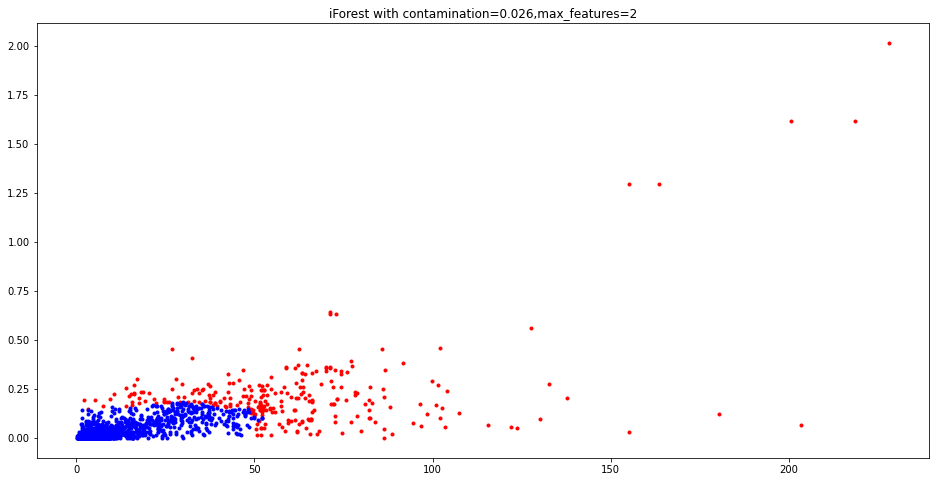

16
53
4
57
13
37
42
47
15


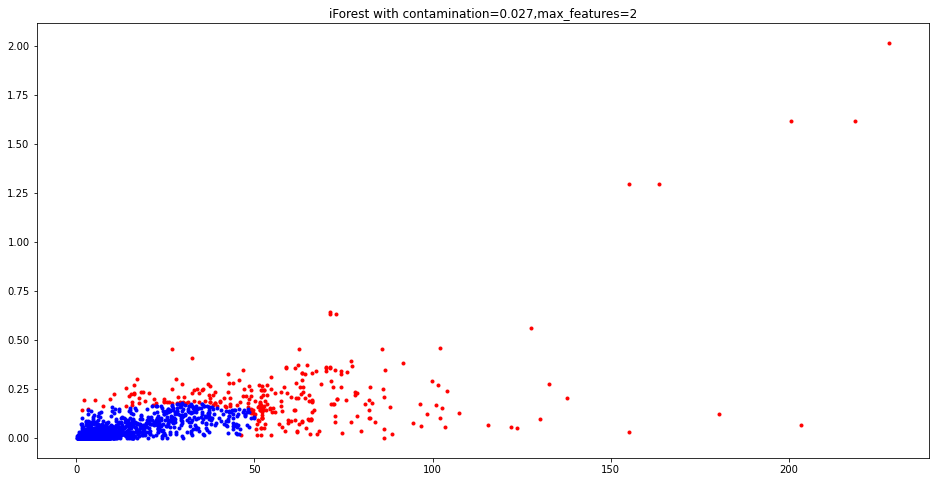

16
53
4
57
13
39
42
47
15


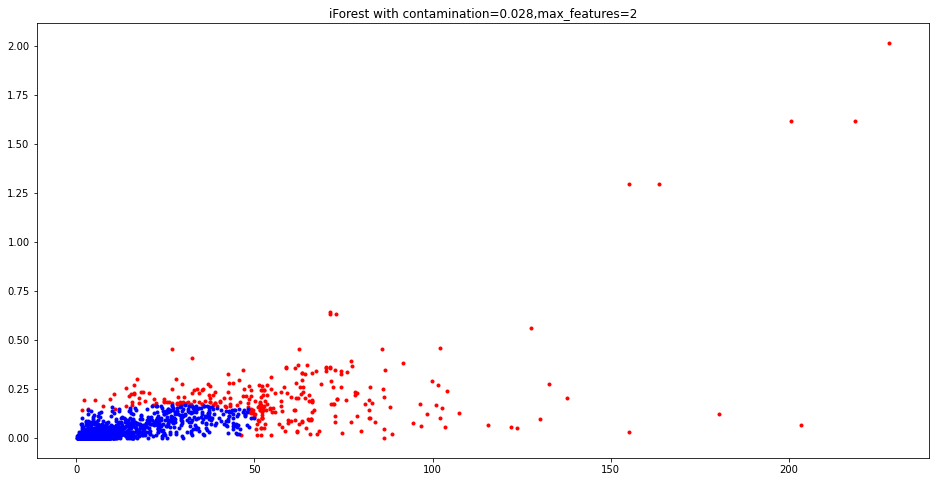

16
53
4
57
13
39
42
47
15


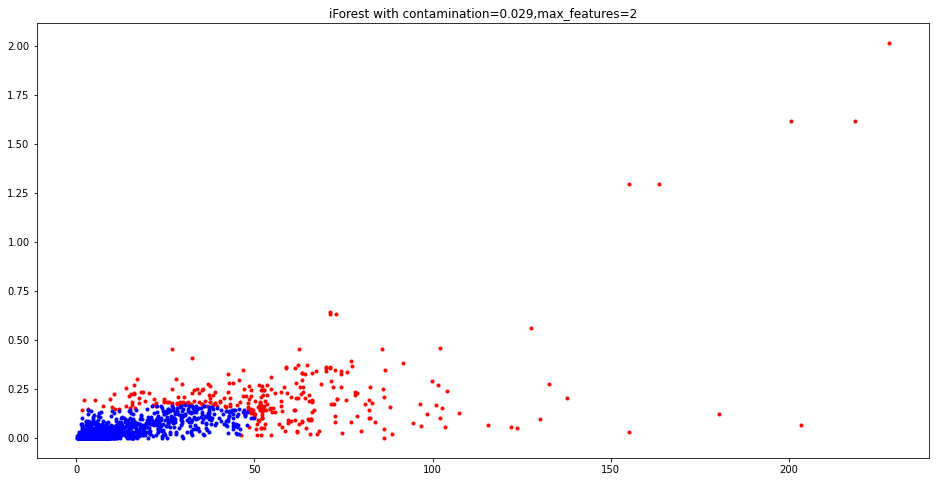

16
53
4
57
13
39
42
47
15


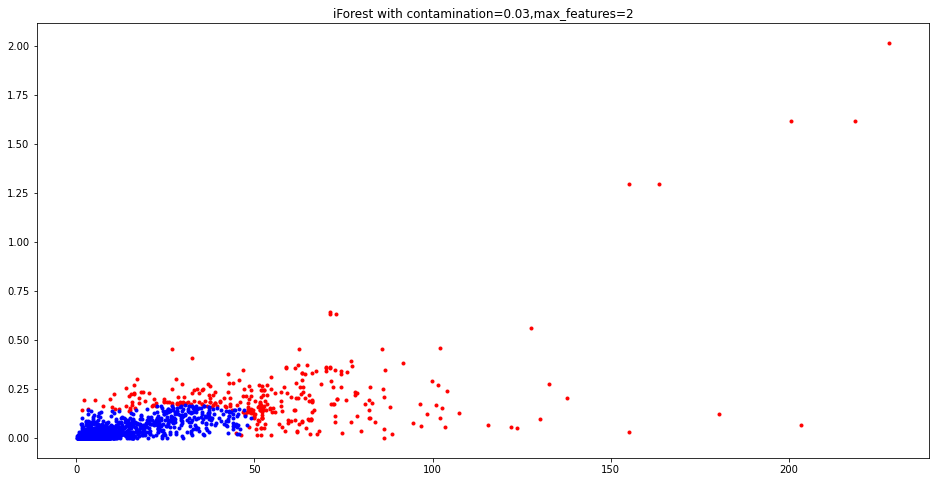

16
53
4
57
13
39
43
47
15


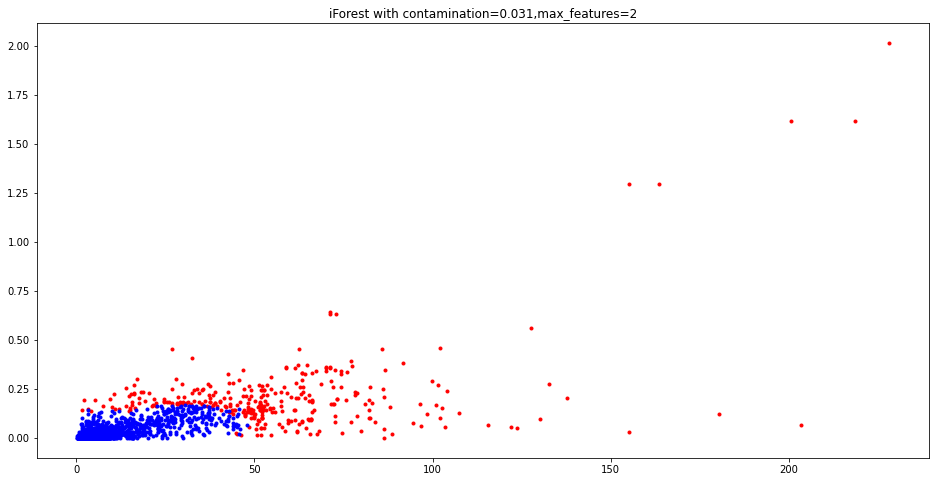

16
53
4
57
13
39
43
47
15


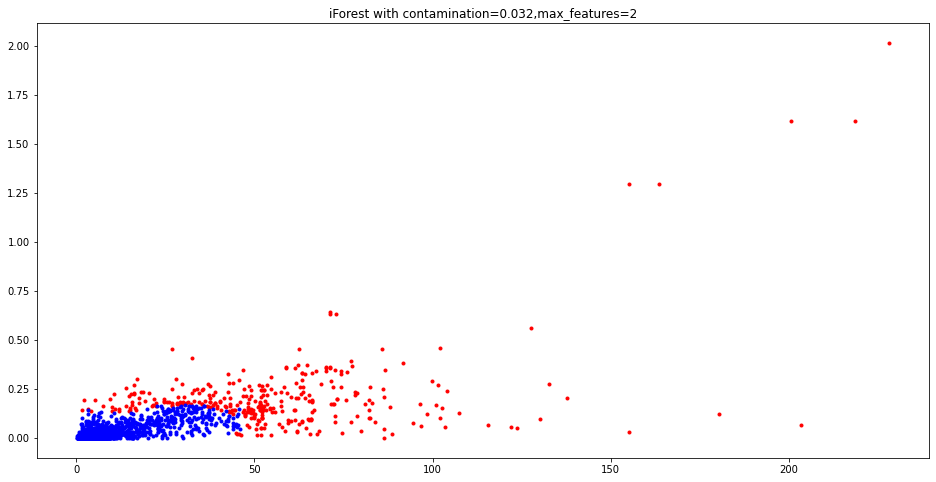

15
53
4
57
13
39
43
47
15


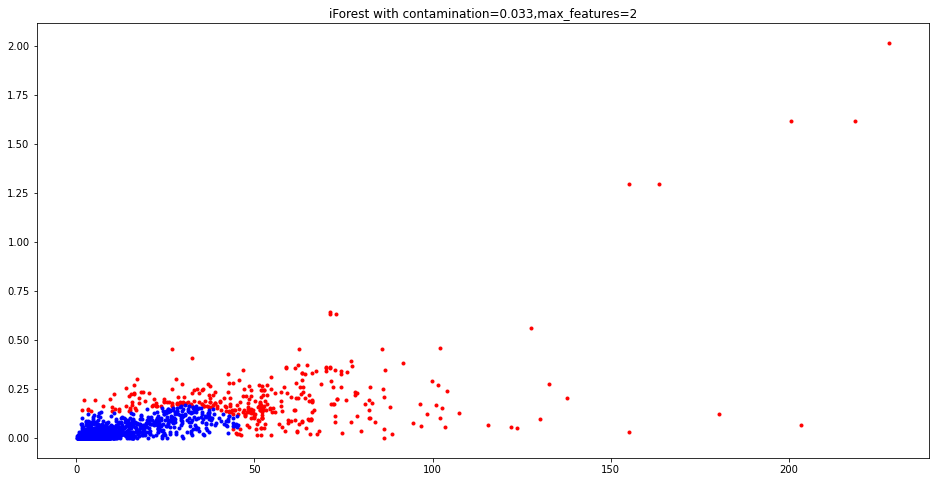

13
53
4
57
13
40
43
47
14


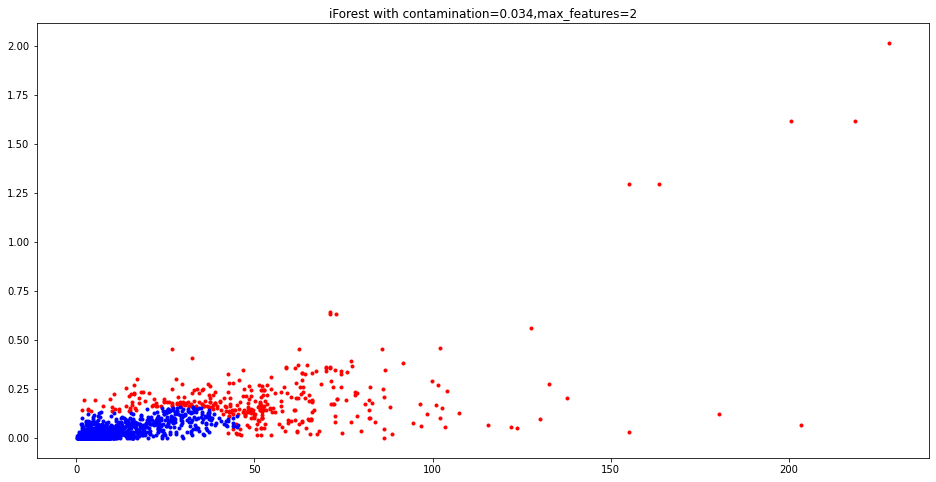

12
53
4
57
13
40
43
47
14


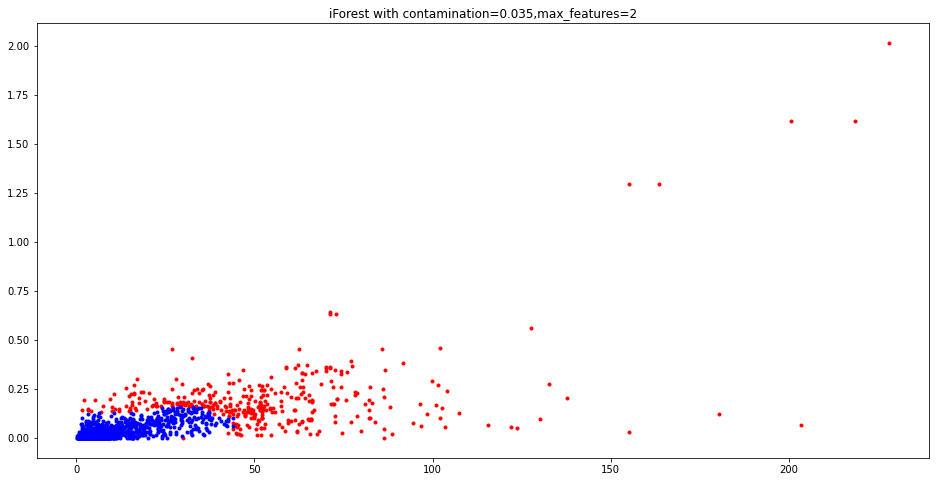

12
53
4
57
13
41
43
47
13


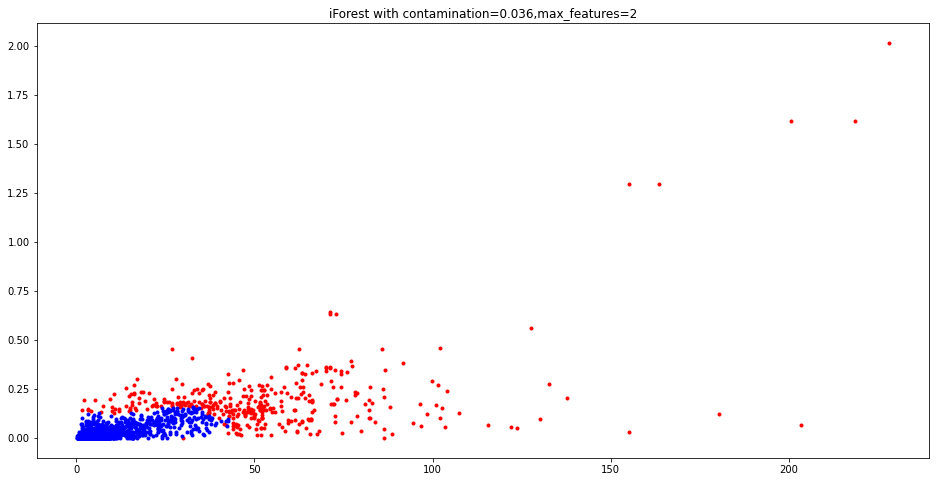

12
53
4
57
12
41
43
47
12


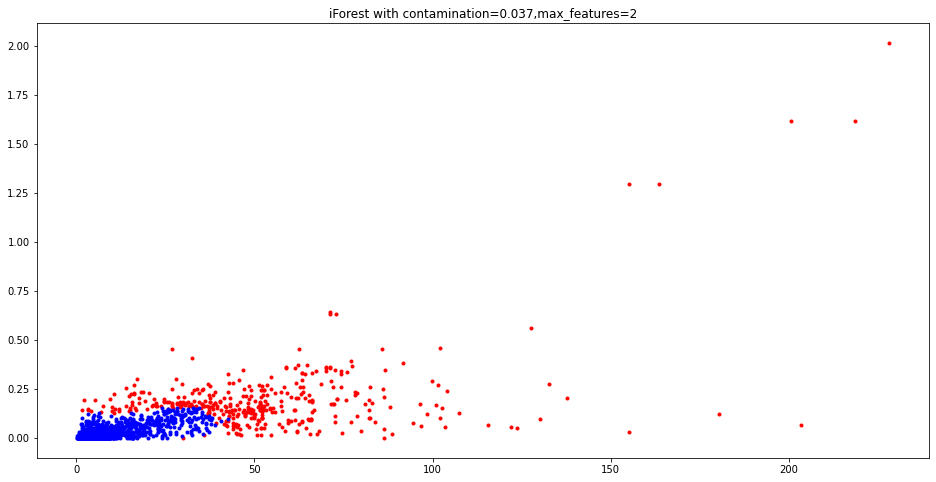

12
53
4
57
12
41
43
47
10


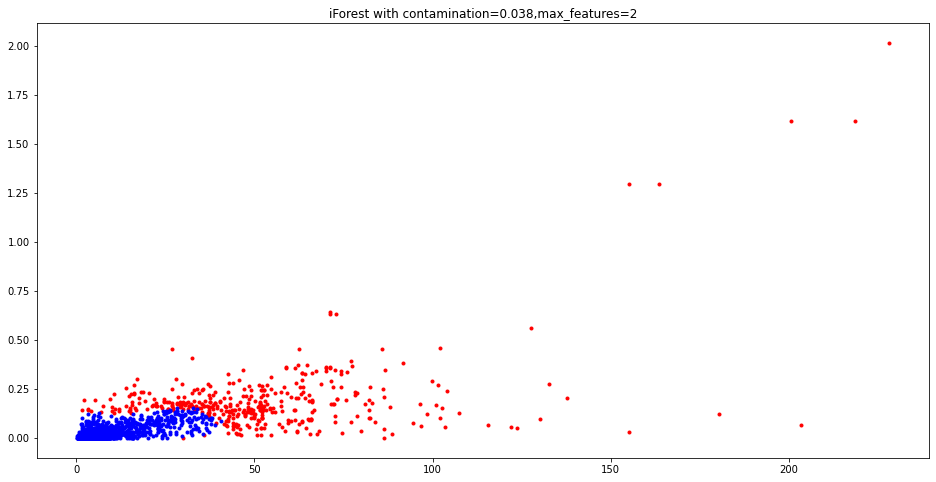

12
53
4
57
12
41
43
47
10


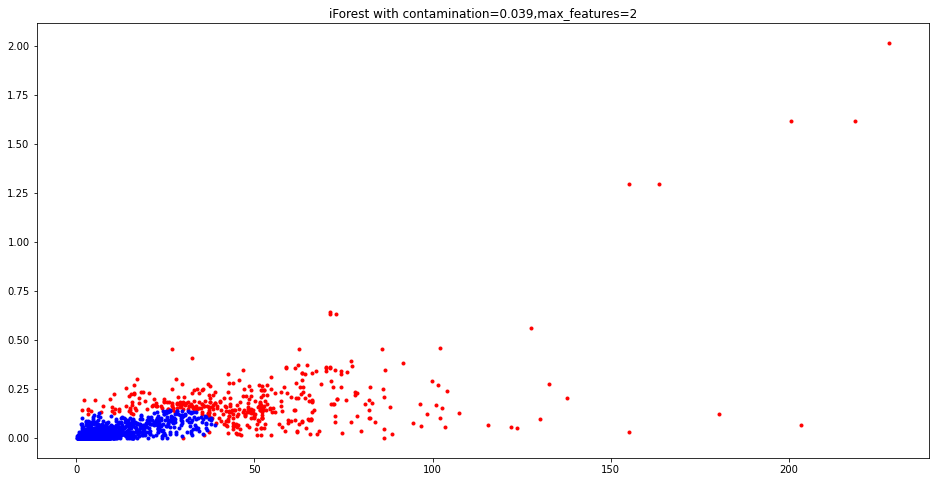

11
53
4
57
12
41
43
47
10


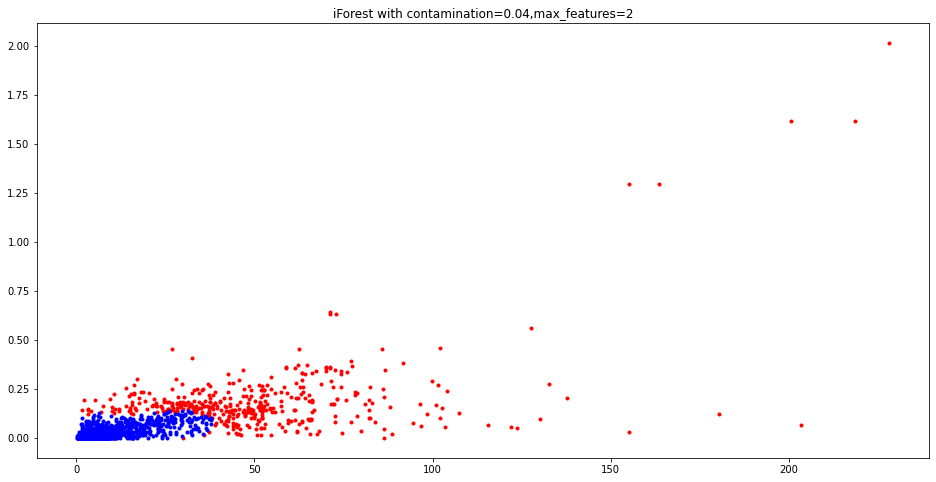

11
53
4
57
12
41
43
47
10


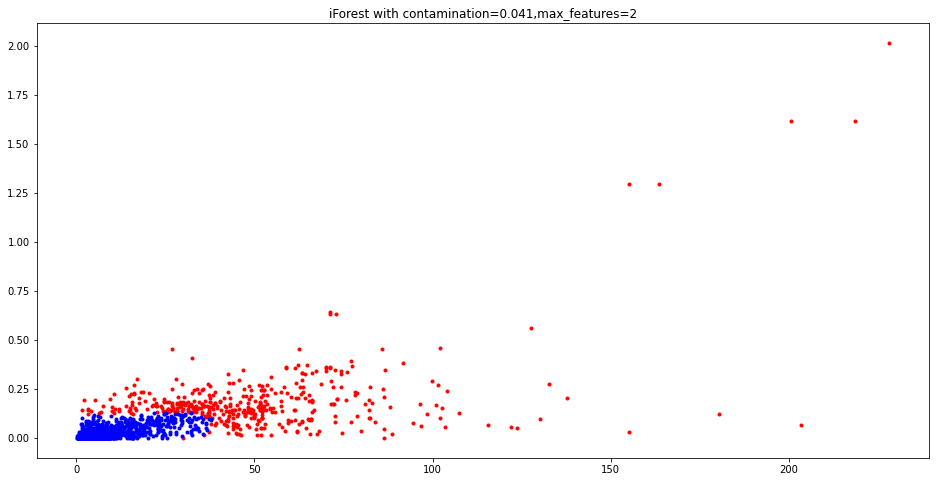

10
53
4
57
12
42
43
47
10


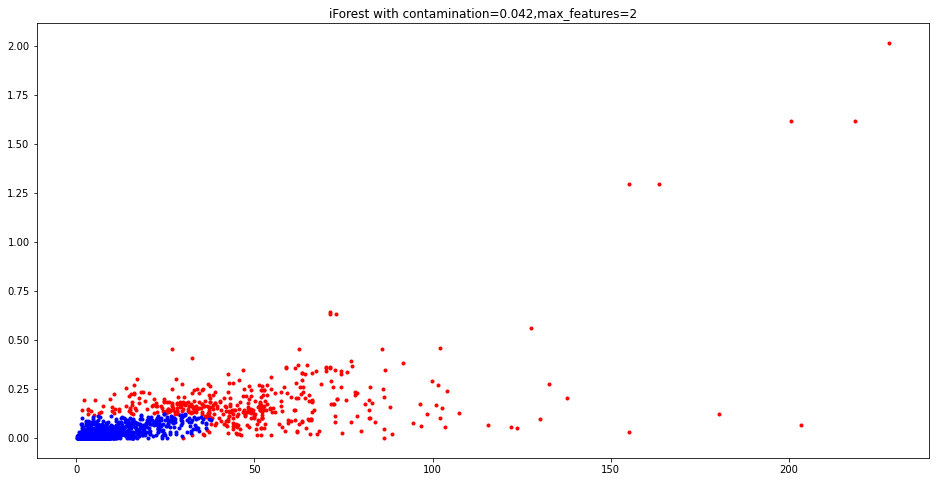

10
53
4
57
12
43
43
47
10


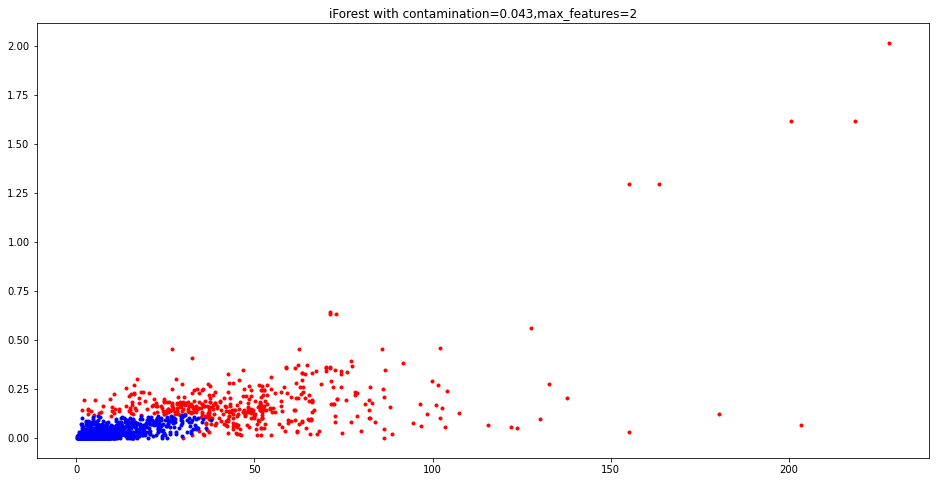

9
53
4
57
12
43
43
47
10


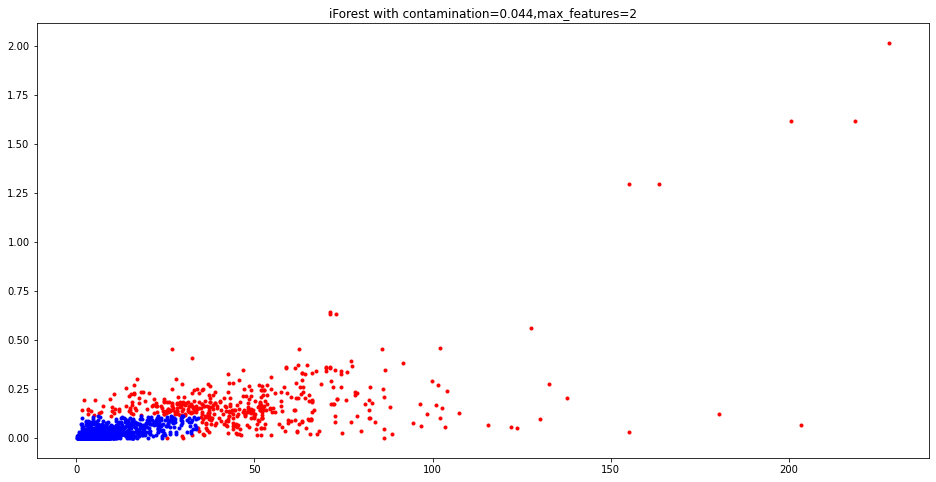

7
54
4
57
11
45
43
47
10


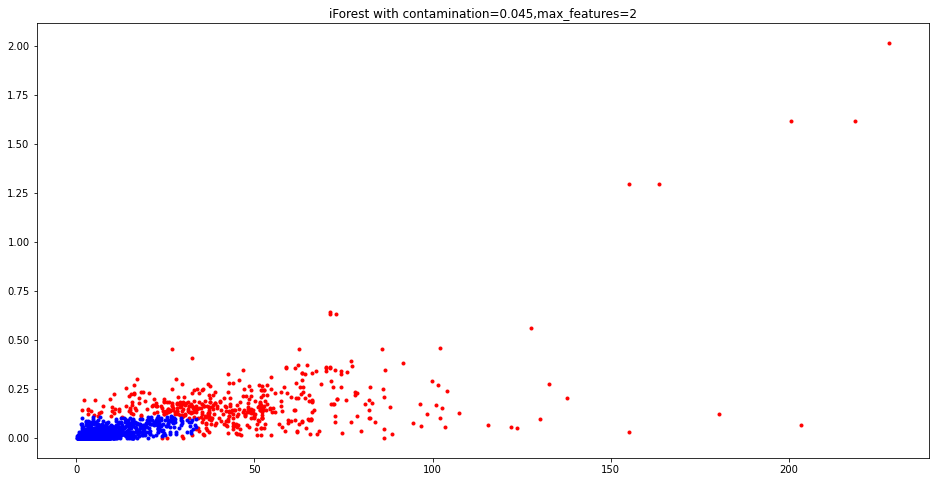

5
54
3
57
10
45
44
47
9


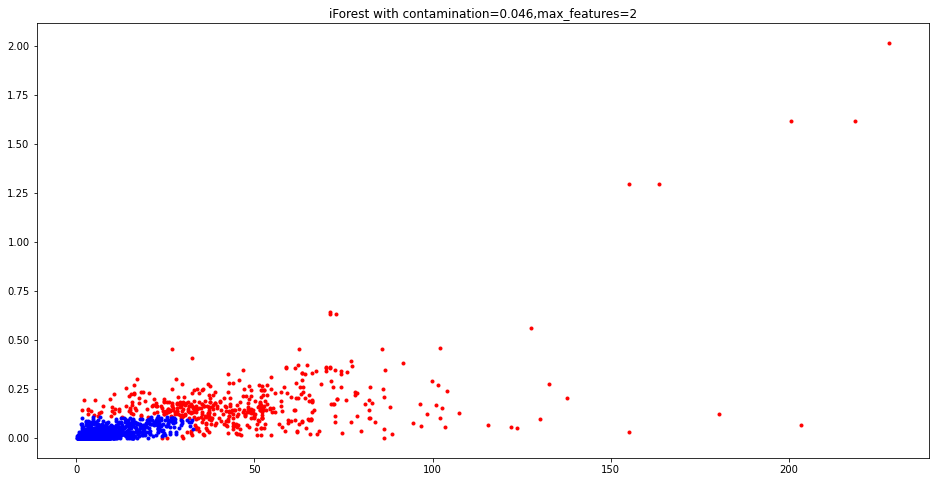

4
54
3
57
9
45
44
47
9


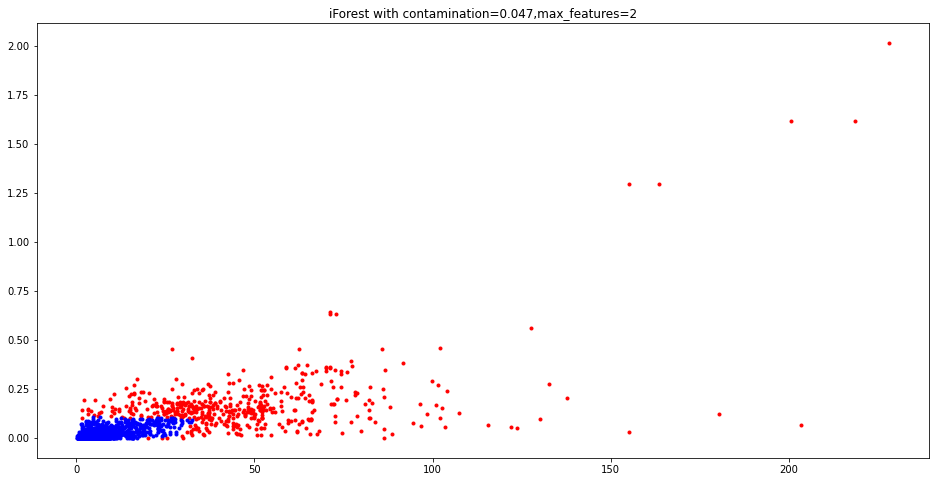

3
54
3
57
9
45
44
47
9


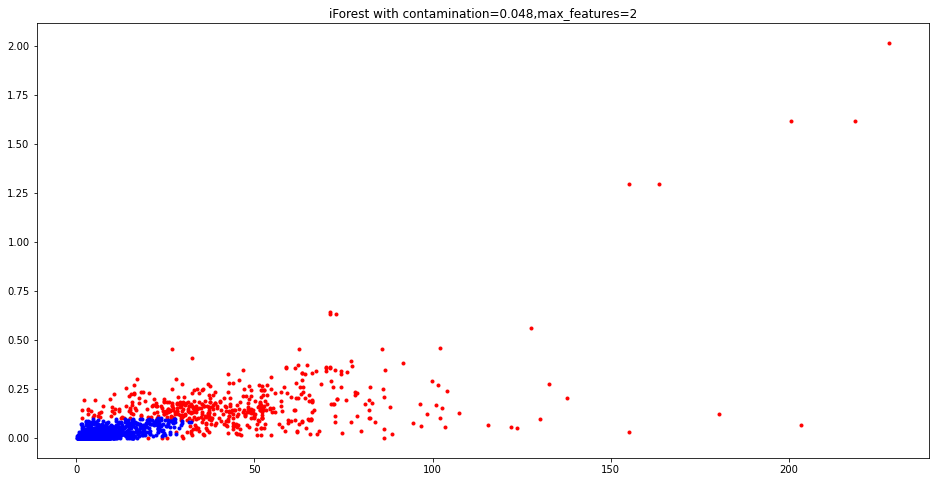

3
54
2
57
9
45
45
47
9


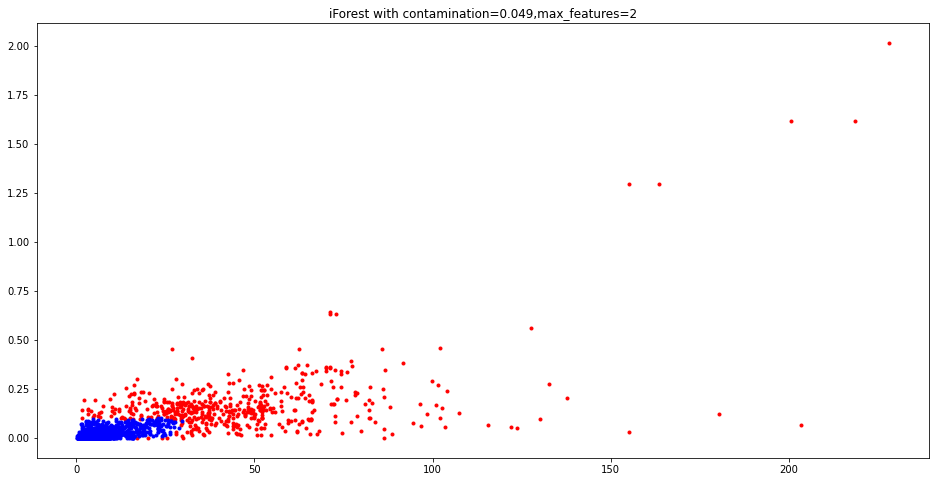

3
54
2
57
9
45
45
47
7


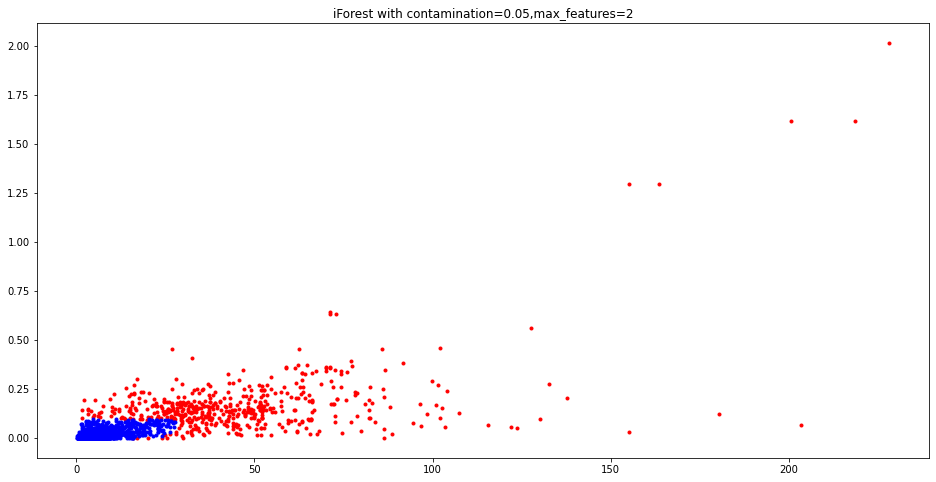

3
54
2
57
8
45
45
47
7


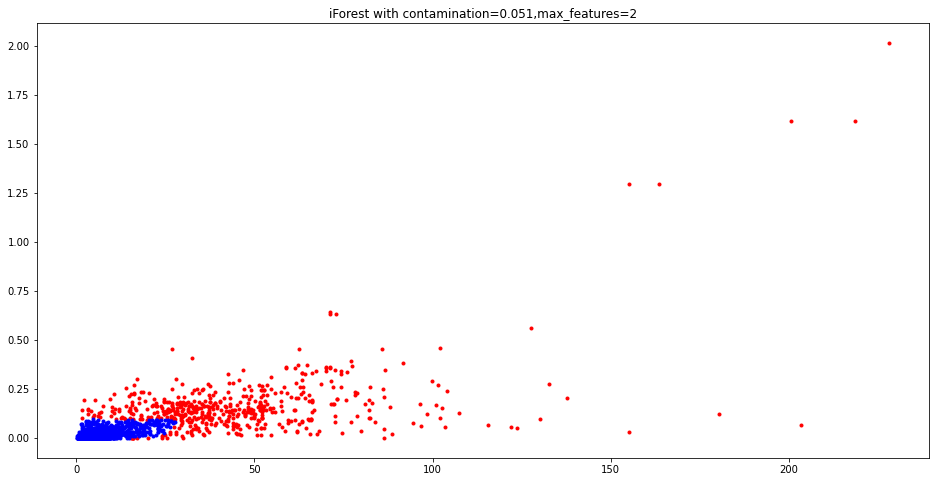

3
54
2
57
8
45
45
47
7


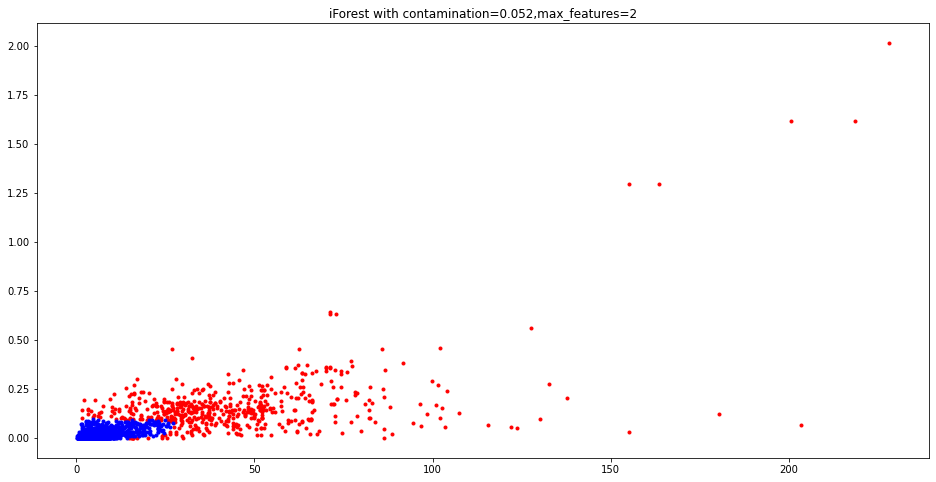

2
54
2
57
8
45
45
47
7


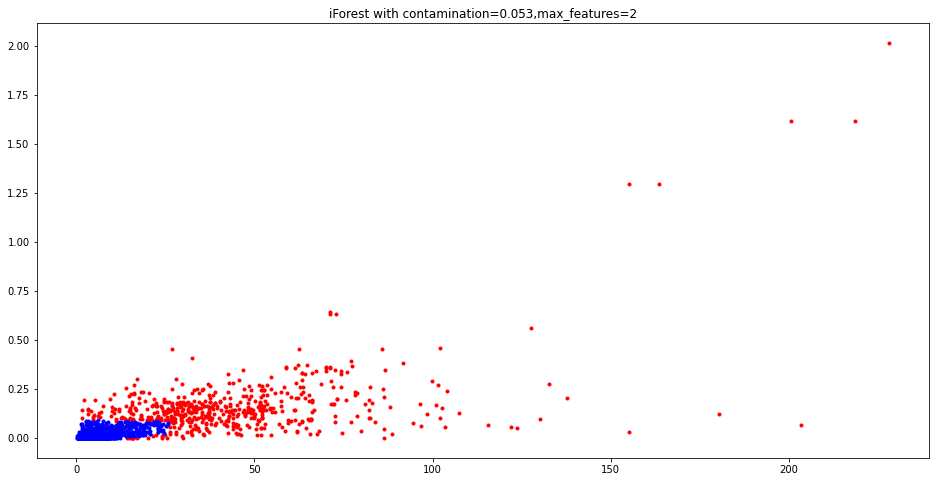

2
54
2
57
8
45
45
48
7


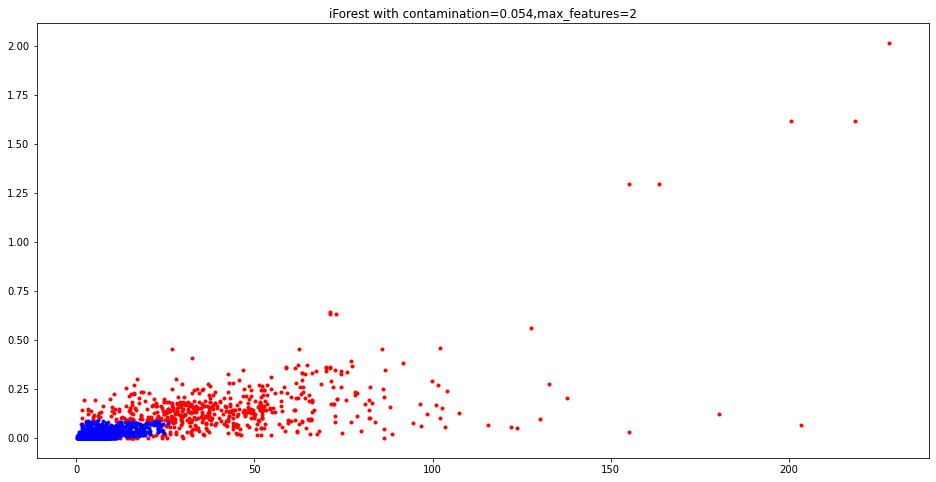

2
55
2
57
8
45
45
48
7


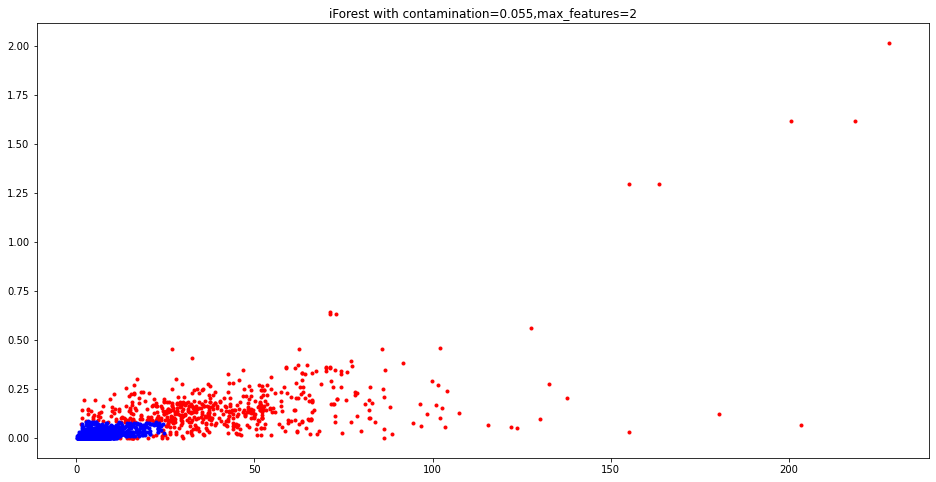

2
55
2
57
8
45
45
48
7


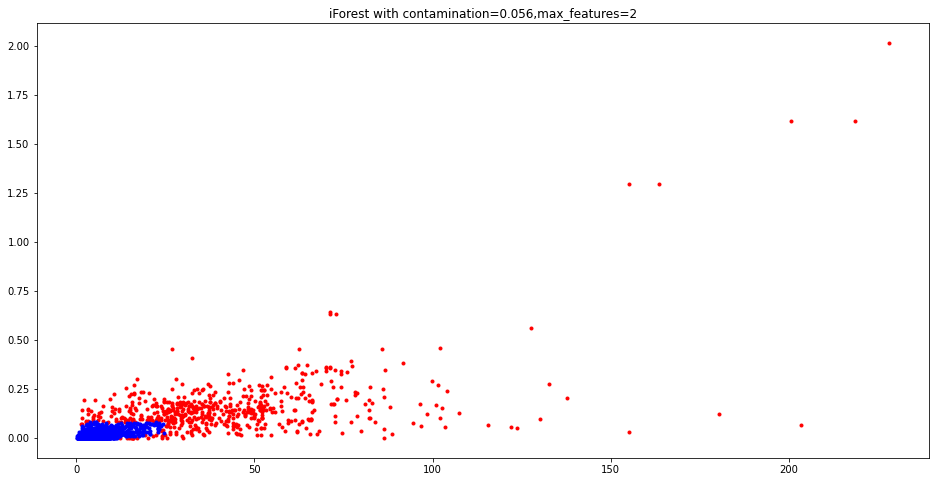

2
55
2
57
8
45
45
48
7


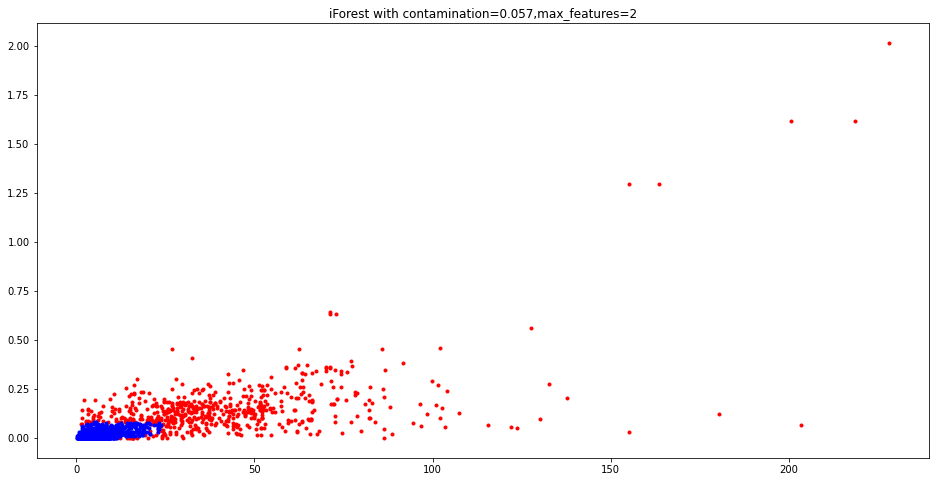

2
55
2
57
8
45
45
48
7


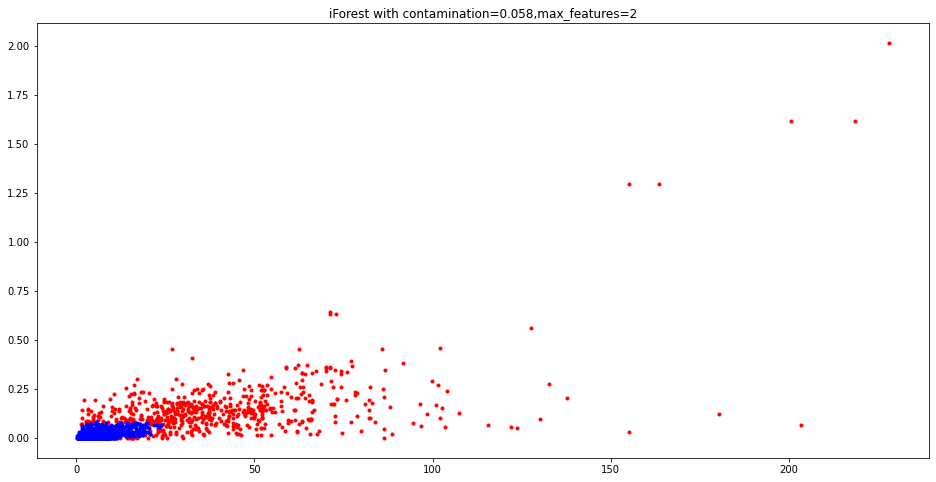

2
55
2
57
8
45
46
48
7


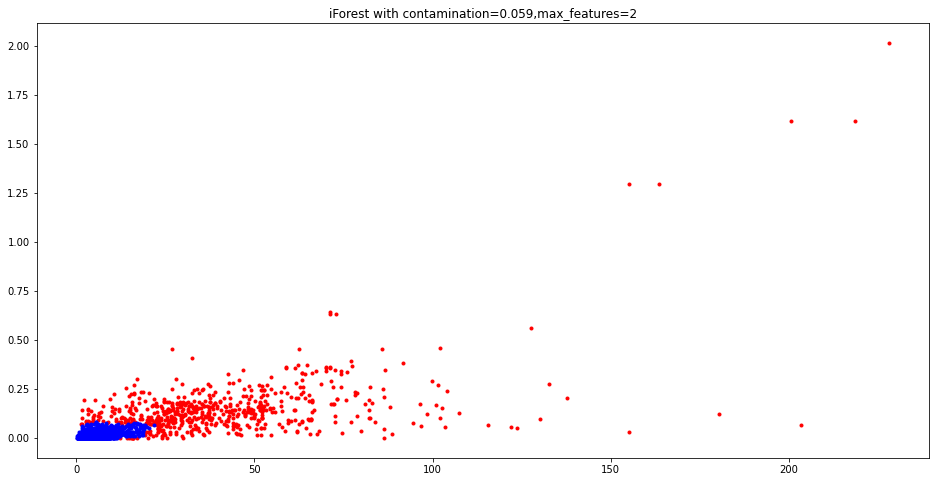

2
55
2
57
8
45
46
48
7


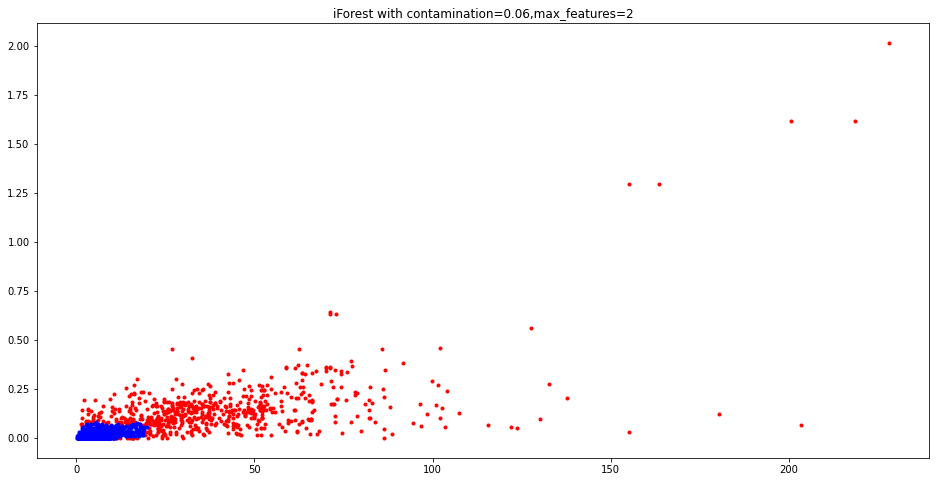

2
55
2
57
8
45
46
48
7


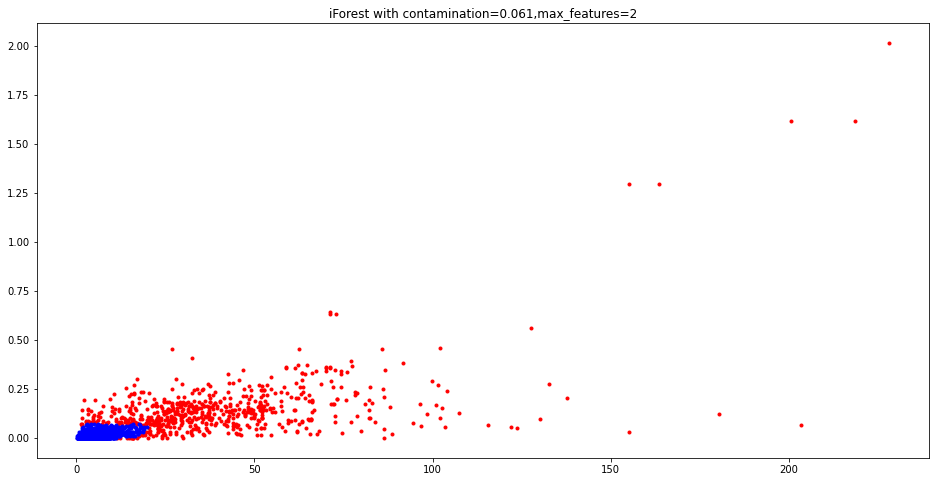

2
55
2
57
8
45
46
48
7


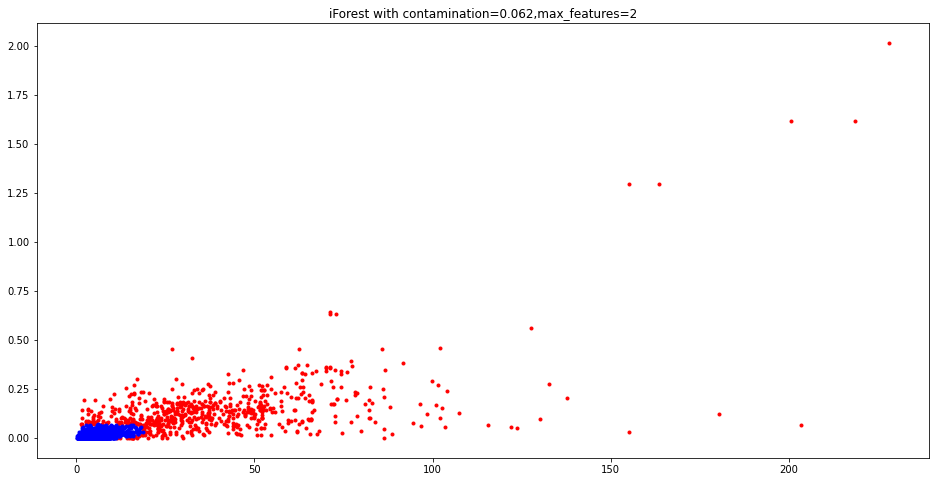

2
55
2
57
8
45
46
49
7


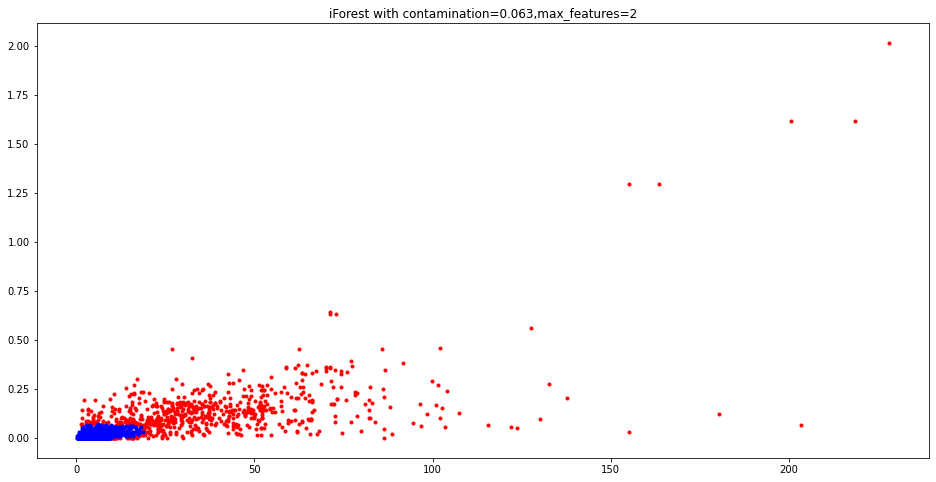

2
55
2
57
7
45
46
49
7


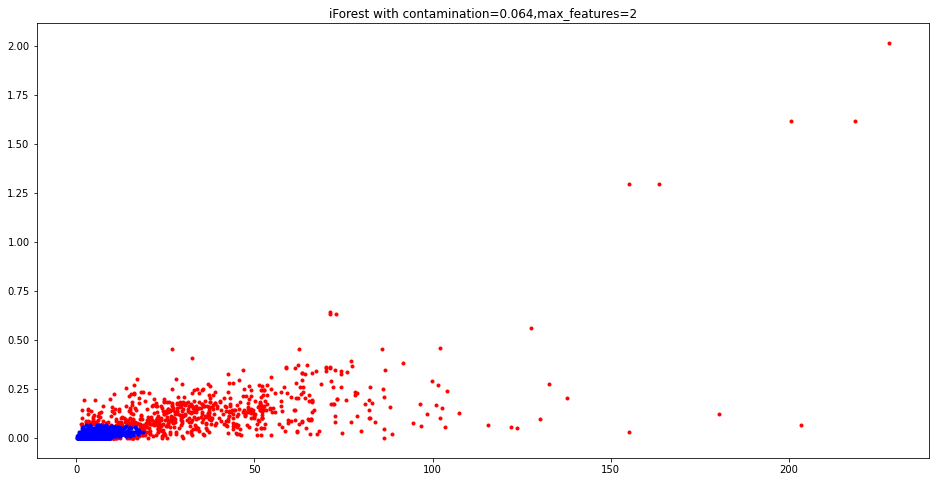

2
55
2
57
7
45
46
49
7


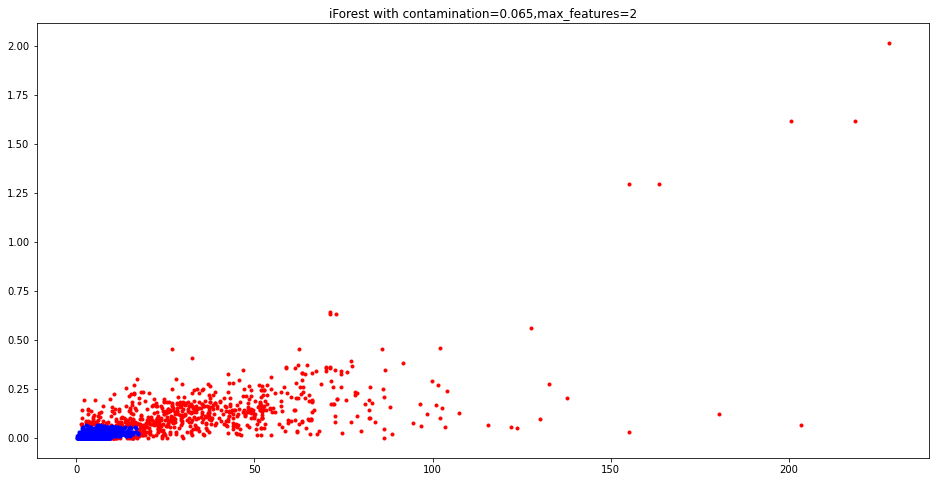

2
55
2
57
7
45
46
49
7


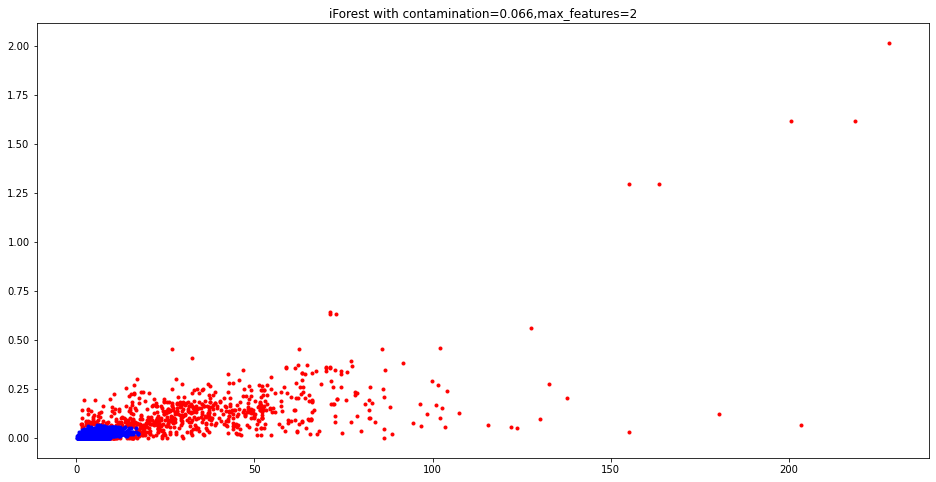

2
55
2
57
7
45
46
49
7


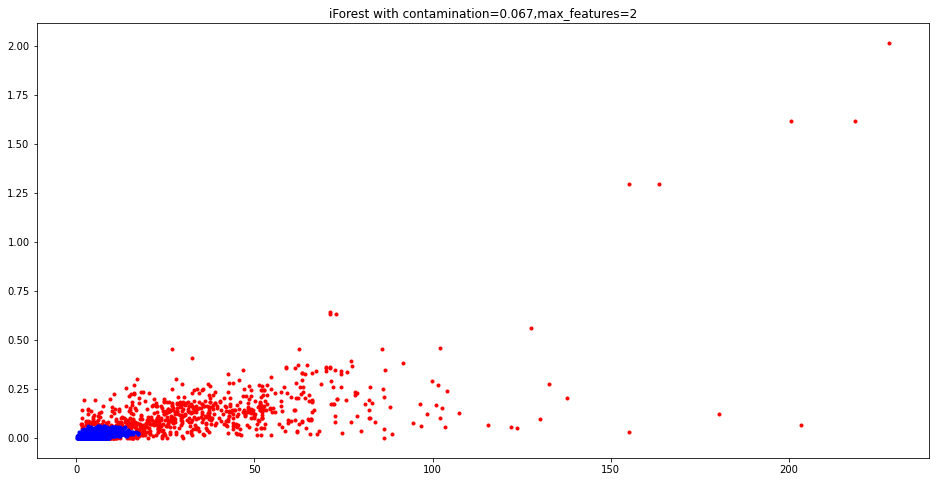

2
55
2
57
7
45
46
49
7


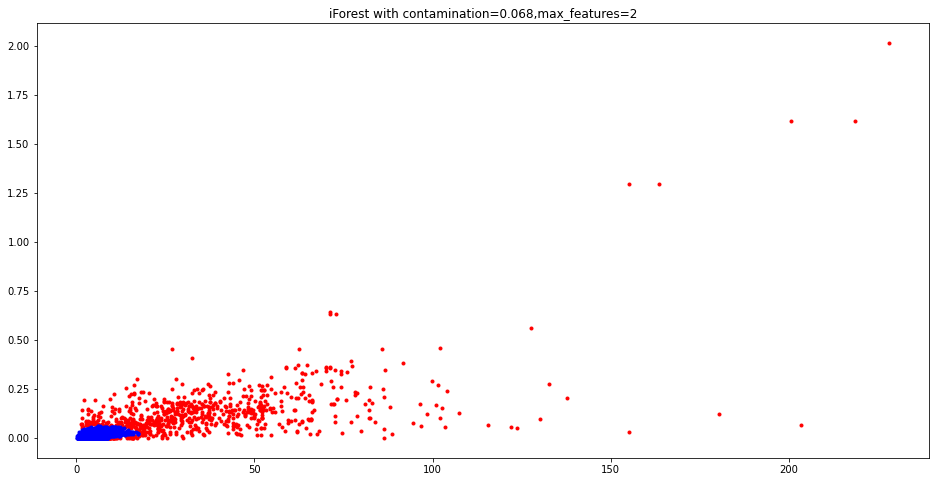

2
55
2
57
7
45
46
49
7


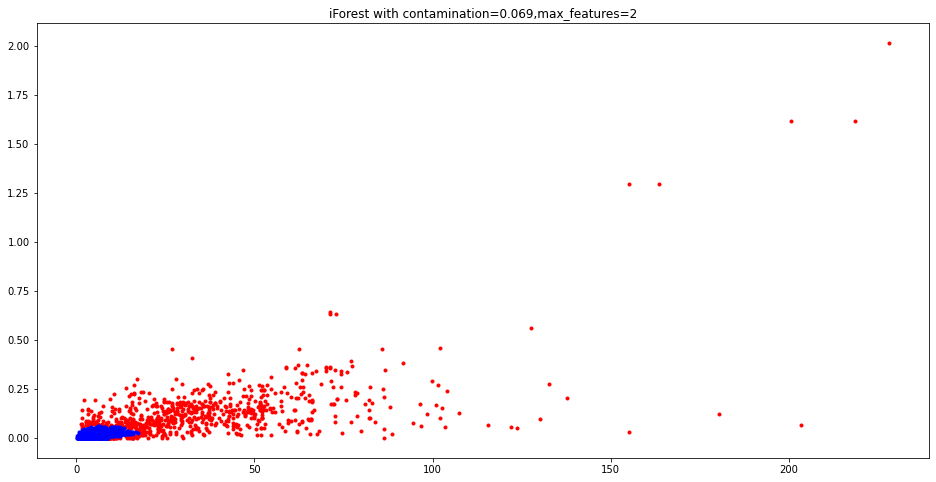

2
55
2
57
7
45
46
49
7


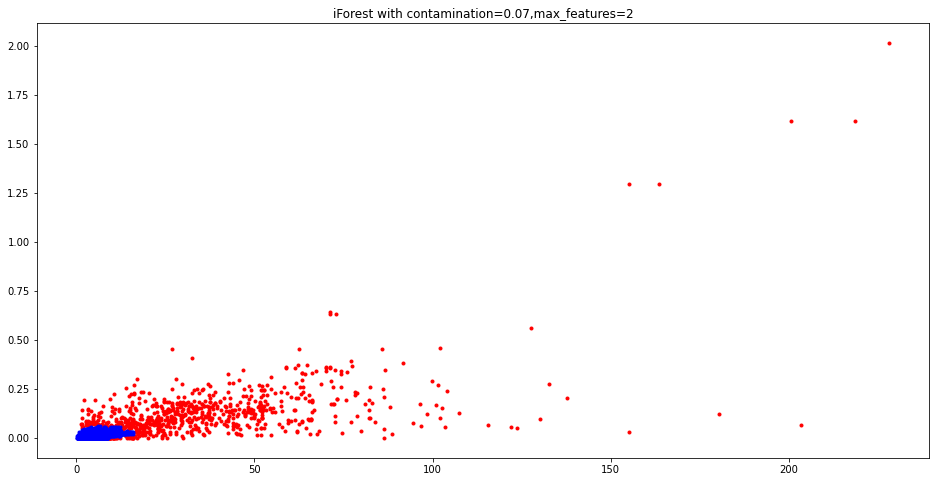

2
55
2
57
7
45
46
49
7


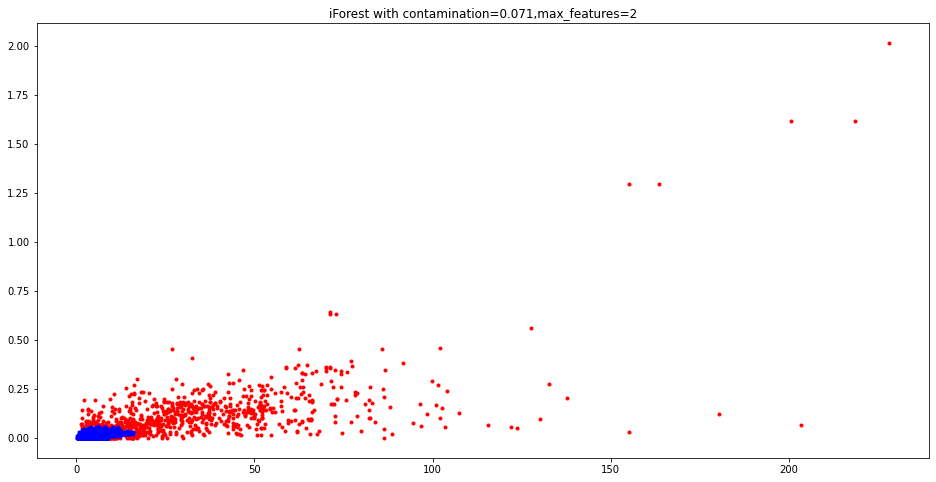

2
55
2
57
7
45
46
49
7


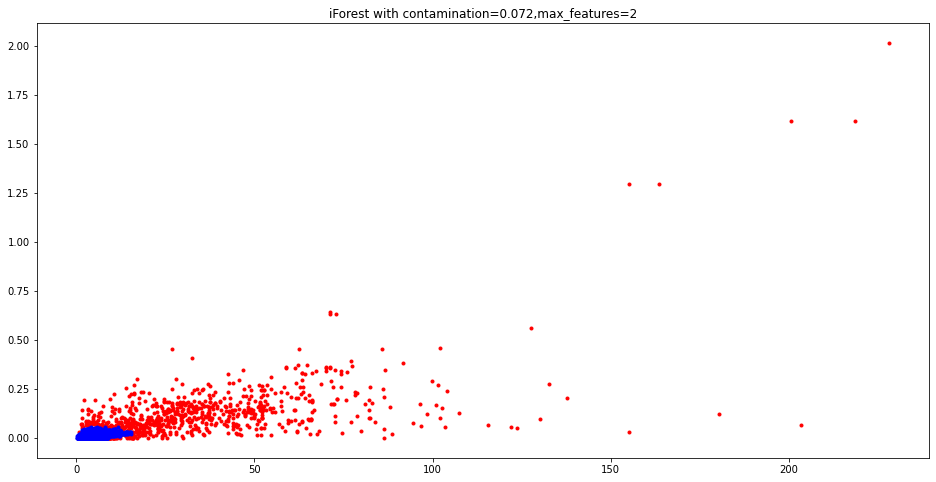

2
55
2
57
7
45
46
49
7


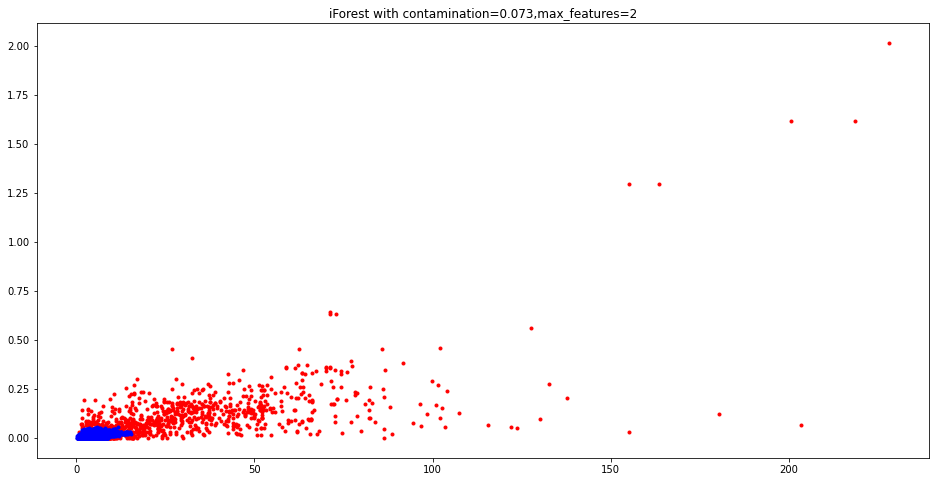

2
55
2
57
7
45
46
49
7


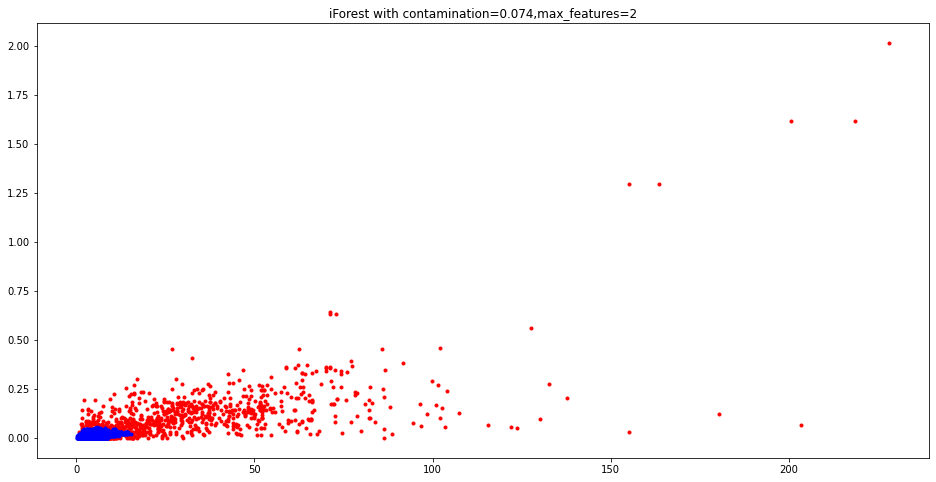

2
55
2
57
7
45
46
49
7


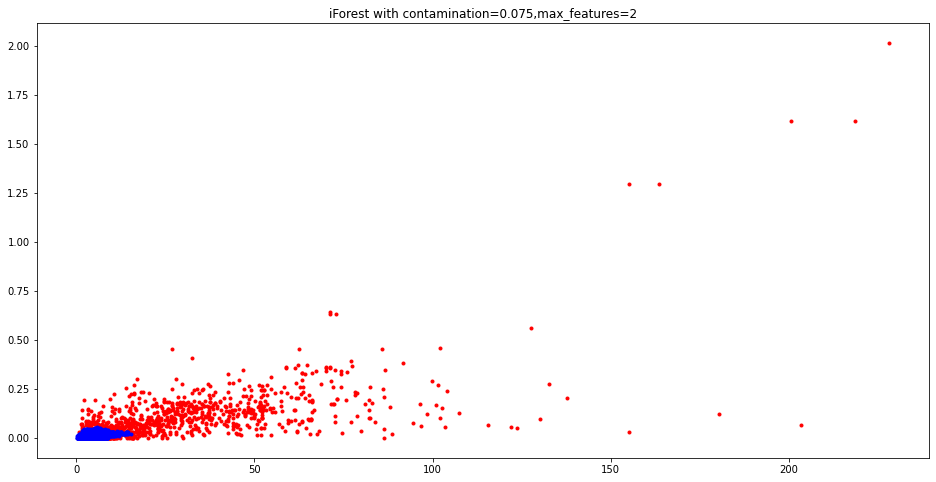

2
55
2
57
7
45
46
49
7


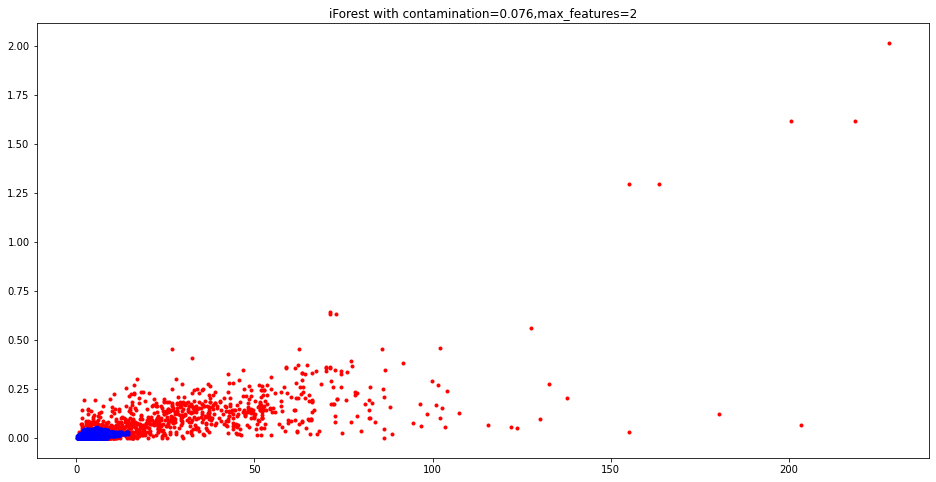

2
55
2
57
7
45
46
49
7


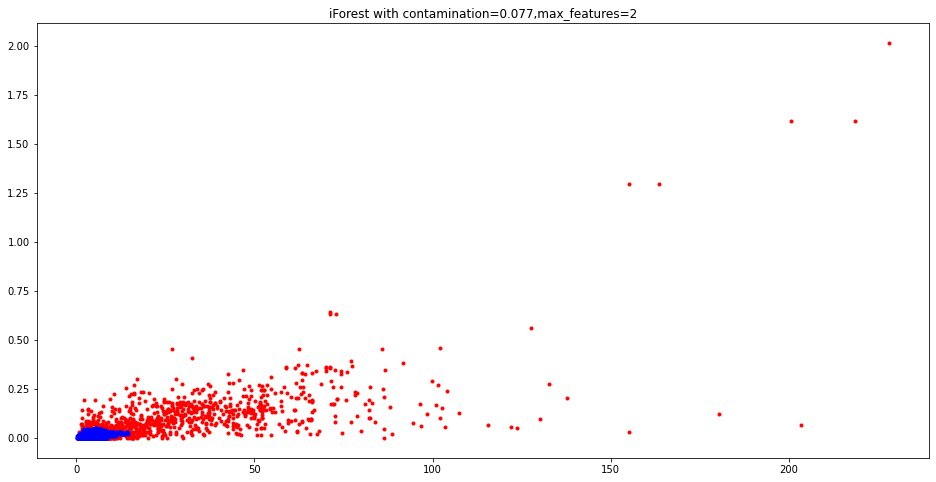

2
55
2
57
7
46
46
49
7


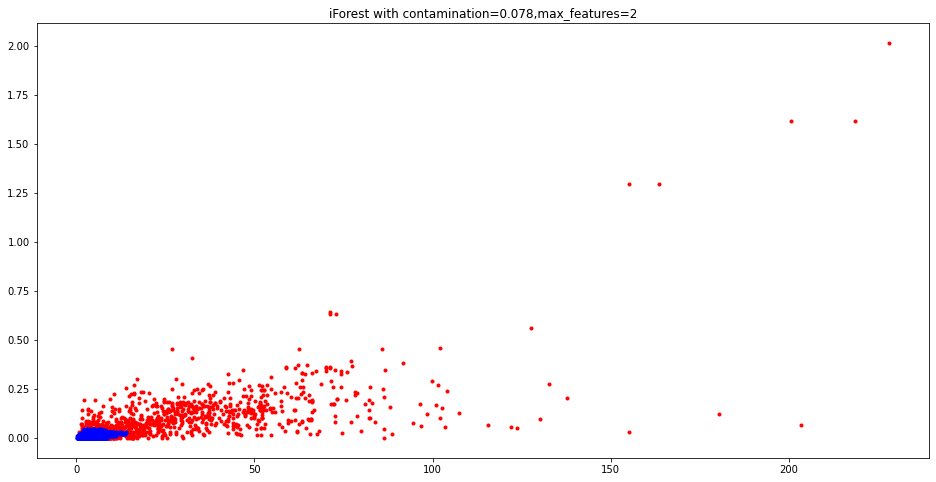

2
55
2
57
7
46
46
49
7


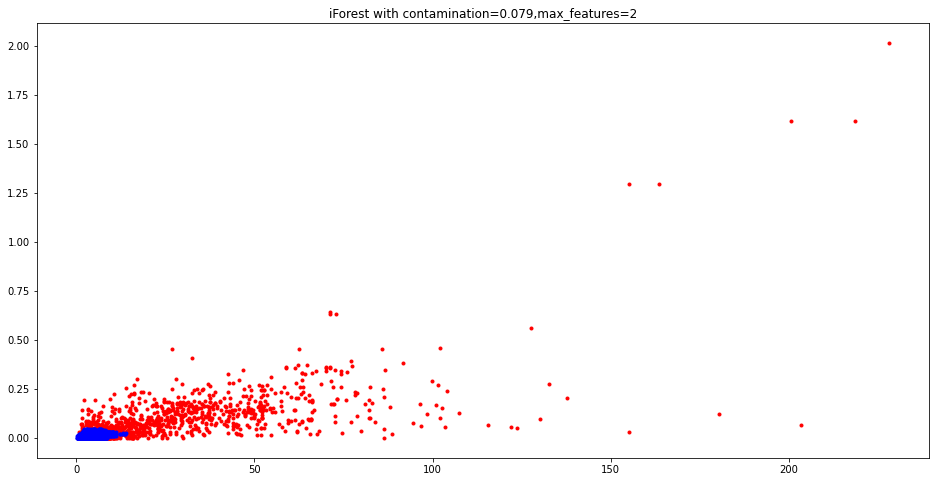

2
55
2
57
7
46
46
49
7


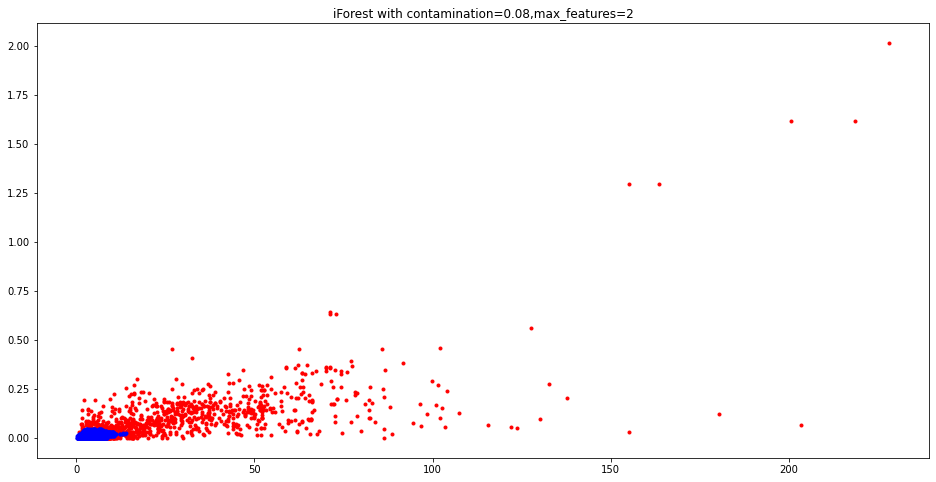

2
55
2
57
7
46
46
49
7


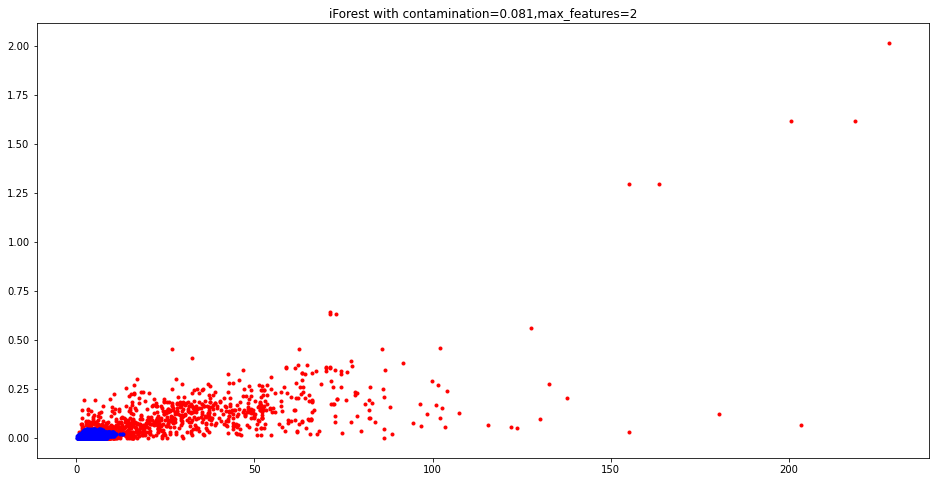

2
55
2
57
7
46
46
49
7


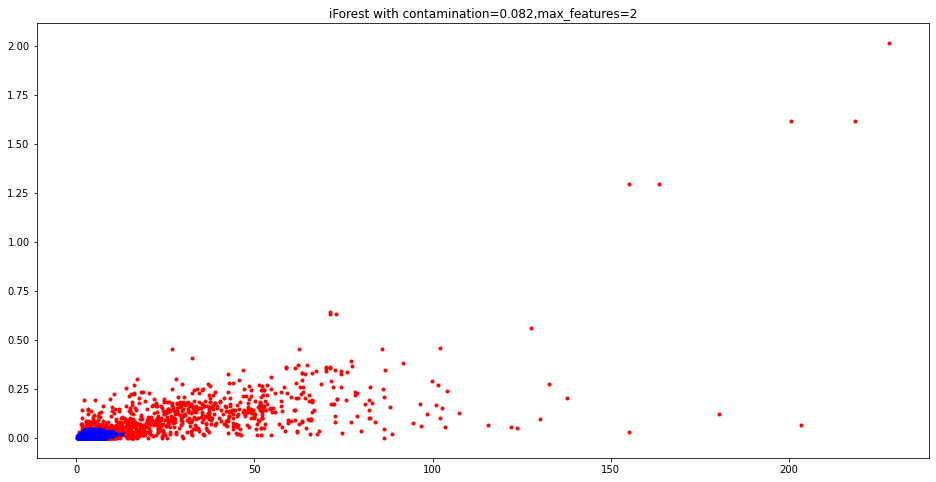

2
55
2
57
7
46
46
49
7


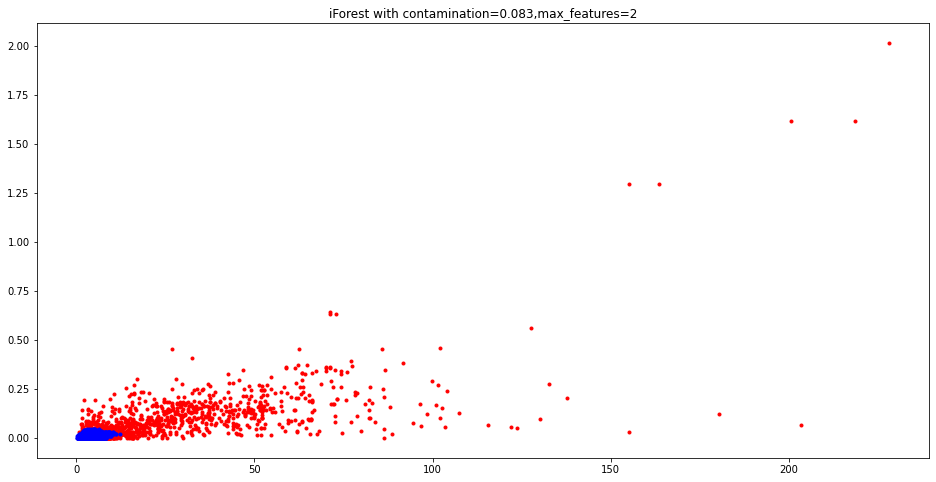

2
55
2
57
7
46
46
49
7


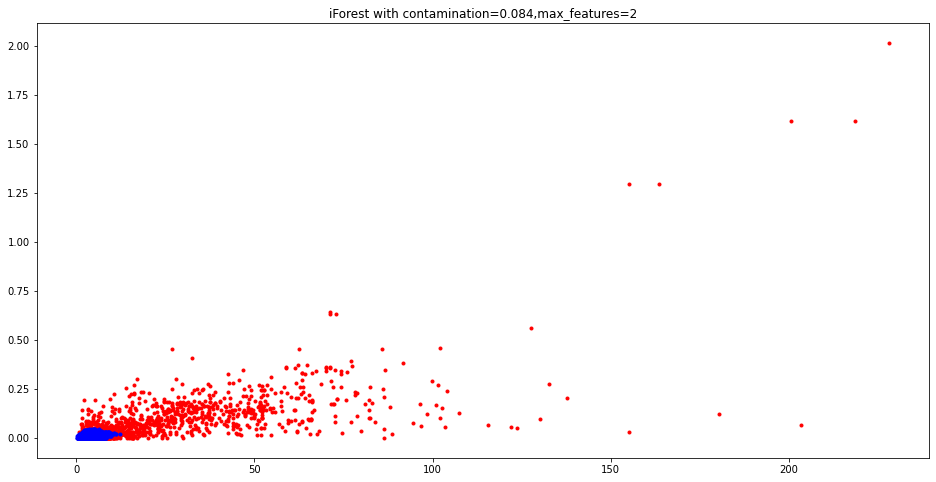

2
55
2
57
7
46
46
49
7


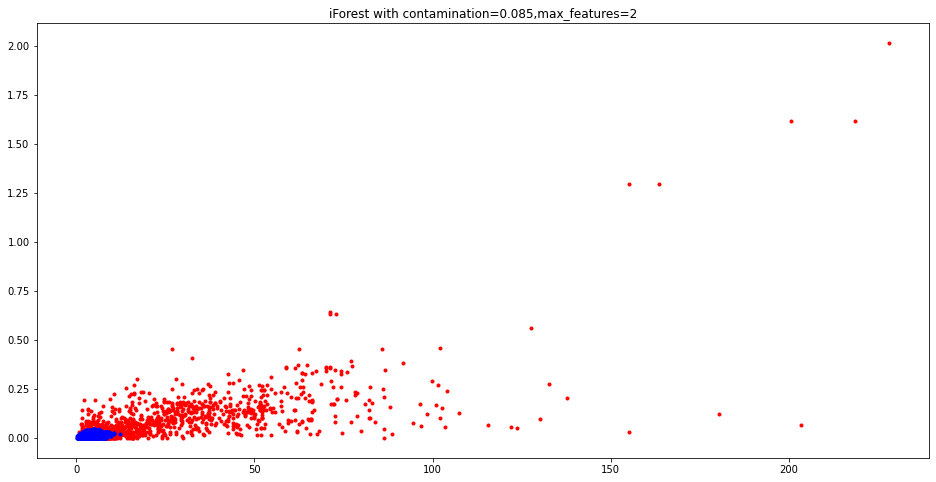

2
56
2
57
7
46
46
49
7


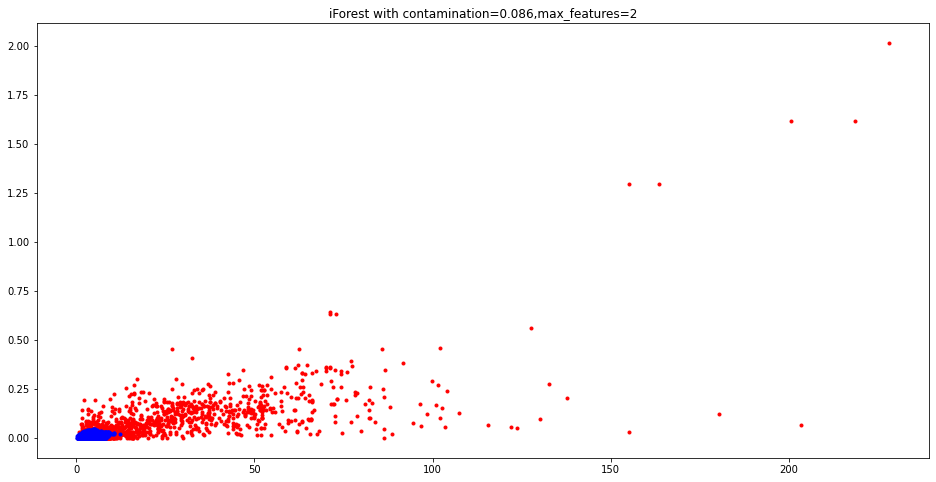

2
56
2
57
7
46
46
49
7


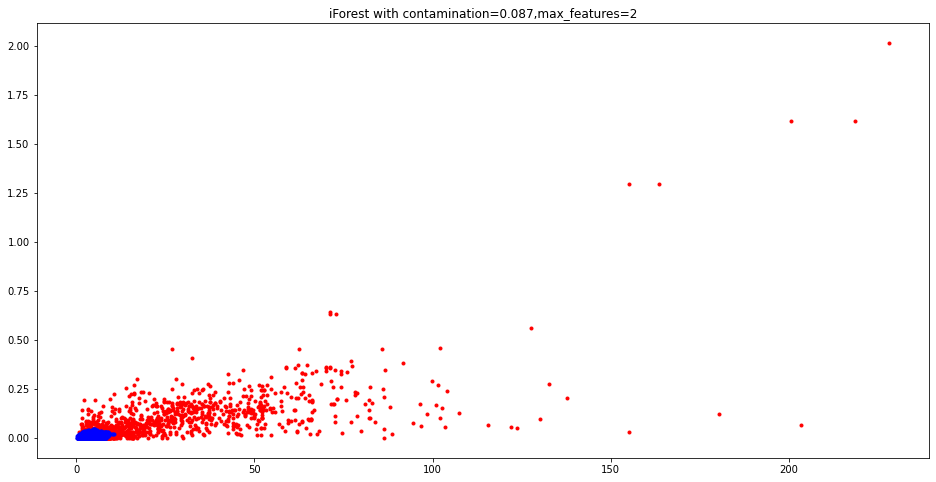

2
56
2
57
7
46
46
49
7


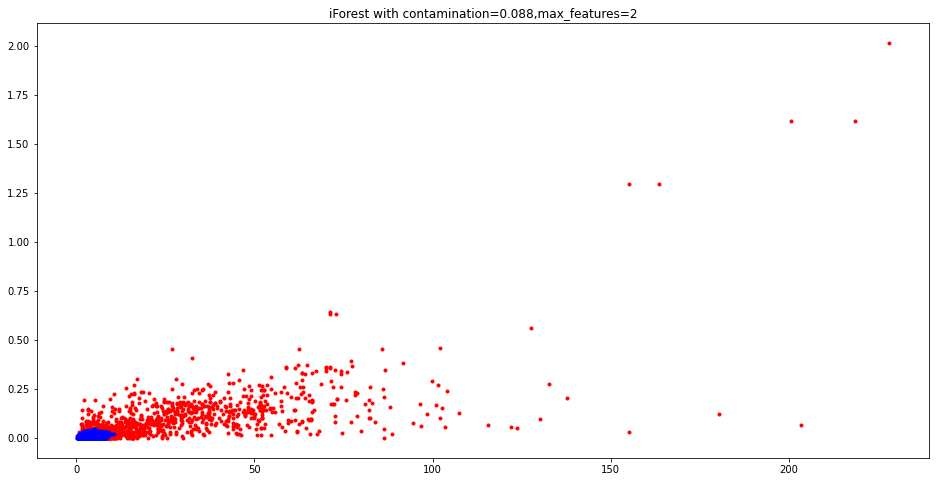

2
56
2
57
7
46
46
49
7


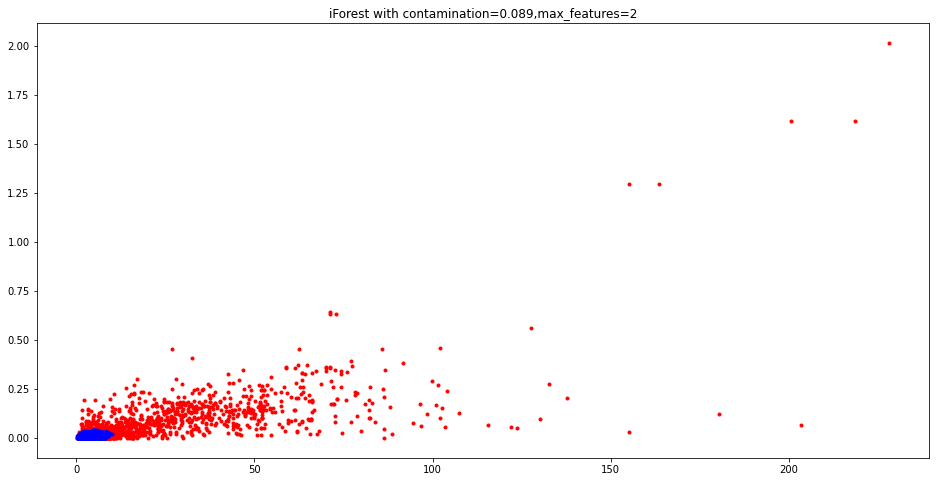

2
56
2
57
7
46
46
49
7


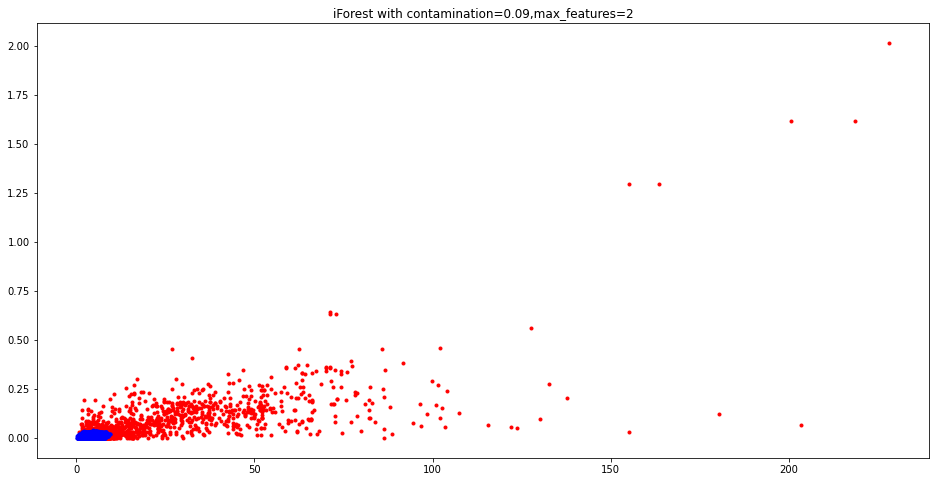

2
56
2
57
7
46
46
49
7


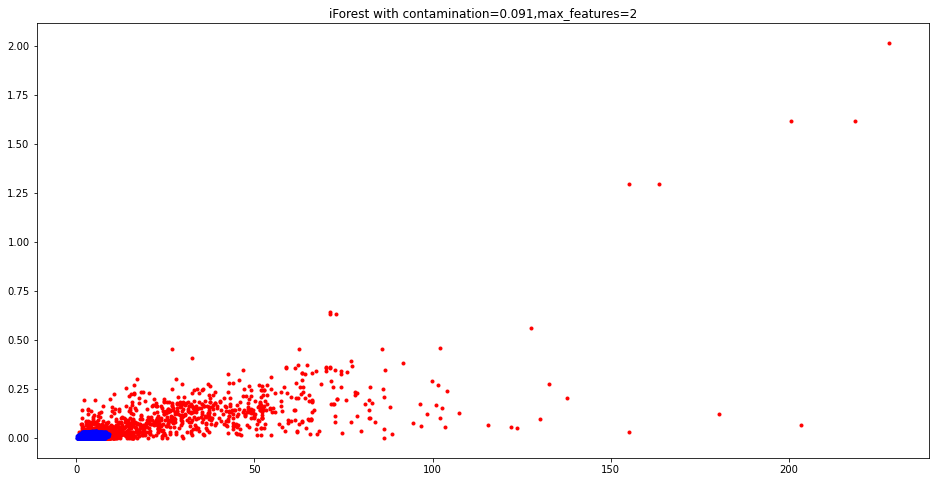

2
56
2
57
7
46
46
49
7


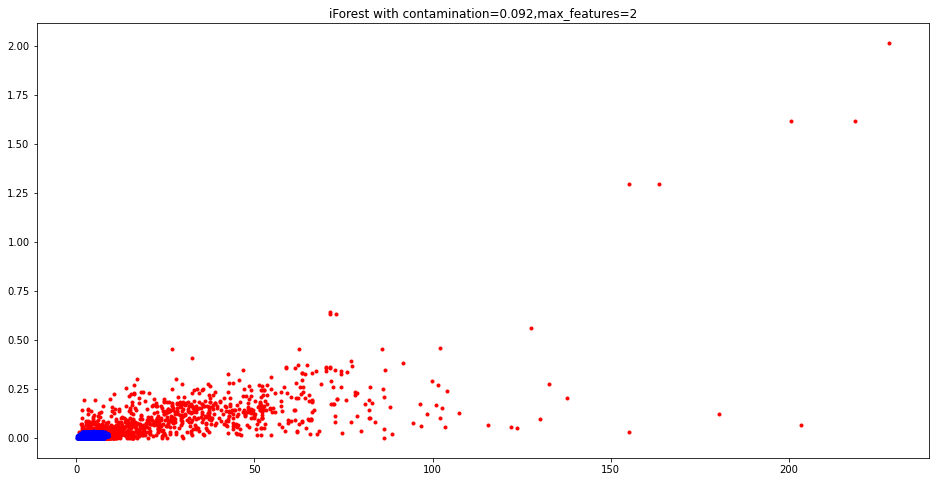

2
56
2
57
7
46
46
49
7


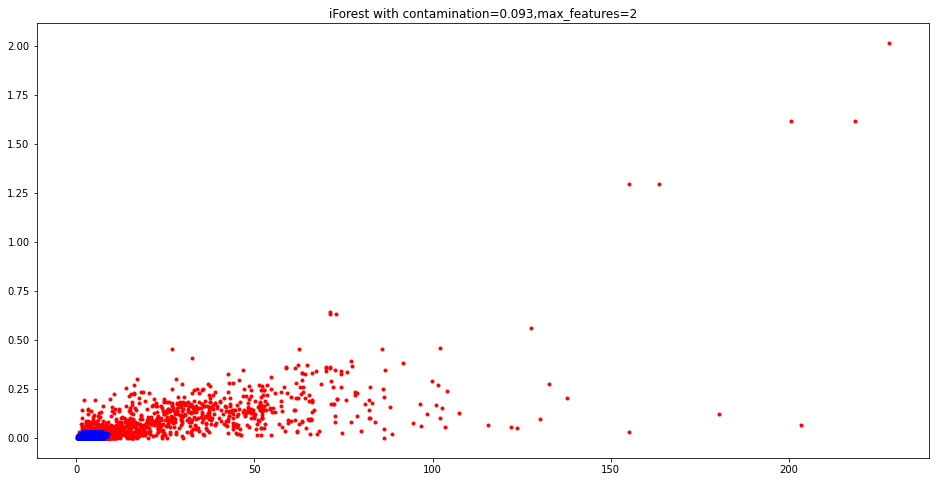

2
56
2
57
7
46
46
49
7


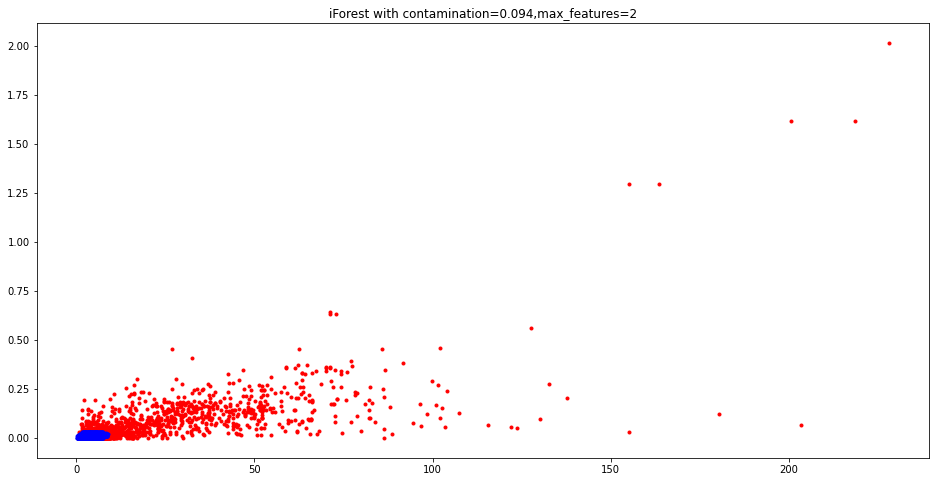

2
56
2
57
6
46
46
49
7


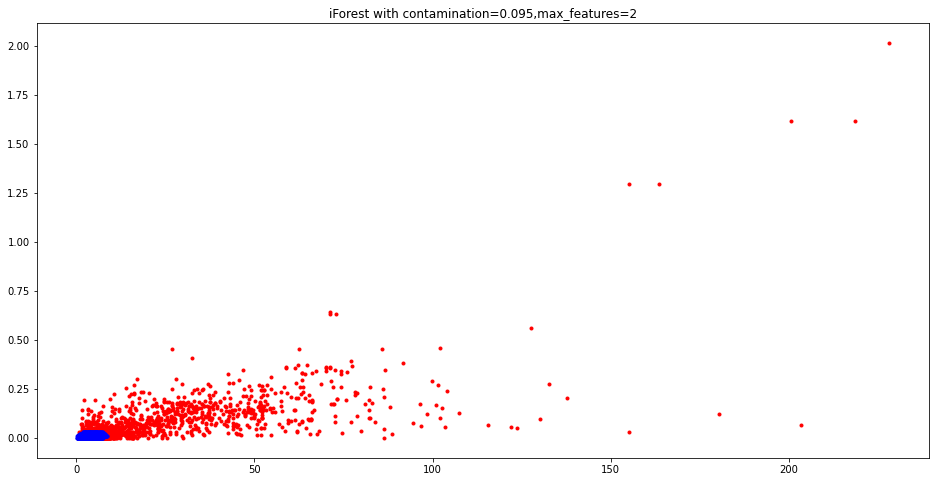

2
56
2
57
6
46
46
49
7


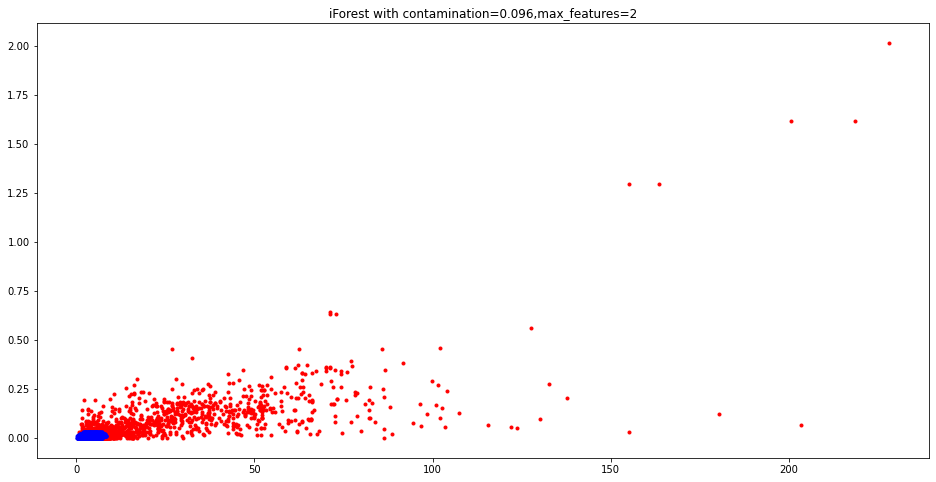

2
56
2
57
6
46
46
49
7


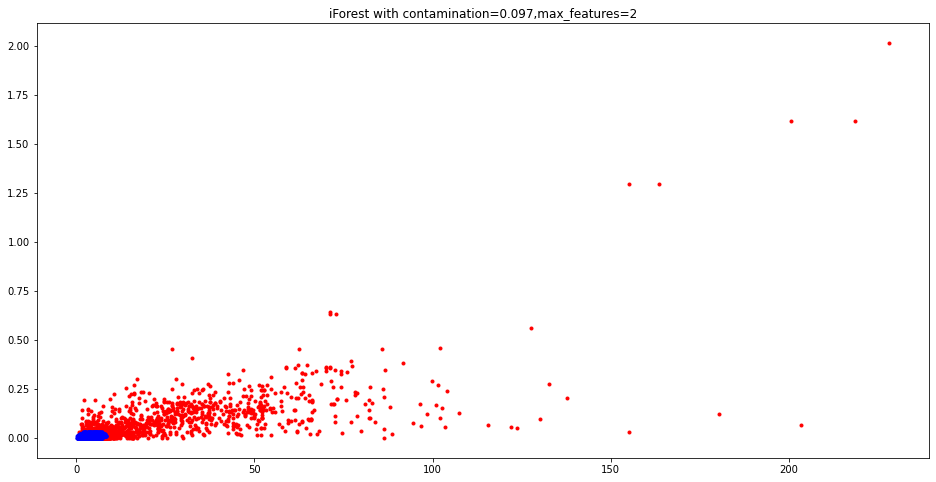

2
56
2
57
6
46
46
49
7


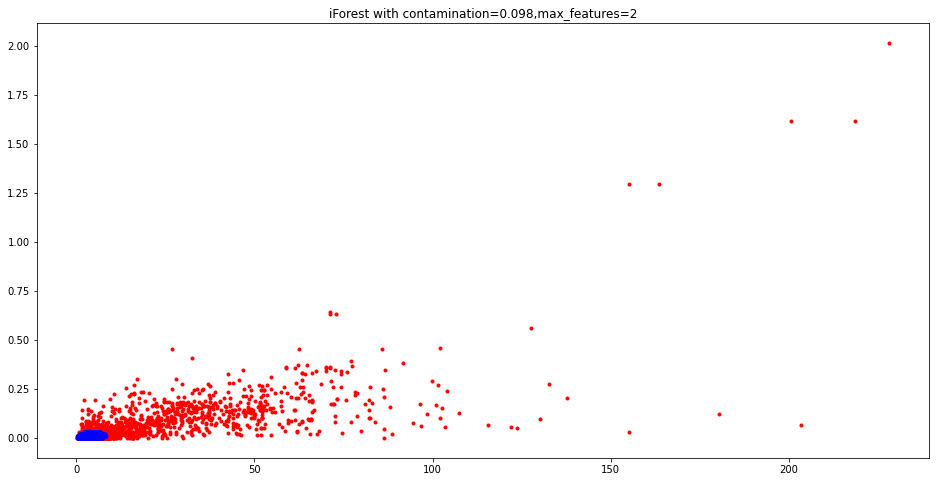

2
56
2
57
6
46
46
49
7


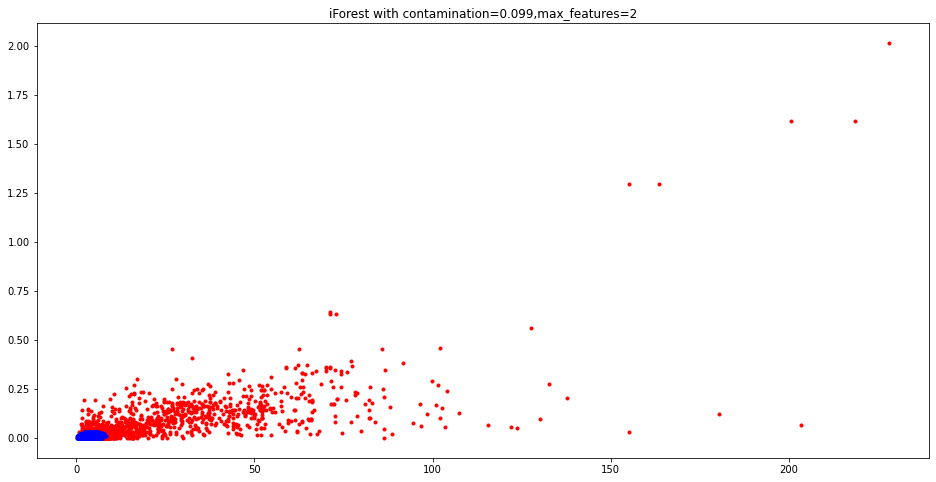

2
56
2
57
6
46
46
49
7


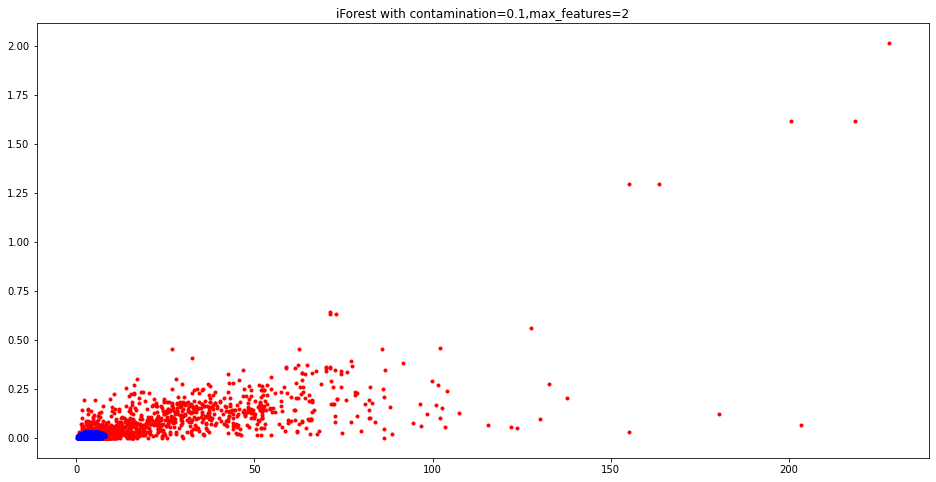

2
56
2
57
6
46
46
49
7


In [119]:
findBestModel(X_train,X_test,Y_test)

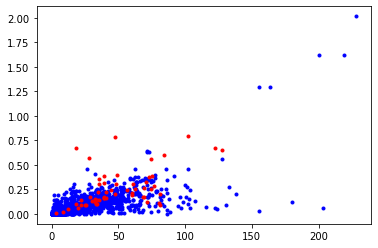

In [102]:
plt.plot(df.gyrTotal,df.accTotal,'b.')
plt.plot(df_test.gyrTotal[df_test.files == 2],df_test.accTotal[df_test.files == 2],'r.')
